In [165]:
%matplotlib inline

# To do

* split into subsections: host info, amenities, crime, calendar
* fix links
* add Tanner EDA - done
* add David EDA - done
* add Sakib EDA
* add Emily EDA
* add Yisheng EDA 

In [166]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import duckdb
from tabulate import tabulate

sns.set(style="whitegrid")

THEME = "darkslategray"

In [167]:
print(duckdb.__version__)

0.5.1


In [168]:
import warnings
warnings.filterwarnings('ignore')

# Exploratory Data Analysis (EDA)

The AirBnB data has been brought in as separate tables for detailed listings, calendar data, and review data. An external source for Washington D.C. crime statistics has also been brought in.

We've chosen price as the target variable. 

The total data set can be broken down into the following:
1. Host Data - e.g. host location, response time, listings count
2. Amenities - e.g. number of bedrooms, bathrooms
3. Review Scores - e.g. cleanliness, value
4. Crime - e.g. number of property crimes, violent crimes



Our initial thoughts on relationships are shown here:  

![CLD](./Feedback_CLD1.jpeg) 

<img src="Feedback_CLD1.jpeg"/>

Of the factors shown, we have partial data for the items in blue.  

We'll start with single-variable EDA, then move on to pairwise EDA, investigating the effects of the other variables on the price.

# Table of Contents

* [Information](#information)
* [Data Loading](#dataloading)
* [Single Variable EDA](#singlevariableeda)
    - [price](#price)
    - [neighborhood](#neighborhood)
    - [host_since](#host_since)
    - [host_location](#host_location)
    - [host_response_time](#host_response_time)
    - [host_response_rate](#host_respone_rate)
    - [host_acceptance_rate](#host_acceptance_rate)
    - [host_is_superhost](#host_is_superhost)
    - [host_listings_count](#host_listings_count)
    - [host_total_listings_count](#host_total_listings_count)
    - [host_verifications](#host_verifications)
    - [host_has_profile_pic](#host_has_profile_pic)
    - [host_identity_verified](#host_identity_verified)
* [Pairwise EDA - Target Variable: price](#pairwise_eda_price)
    - [neighborhood vs. price](#neighborhood_vs_price)
    - [host_since vs. price](#host_since_vs_price)
    - [host_location vs. price](#host_location_vs_price)
    - [host_response_time vs. price](#host_response_time_vs_price)
    - [host_response_rate vs. price](#host_respone_rate_vs_price)
    - [host_acceptance_rate vs. price](#host_acceptance_rate_vs_price)
    - [host_is_superhost vs. price](#host_is_superhost_vs_price)
    - [host_listings_count vs. price](#host_listings_count_vs_price)
    - [host_total_listings_count vs. price](#host_total_listings_count_vs_price)
    - [host_verifications vs. price](#host_verifications_vs_price)
    - [host_has_profile_pic vs. price](#host_has_profile_pic_vs_price)
    - [host_identity_verified vs. price](#host_identity_verified_vs_price)
* [Pairwise EDA - Target Variable: rating](#pairwise_eda_rating)
    - [neighborhood vs. rating](#neighborhood_vs_rating)
    - [host_since vs. rating](#host_since_vs_rating)
    - [host_location vs. rating](#host_location_vs_rating)
    - [host_response_time vs. rating](#host_response_time_vs_rating)
    - [host_response_rate vs. rating](#host_respone_rate_vs_rating)
    - [host_acceptance_rate vs. rating](#host_acceptance_rate_vs_rating)
    - [host_is_superhost vs. rating](#host_is_superhost_vs_rating)
    - [host_listings_count vs. rating](#host_listings_count_vs_rating)
    - [host_total_listings_count vs. rating](#host_total_listings_count_vs_rating)
    - [host_verifications vs. rating](#host_verifications_vs_rating)
    - [host_has_profile_pic vs. rating](#host_has_profile_pic_vs_rating)
    - [host_identity_verified vs. rating](#host_identity_verified_vs_rating)

<a id="dataloading"></a> 
# Data Loading

In [ ]:
con = duckdb.connect(database='ps6.duckdb', read_only=True)

## High Level Inspection

In [170]:
# Loading dataset
# connect to database

# read the result of an arbitrary SQL query to a Pandas DataFrame
all_listings = con.execute("SELECT * from all_listings").df()
all_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28076 entries, 0 to 28075
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            28076 non-null  int64         
 1   listing_url                                   28076 non-null  object        
 2   scrape_id                                     28076 non-null  int64         
 3   last_scraped                                  28076 non-null  datetime64[ns]
 4   name                                          28074 non-null  object        
 5   description                                   27666 non-null  object        
 6   neighborhood_overview                         18547 non-null  object        
 7   picture_url                                   28076 non-null  object        
 8   host_id                                       28076 non-null  int3

The all_listings table includes every row from the detailed listing data from the Inside Airbnb data source for the Washington, D.C. area from December 2021 to September 2022. This includes information about the host, amenities, and review scores.

<a id="singlevariableeda"></a> 
# Single Variable EDA

Let's start with an investigation of AirBnB `price`. Price is an integer variable that corresponds to the "daily price in local currency" of the listing. According to [https://www.alltherooms.com/analytics/average-airbnb-prices-by-city/], the average price per night for AirBnBs in DC is \$147 in 2021. We expect the numbers for 2022 to be slightly higher. I also expect the distribution to be mostly symmetric and unimodal about the mean. I think this because of the number of datapoints we have being so high that the CLT states that the distribution will approach the Normal distribution. 

When we load the `listings` table into the `listings` dataframe without altering the data at all, we must be mindful of the repeat data. For single variable EDA, it is probably ok for us to leave the duplicates in because we don't expect listings' price to change to much from quarter to quarter. When we start looking at pairwise EDA, we might need to be careful about duplicate listings when we start looking at things like counts per neighborhood and average price per neighborhood.

<a id="price"></a> 
## Price
This target variable is the price per night for a listing, set by the host.

In [172]:
all_listings["price"].describe()

count    28076.000000
mean       188.662594
std        384.123697
min          0.000000
25%         85.000000
50%        125.000000
75%        200.000000
max      24999.000000
Name: price, dtype: float64

We have just over 28,000 data points for price. The mean price per night was \\$188 which is slightly above the average price from 2021 (as is expected). The median price per night is much lower at 125 which means we likely have a skew to the right with high priced AirBnBs skewing the mean. The minimum price being 0 dollars is suspicious as is the maximum price of 24,000 dollars per night.

In [174]:
con.execute("SELECT DISTINCT id, name, price from all_listings WHERE price < 5")
low_cost = list(con.fetchall())
print(tabulate(low_cost, headers=["id", "name", "price"], tablefmt='fancy_grid'))

╒══════════╤════════════════════════════════╤═════════╕
│       id │ name                           │   price │
╞══════════╪════════════════════════════════╪═════════╡
│ 42738808 │ Capital View Hostel            │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 43036130 │ U Street Capsule Hostel        │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 46253554 │ citizenM Washington DC Capitol │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 43301430 │ Riggs Washington DC            │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 42065771 │ The LINE Hotel DC              │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 43308773 │ Viceroy Washington DC          │       0 │
╘══════════╧════════════════════════════════╧═════════╛


In [175]:
con.execute("SELECT DISTINCT id, name, price from all_listings WHERE price > 5000")
low_cost = list(con.fetchall())
print(tabulate(low_cost, headers=["id", "name", "price"], tablefmt='fancy_grid'))

╒════════════════════╤════════════════════════════════════════════════════╤═════════╕
│                 id │ name                                               │   price │
╞════════════════════╪════════════════════════════════════════════════════╪═════════╡
│           14507861 │ Entire Capitol Hill Home - 5BR/4BA                 │    5995 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│           46004444 │ Yours Truly DC, 2 Bedroom Master Suite             │   10000 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│ 614471937104927680 │ NEW Listing! Unique House+Garden Rental, sleeps 40 │    7500 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│            8303678 │ Vista 2 Bedroom Rowhome FoggyBottom                │    6000 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│            8784458 │ Spacious condo in NW, DC       

There are 6 properties with a nightly price of 0 USD and the 1 AirBnB with a price above 10,000 USD is the 25,000 USD listing called "The Dupont Diamond" - a diamond indeed! There are also a handful of properties above 5000 and/or equal to 10,000. It might be worth removing these listings from the dataset.

In [176]:
## Code taken from Lab 5 solution
def freeman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)

Freeman Diaconis:  7


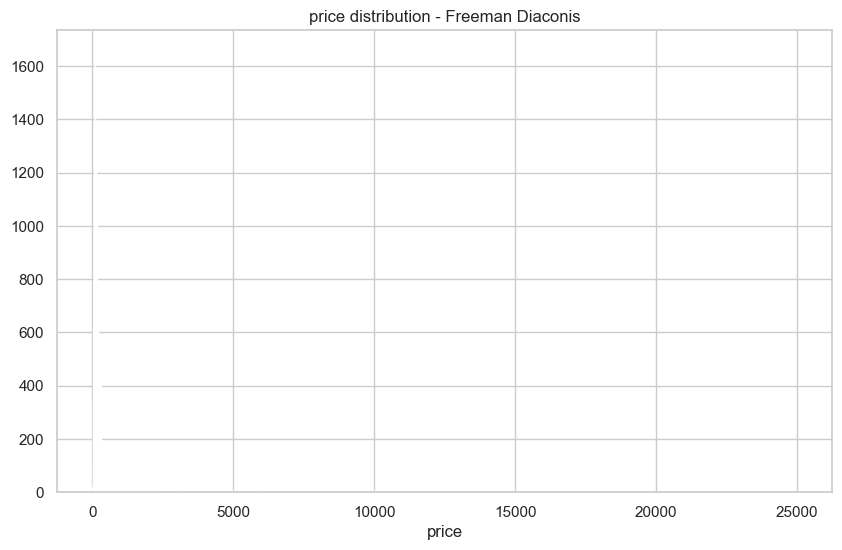

In [177]:
h = freeman_diaconis(all_listings.price)
plot_data = all_listings.price
variable_name = "price"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data,bins=bins, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

Yes - let's get rid of the 25000 listing and see if the histogram starts to make more sense

In [178]:
trimmed_listings = all_listings[all_listings.price < 1500]

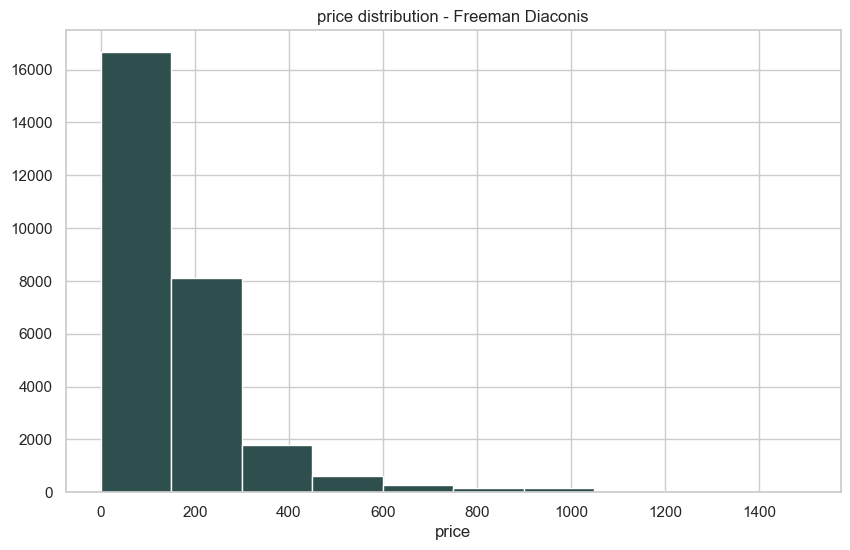

In [179]:
plot_data = trimmed_listings.price

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

Removing listings below 1500 reveals a distribution with a very strong skew to the right. The distribution appears to be almost exponential which would not make much sense given our domain knowledge. Let's use Freeman Diaconis bins and limit the listings from 0-500

Freeman Diaconis:  7


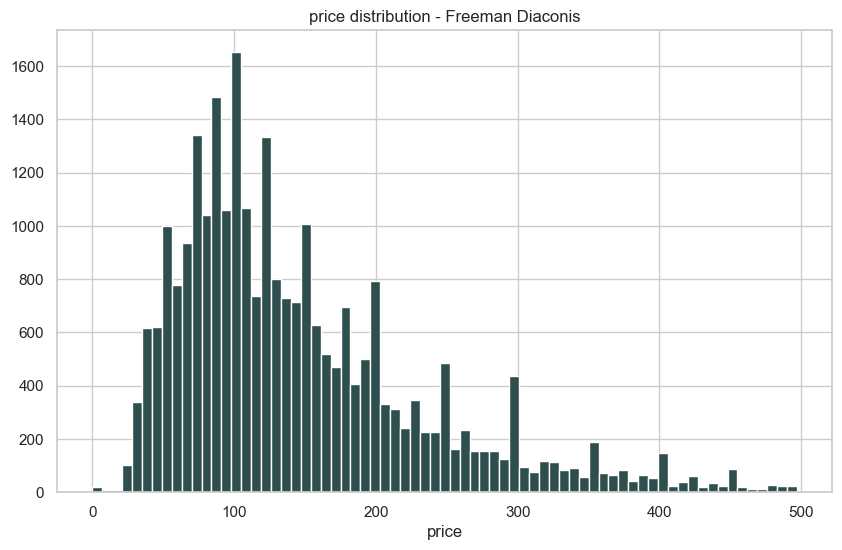

In [180]:
listings_below_500 = all_listings[all_listings.price < 500]

h = freeman_diaconis(listings_below_500.price)
plot_data = listings_below_500.price
variable_name = "price"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data,bins=bins, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

Looking at the above distribution, we see a that there is a strong skew to the right even when we remove all listings over 500 per night. This can be interpreted as the majority of AirBnBs having a nightly price that is between 85 and 200 per night but then increasingly expensive houses becomes less and less popular. 

Moving on to the single variable analysis of `neighborhoods`...

<a id="information"></a> 
## Host Information

We want to investigate the relationship between neighborhoods and the booked price of airbnbs in their area. We will start with individual variable analysis of `price` and `neighborhoods` and then do a pairwise analyis. To start this, we will load the data from the `listings` table and the `neighborhoods` table into their own Pandas dataframes to make them easier to work with

We also want the relationship between `price` and data that relates to the host like
* `host_since`
* `host_location`
* `host_response_time`
* `host_response_rate`
* `host_acceptance_rate`
* `host_is_superhost`
* `host_listings_count`
* `host_total_listings_count`
* `host_verifications`
* `host_has_profile_pic`
* `host_identity_verified`


In [ ]:
# read the result of an arbitrary SQL query to a Pandas DataFrame
neighborhoods = con.execute("SELECT * from neighborhoods").df()
neighborhoods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   neighbourhood_group  0 non-null      object
 1   neighbourhood        39 non-null     object
 2   type_outer           39 non-null     object
 3   feature_type         39 non-null     object
 4   geometry_type        39 non-null     object
 5   coordinates          39 non-null     object
dtypes: object(6)
memory usage: 2.0+ KB


<a id="rating"></a>
## Rating

In [378]:
all_listings["review_scores_rating"].describe()

count    21844.000000
mean         4.703923
std          0.588795
min          0.000000
25%          4.670000
50%          4.850000
75%          4.970000
max          5.000000
Name: review_scores_rating, dtype: float64

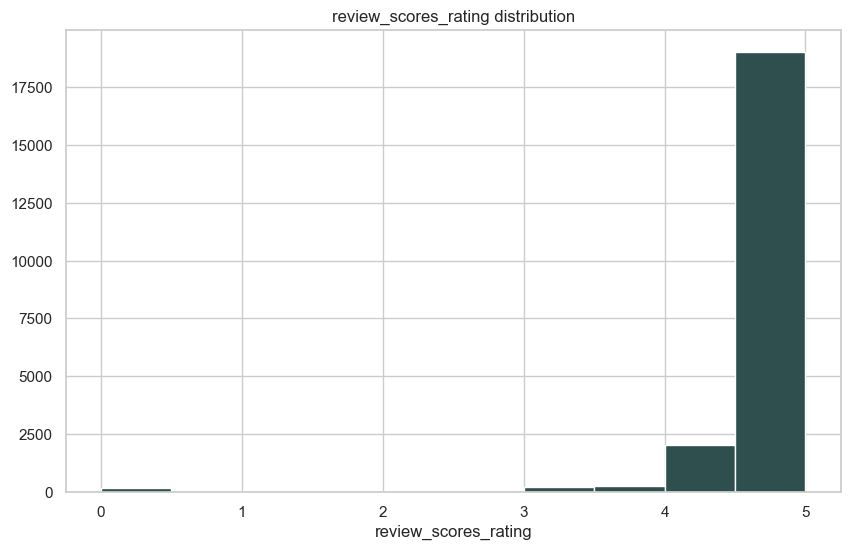

In [381]:
# h = freeman_diaconis(all_listings.review_scores_rating)
plot_data = all_listings.review_scores_rating
variable_name = "review_scores_rating"
# print("Freeman Diaconis: ", h)
# mn = int(plot_data.min())
# mx = int(plot_data.max())
# bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data, color="darkslategray")
axes.set_title(variable_name + " distribution")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

<a id="neighborhood"></a>
## Neighborhood

In [183]:
print(neighborhoods.neighbourhood)

0                  Brightwood Park, Crestwood, Petworth
1                         Brookland, Brentwood, Langdon
2                            Capitol Hill, Lincoln Park
3       Capitol View, Marshall Heights, Benning Heights
4        Cathedral Heights, McLean Gardens, Glover Park
5     Cleveland Park, Woodley Park, Massachusetts Av...
6     Colonial Village, Shepherd Park, North Portal ...
7     Columbia Heights, Mt. Pleasant, Pleasant Plain...
8      Congress Heights, Bellevue, Washington Highlands
9     Deanwood, Burrville, Grant Park, Lincoln Heigh...
10                             Douglas, Shipley Terrace
11    Downtown, Chinatown, Penn Quarters, Mount Vern...
12           Dupont Circle, Connecticut Avenue/K Street
13                         Eastland Gardens, Kenilworth
14    Edgewood, Bloomingdale, Truxton Circle, Eckington
15    Fairfax Village, Naylor Gardens, Hillcrest, Su...
16    Friendship Heights, American University Park, ...
17                      Georgetown, Burleith/Hil

There are 38 total neighbrohoods in this dataset. They appear to encompass multiple colloquially-known neighborhoods given that their names almost all consist of multiple names combined in a comma-separated list. They appear in alphabetical order and the index on right right column of the above print-out will correspond to some labels I use below.

The `neighborhoods` table also includes a `polygon` shape of the neighborhood using lat/lon points. Let's map those:

In [48]:
!pip install geopandas

distutils: /Applications/Utilities/anaconda3/include/python3.7m/UNKNOWN
sysconfig: /Applications/Utilities/anaconda3/include/python3.7m
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 1.0 MB 22 kB/s eta 0:00:013
     |████████████████████████████████| 26.5 MB 92 kB/s  eta 0:00:01
     |████████████████████████████████| 7.5 MB 489 kB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 311 kB/s eta 0:00:01
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
distutils: /Applications/Utilities/anaconda3/include/python3.7m/UNKNOWN
sysconfig: /Applications/Utilities/anaconda3/include/python3.7m
user = False
home = None
root = None
prefix = None
You should consider upgrading via the '/Applications/Utilities/anaconda3/bin/python -m pip install --upgrade pip' command.


In [184]:
import geopandas as gpd
from shapely.geometry import Polygon

p_list = []
for p in neighborhoods.coordinates:
  p_list.append(Polygon(p))

neighborhoods_gpd = gpd.GeoDataFrame(neighborhoods, crs='epsg:4326', geometry=p_list)       

neighborhoods_gpd['rep_point'] = neighborhoods_gpd['geometry'].apply(lambda x: x.representative_point().coords[:])
neighborhoods_gpd['rep_point'] = [coords[0] for coords in neighborhoods_gpd['rep_point']]

neighborhoods_gpd['alpha_index'] = list(range(1,len(neighborhoods_gpd.neighbourhood)+1))

neighborhoods_gpd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   neighbourhood_group  0 non-null      object  
 1   neighbourhood        39 non-null     object  
 2   type_outer           39 non-null     object  
 3   feature_type         39 non-null     object  
 4   geometry_type        39 non-null     object  
 5   coordinates          39 non-null     object  
 6   geometry             39 non-null     geometry
 7   rep_point            39 non-null     object  
 8   alpha_index          39 non-null     int64   
dtypes: geometry(1), int64(1), object(7)
memory usage: 2.9+ KB


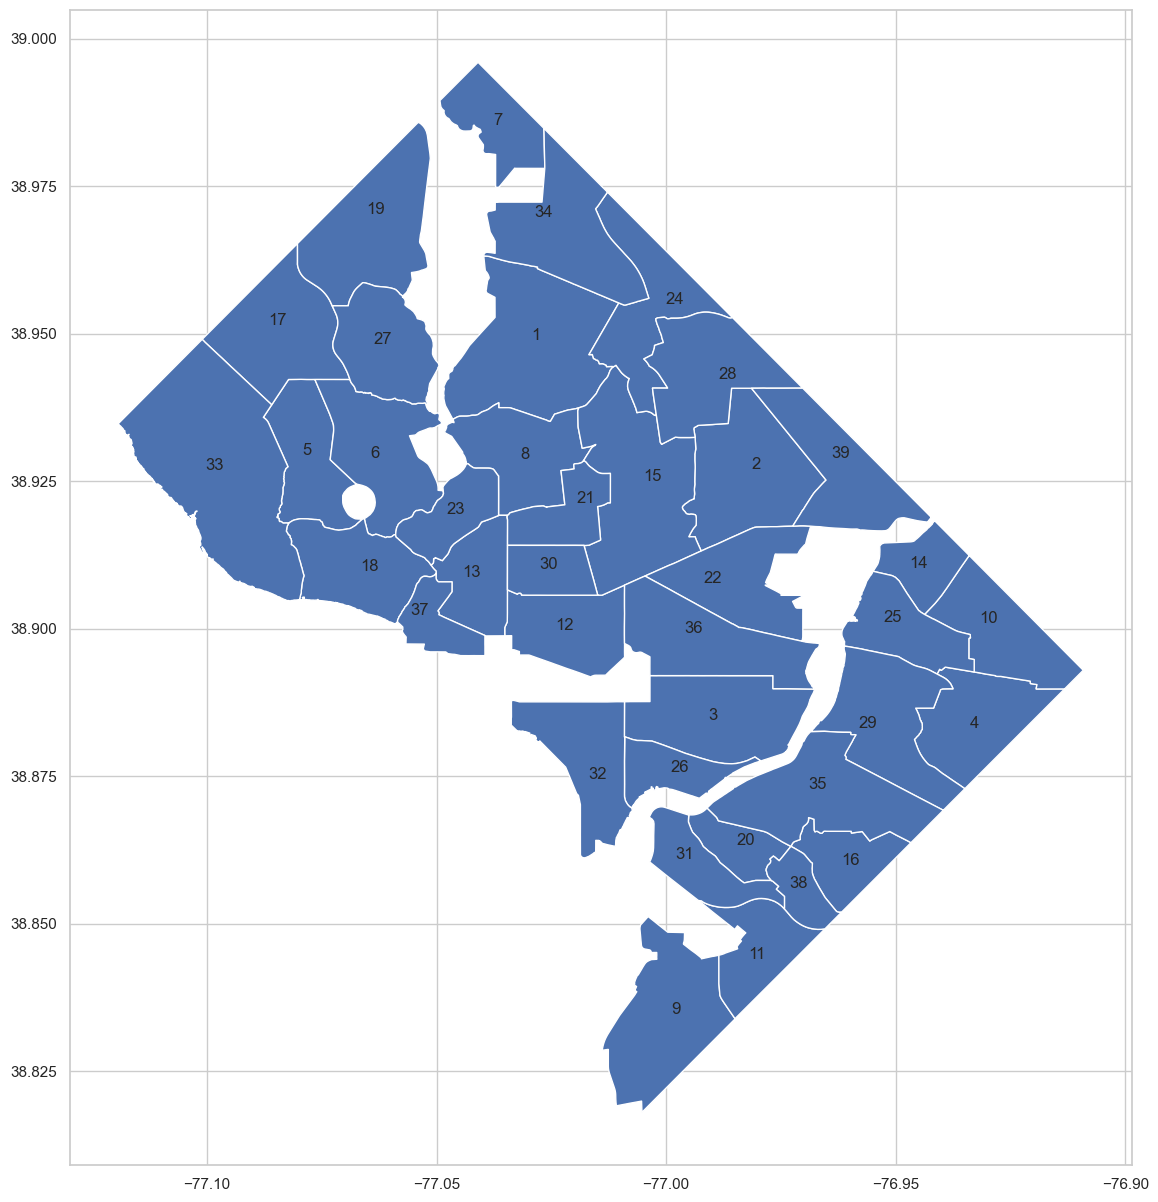

In [185]:
fig,ax = plt.subplots(figsize = (15,15))
neighborhoods_gpd.plot(ax=ax)
for idx, row in neighborhoods_gpd.iterrows():
    plt.annotate(row['alpha_index'], xy=row['rep_point'],
                 horizontalalignment='center')

plt.show()

From the above map, we can see that all of these neighborhoods exist within the federal borders of the District of Columbia  (up until now, we were unsure if these neighborhoods bled into the surrounding DMV area). The polygons are of diverse shapes and sizes.  

The white spots in the map correspond to neighborhoods clusters that are not represented in the AirBnB dataset. These are:
* Observatory Circle (small white circle in the northwest quadrant). Houses the US Naval Observatory and the house of the US Vice President.
* Rock Creek Park (long thin cluster extending from the top of the diamond to cluster 23). A national park.
* Walter Reed (trapazoidal polygon missing between 7 and 34). A military hospital.
* Arboretum, Anacostia River (long, river-shaped polygon starting between 31 and 32 and ending between 14 and 39). A river and a federally run arboretum.
* National Mall, Potomac River (The polygon missing from the entire southwest quadrant of the diamond, spanning from 33 to 9 and taking the horizontal rectanglular chunk from between 12, 36, 3, and 32). The national mall of the US Capitol and a large river between DC and Virginia.
* Joint Base, Anacostia Boilings (the misisng polygon west of 9 bordering the Potomac and Anacostia). A Naval and Joint Armed Forces base.
* Saint Elizabeth's (the rectangular polygon missing between 31, 11, and 9). A hospital.

Source: https://opendata.dc.gov/datasets/neighborhood-clusters/explore?location=38.855725%2C-77.000257%2C11.77.

**Getting unique hosts from latest listings**

In [192]:
latest_hosts_unique = latest_listings.drop_duplicates(subset='host_id')

## `host_since` <a id="host_since"></a>

In [187]:
import datetime

In [198]:
timestamp = pd.Timestamp(datetime.datetime(2021, 10, 10))
res = timestamp.today()
latest_hosts_unique.days_host = (res - latest_hosts_unique.host_since) / np.timedelta64(1,'D')
latest_hosts_unique.years_host = (res - latest_hosts_unique.host_since) / np.timedelta64(1,'Y')
latest_hosts_unique.days_host

0        5118.715739
1        4374.715739
2        5102.715739
3        3870.715739
4        4248.715739
            ...     
10531     262.715739
10547    1640.715739
10549    1028.715739
10550    1555.715739
10554     325.715739
Name: host_since, Length: 5843, dtype: float64

In [196]:
latest_hosts_unique.days_host.describe()

count    5840.000000
mean     2503.553492
std       986.443234
min        83.713938
25%      2009.713938
50%      2578.713938
75%      3151.963938
max      5123.713938
Name: host_since, dtype: float64

In [199]:
latest_hosts_unique.years_host.describe()

count    5840.000000
mean        6.854502
std         2.700790
min         0.229206
25%         5.502415
50%         7.060284
75%         8.629789
max        14.028257
Name: host_since, dtype: float64

Freeman Diaconis:  0


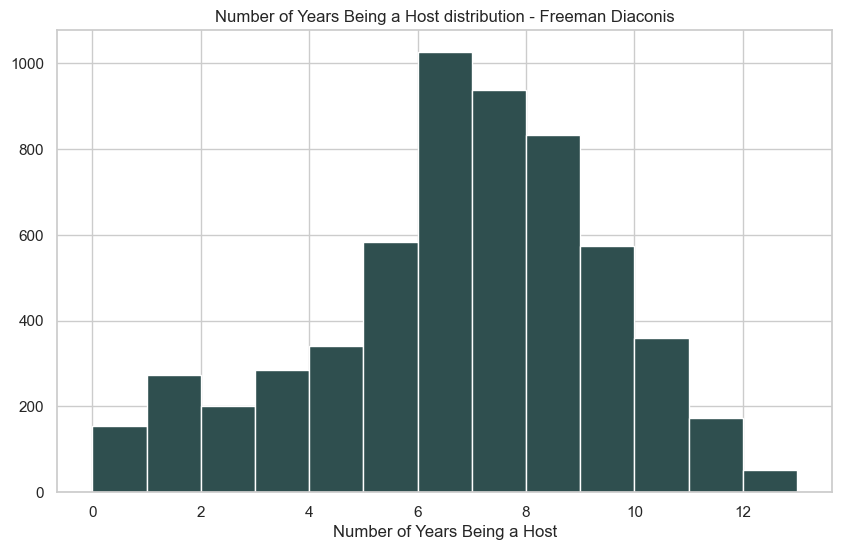

In [200]:
h = freeman_diaconis(latest_hosts_unique.years_host.dropna())
plot_data = latest_hosts_unique.years_host.dropna()
variable_name = "Number of Years Being a Host"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data,bins=bins, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

## `host_location` <a id="host_location"></a>

In [107]:
latest_listings.host_location.value_counts(normalize=True)[:10]

Washington, DC                                     0.439045
Washington, District of Columbia, United States    0.227377
Houston, Texas, United States                      0.062631
US                                                 0.035714
New York, NY                                       0.031211
United States                                      0.012882
Arlington, VA                                      0.008065
Silver Spring, MD                                  0.007331
New York, New York, United States                  0.006075
Alexandria, Virginia, United States                0.005237
Name: host_location, dtype: float64

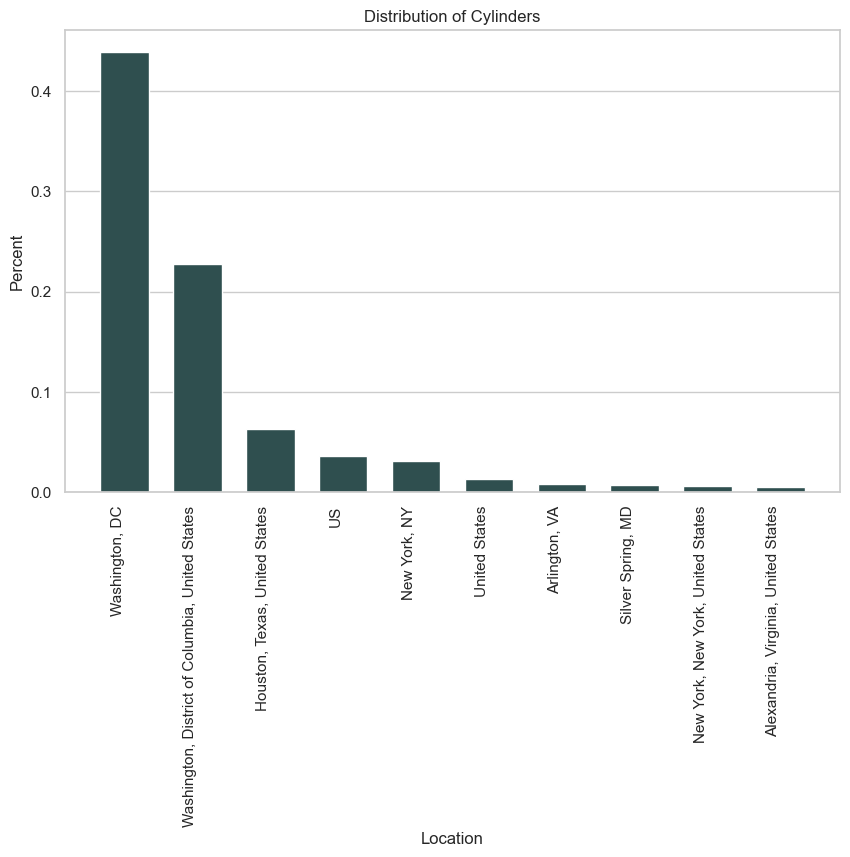

In [112]:
data = latest_listings.host_location.value_counts(normalize=True)[:10]
x = range( len(data))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, data, width, align="center", color="darkslategray")
axes.set_xticks(list(range(len(dict(latest_listings.host_location.value_counts()[:10]).values()))))
axes.set_xticklabels(dict(latest_listings.host_location.value_counts()[:10]).keys())
axes.set_title( "Distribution of Cylinders")
axes.set_xlabel("Location")
axes.set_xticklabels(dict(latest_listings.host_location.value_counts()[:10]).keys(), rotation=90, ha='right')
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

TODO: discuss

## `host_response_time` <a id="host_response_time"></a>

In [114]:
latest_listings.host_response_time.value_counts()

within an hour        5525
N/A                   2946
within a few hours    1078
within a day           657
a few days or more     192
Name: host_response_time, dtype: int64

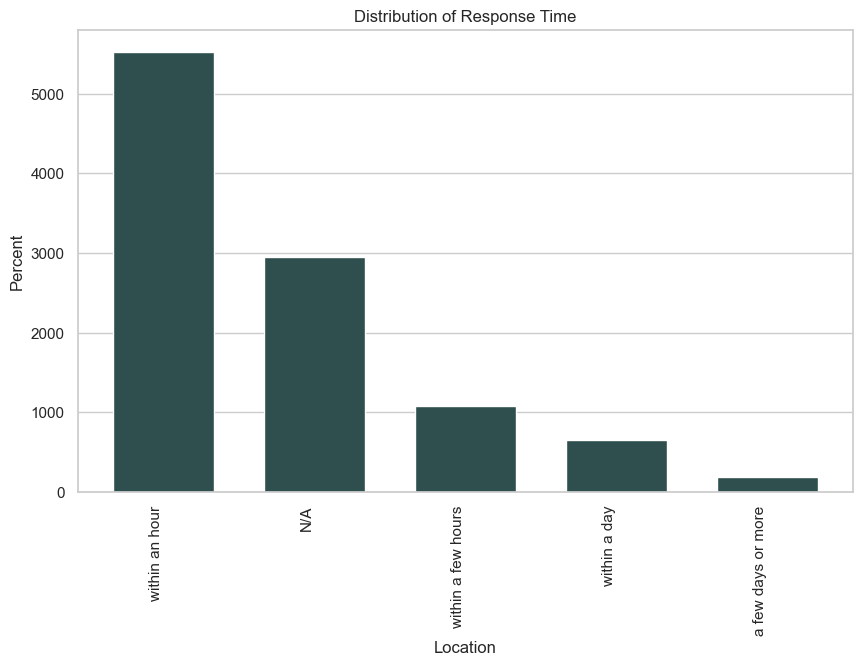

In [382]:
data = latest_listings.host_response_time.value_counts()
x = range( len(data))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.bar(x, data, width, align="center", color="darkslategray")
axes.set_xticks(list(range(len(dict(latest_listings.host_response_time.value_counts()).values()))))
axes.set_title( "Distribution of Response Time")
axes.set_xlabel("Location")
axes.set_xticklabels(dict(latest_listings.host_response_time.value_counts()).keys(), rotation=90, ha='right')
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

TODO: discuss

## `host_response_rate` <a id="host_response_rate"></a>

In [123]:
latest_listings['host_response_rate'] = latest_listings['host_response_rate'].replace('N/A',np.NaN)
latest_listings['host_response_rate'] = latest_listings['host_response_rate'].replace('%', '', regex=True).astype(float)

In [124]:
latest_listings['host_response_rate'].describe()

count    7452.000000
mean       95.040794
std        15.631311
min         0.000000
25%       100.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: host_response_rate, dtype: float64

Freeman Diaconis:  0


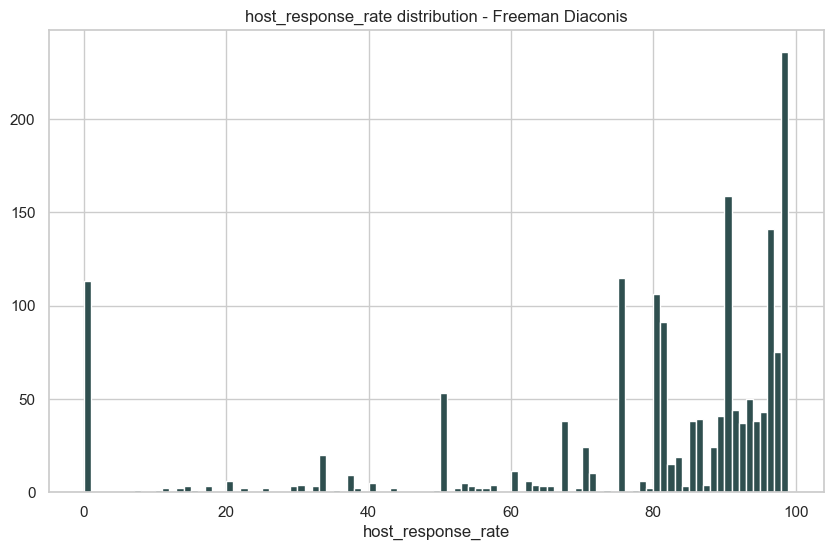

In [128]:
h = freeman_diaconis(latest_listings['host_response_rate'].dropna())
plot_data = latest_listings['host_response_rate'].dropna()
variable_name = "host_response_rate"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data,bins=bins, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

TODO: discuss

## `host_acceptance_rate` <a id="host_acceptance_rate"></a>

In [129]:
latest_listings['host_acceptance_rate'] = latest_listings['host_acceptance_rate'].replace('N/A',np.NaN)
latest_listings['host_acceptance_rate'] = latest_listings['host_acceptance_rate'].replace('%', '', regex=True).astype(float)

In [130]:
latest_listings['host_acceptance_rate'].describe()

count    8120.000000
mean       85.751108
std        24.362805
min         0.000000
25%        85.000000
50%        97.000000
75%       100.000000
max       100.000000
Name: host_acceptance_rate, dtype: float64

Freeman Diaconis:  1


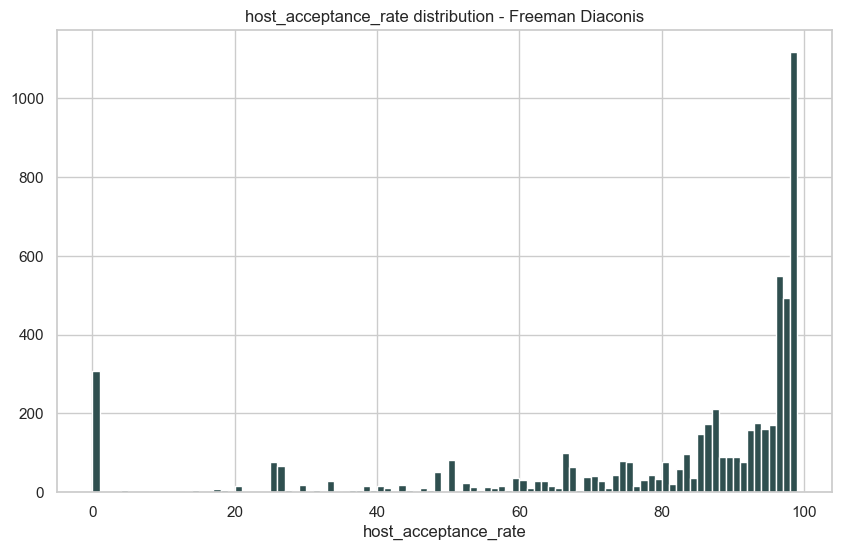

In [131]:
h = freeman_diaconis(latest_listings['host_acceptance_rate'].dropna())
plot_data = latest_listings['host_acceptance_rate'].dropna()
variable_name = "host_acceptance_rate"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data,bins=bins, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

TODO: discuss

## `host_is_superhost` <a id="host_is_superhost"></a>

In [132]:
latest_listings.host_is_superhost.value_counts()

False    7950
True     2604
Name: host_is_superhost, dtype: int64

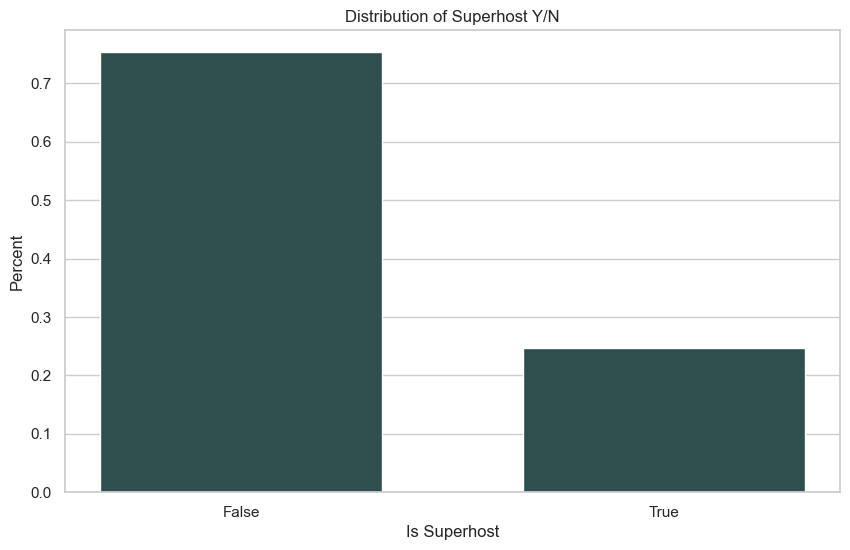

In [135]:
data = latest_listings.host_is_superhost.value_counts(normalize=True)
x = range( len(data))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.bar(x, data, width, align="center", color="darkslategray")
axes.set_xticks(list(range(len(dict(latest_listings.host_is_superhost.value_counts()).values()))))
axes.set_title( "Distribution of Superhost Y/N")
axes.set_xlabel("Is Superhost")
axes.set_xticklabels(dict(latest_listings.host_is_superhost.value_counts()).keys())
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

TODO: discuss

## `host_listings_count` <a id="host_listings_count"></a>

In [136]:
latest_listings['host_listings_count'].describe()

count    10398.000000
mean       165.797750
std        676.694138
min          0.000000
25%          1.000000
50%          2.000000
75%         10.000000
max       4057.000000
Name: host_listings_count, dtype: float64

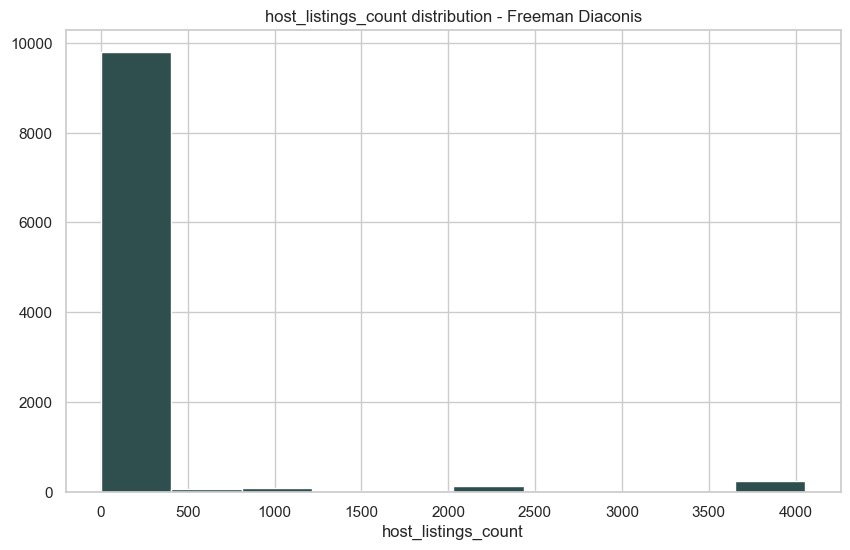

In [138]:
# h = freeman_diaconis(latest_listings['host_listings_count'].dropna())
# plot_data = latest_listings['host_listings_count'].dropna()
# variable_name = "host_listings_count"
# print("Freeman Diaconis: ", h)
# mn = int(plot_data.min())
# mx = int(plot_data.max())
# bins = [i for i in range( mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

TODO: discuss

Freeman Diaconis:  0


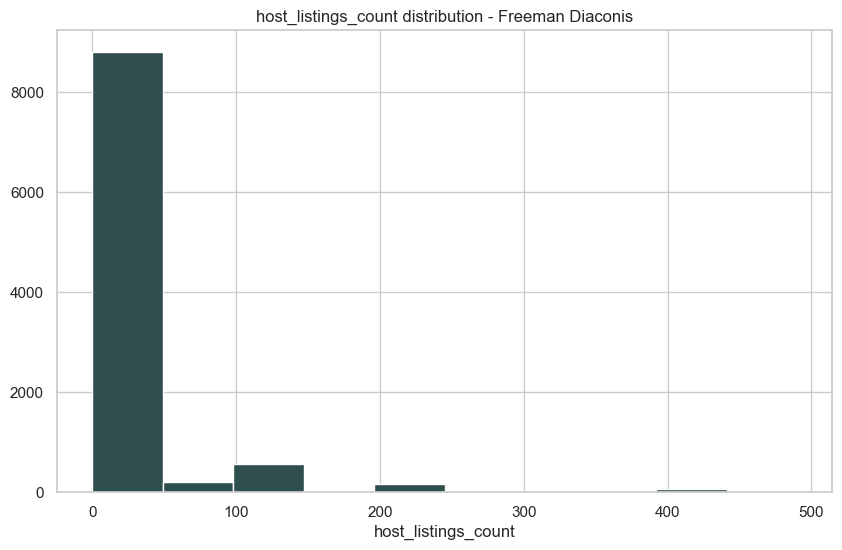

In [139]:
latest_listings.host_listings_count_under_500 = latest_listings.host_listings_count[latest_listings.host_listings_count < 500]
h = freeman_diaconis(latest_listings.host_listings_count_under_500.dropna())
plot_data = latest_listings.host_listings_count_under_500.dropna()
variable_name = "host_listings_count"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

TODO: discuss

Freeman Diaconis:  0


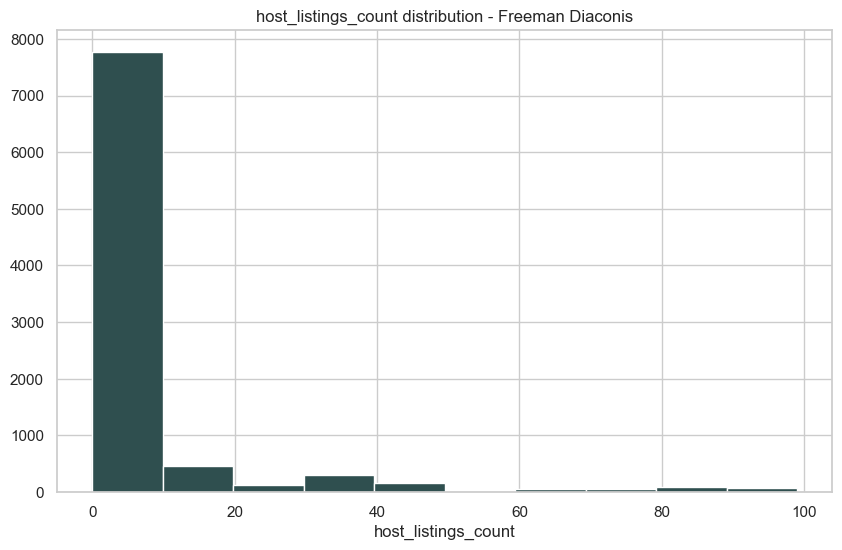

In [140]:
latest_listings.host_listings_count_under_100 = latest_listings.host_listings_count[latest_listings.host_listings_count < 100]
h = freeman_diaconis(latest_listings.host_listings_count_under_100.dropna())
plot_data = latest_listings.host_listings_count_under_100.dropna()
variable_name = "host_listings_count"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

TODO: discuss

Freeman Diaconis:  0


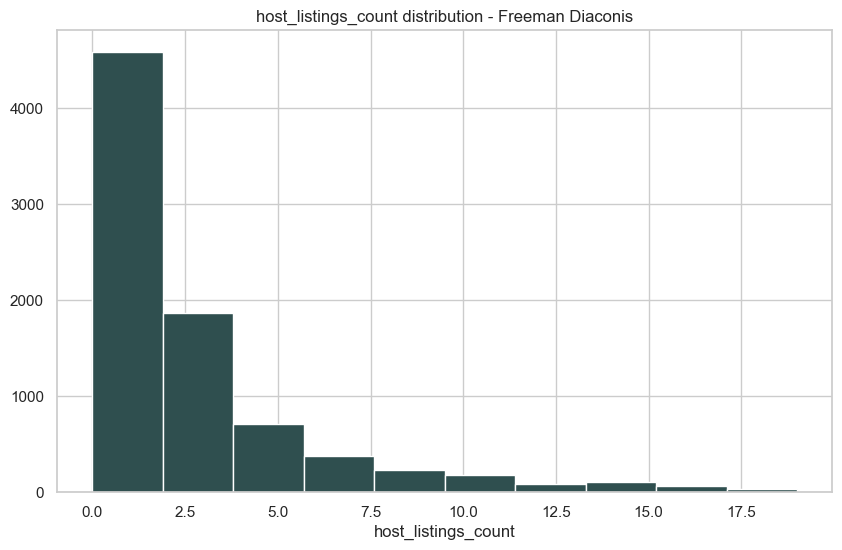

In [141]:
latest_listings.host_listings_count_under_20 = latest_listings.host_listings_count[latest_listings.host_listings_count < 20]
h = freeman_diaconis(latest_listings.host_listings_count_under_20.dropna())
plot_data = latest_listings.host_listings_count_under_20.dropna()
variable_name = "host_listings_count"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

TODO: discuss

## `host_total_listings_count` <a id="host_total_listings_count"></a>
UNUSED

## `host_verifications` <a id="host_verifications"></a>

In [145]:
latest_listings.host_verifications.value_counts(normalize=True)[:10]

['email', 'phone']                                                                                    0.550095
['email', 'phone', 'work_email']                                                                      0.136080
['phone']                                                                                             0.051705
['email', 'phone', 'reviews', 'kba']                                                                  0.024716
['email', 'phone', 'reviews', 'jumio', 'government_id']                                               0.016004
None                                                                                                  0.015341
['email', 'phone', 'reviews']                                                                         0.014583
['email', 'phone', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']    0.010511
['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'government_id']                      0.010133
[

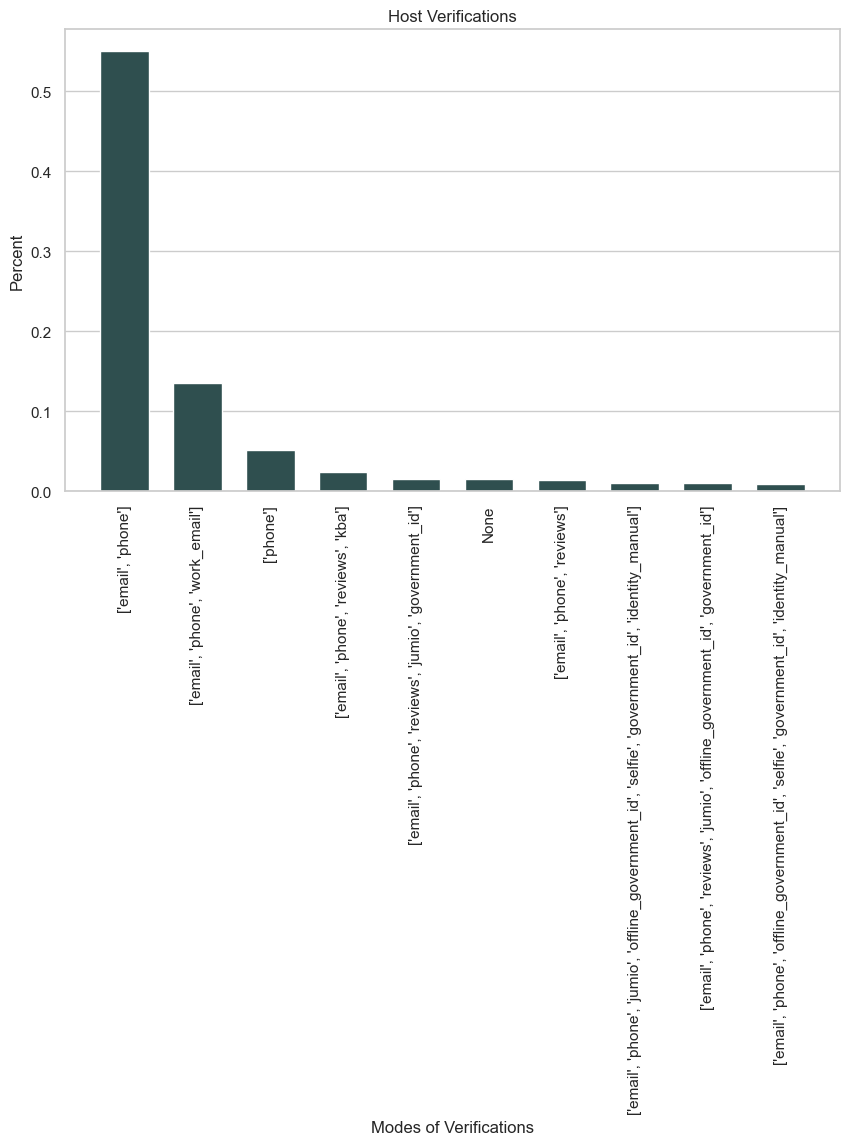

In [155]:
data = latest_listings.host_verifications.value_counts(normalize=True)[:10]
x = range( len(data))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.bar(x, data, width, align="center", color="darkslategray")
axes.set_xticks(list(range(len(dict(latest_listings.host_verifications.value_counts(normalize=True)[:10]).values()))))
axes.set_title( "Host Verifications")
axes.set_xlabel("Modes of Verifications")
axes.set_xticklabels(dict(latest_listings.host_verifications.value_counts(normalize=True)[:10]).keys(),rotation=90)
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

TODO: discuss

## `host_has_profile_pic` <a id="host_has_profile_pic"></a>

In [147]:
latest_listings.host_has_profile_pic.value_counts()

True     10325
False       73
Name: host_has_profile_pic, dtype: int64

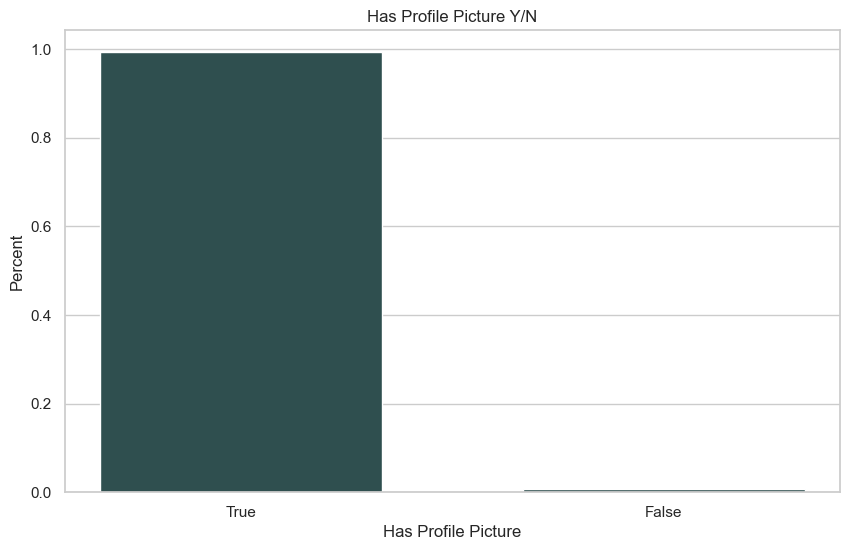

In [154]:
data = latest_listings.host_has_profile_pic.value_counts(normalize=True)
x = range( len(data))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.bar(x, data, width, align="center", color="darkslategray")
axes.set_xticks(list(range(len(dict(latest_listings.host_has_profile_pic.value_counts()).values()))))
axes.set_title( "Has Profile Picture Y/N")
axes.set_xlabel("Has Profile Picture")
axes.set_xticklabels(dict(latest_listings.host_has_profile_pic.value_counts()).keys())
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

TODO: discuss

## `host_identity_verified` <a id="host_identity_verified"></a>

In [150]:
latest_listings.host_identity_verified.value_counts()

True     8675
False    1723
Name: host_identity_verified, dtype: int64

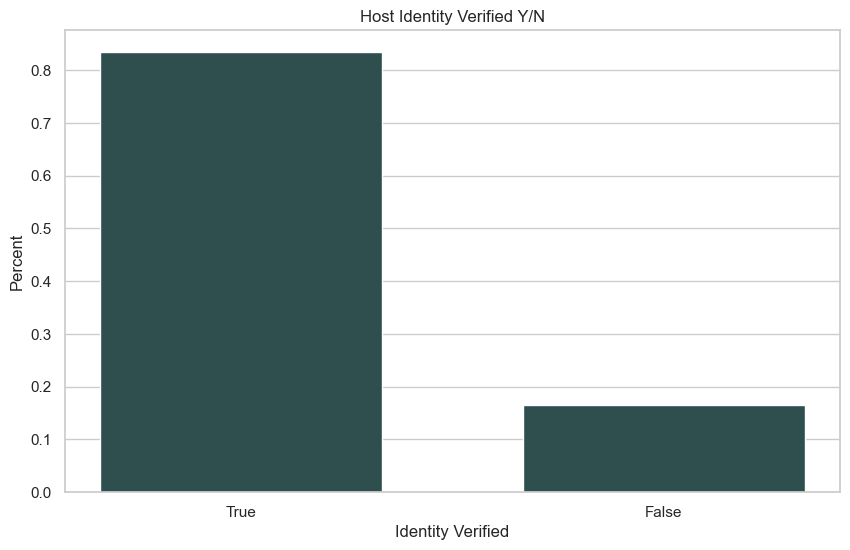

In [153]:
data = latest_listings.host_identity_verified.value_counts(normalize=True)
x = range( len(data))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.bar(x, data, width, align="center", color="darkslategray")
axes.set_xticks(list(range(len(dict(latest_listings.host_identity_verified.value_counts()).values()))))
axes.set_title( "Host Identity Verified Y/N")
axes.set_xlabel("Identity Verified")
axes.set_xticklabels(dict(latest_listings.host_identity_verified.value_counts()).keys())
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

TODO: discuss

## Rating (`review_scores_rating`) <a id="rating"></a>

In [157]:
latest_listings["review_scores_rating"].describe()

count    7740.000000
mean        4.680700
std         0.636749
min         0.000000
25%         4.660000
50%         4.850000
75%         4.970000
max         5.000000
Name: review_scores_rating, dtype: float64

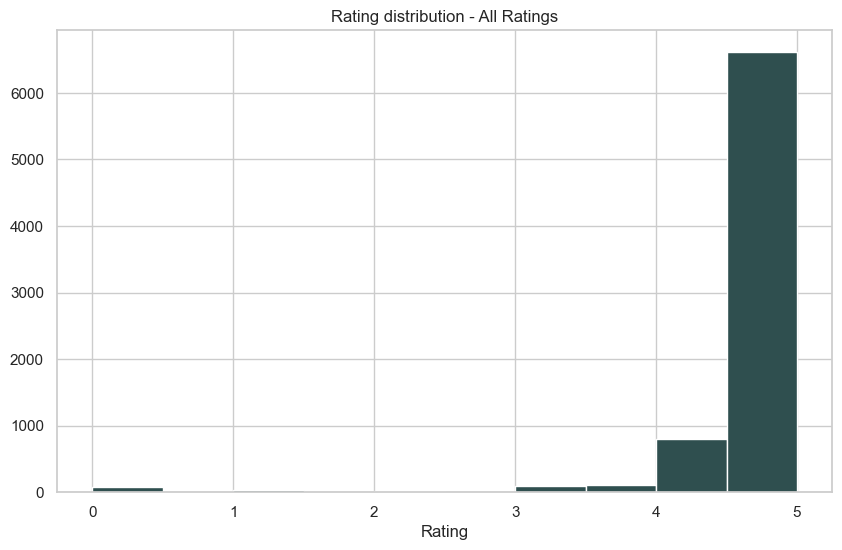

In [162]:
# h = freeman_diaconis(latest_listings["review_scores_rating"].dropna())
plot_data = latest_listings["review_scores_rating"].dropna()
variable_name = "Rating"
# print("Freeman Diaconis: ", h)
# mn = int(plot_data.min())
# mx = int(plot_data.max())
# bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data, color="darkslategray")
axes.set_title(variable_name + " distribution - All Ratings")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

TODO: discuss

## Amenities / Room descriptors
The following room descriptors give information about the rental property. How many rooms, bathrooms, and beds does it have? How many people can it accomodate? All things being equal, the more of these will mean a higher price to rent. 

* property_type - text
* room_type - text - currently in shared listings
* accomodates - integer
* bathrooms - text  (problem-- this is showing up as blanks)
* bathrooms_text - text
* bedrooms - integer
* beds- integer
* amenities - list in []- This could be expanded to individual columns


Target Variable
* price


For the following exploration, we will use the latest_listings table, which includes only one of each listing, taking the most recent data if there were duplicates in the data set.

First, we'll bring in the amenities information and look at it from a high level

In [ ]:
con.execute("select property_type, room_type, accommodates, bathrooms, bathrooms_text, bedrooms, beds, amenities, price from latest_listings;")
listings = con.fetchall()
room_columns = ['property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price']
listings_df = pd.DataFrame(listings, columns=room_columns)
listings_df.head()

property_type        room_type  accommodates bathrooms  \
0         Private room in home     Private room             1      None   
1  Private room in rental unit     Private room             1      None   
2    Private room in townhouse     Private room             3      None   
3                 Entire condo  Entire home/apt             2      None   
4        Private room in condo     Private room             1      None   

   bathrooms_text  bedrooms  beds  \
0  1 private bath       1.0   1.0   
1  2 shared baths       1.0   1.0   
2  1 private bath       1.0   2.0   
3       1.5 baths       1.0   1.0   
4  3 shared baths       1.0   1.0   

                                           amenities  price  
0  ["Dryer", "Smoke alarm", "Cooking basics", "In...   67.0  
1  ["Smoke alarm", "Cooking basics", "Bed linens"...   39.0  
2  ["Dryer", "Smoke alarm", "Single level home", ...   75.0  
3  ["Dryer", "TV with standard cable", "Cooking b...  250.0  
4  ["Smoke alarm", "Cooking basics", "Bed linens"...   35.0

<todo high level description>

<a id="price"></a> 
## Price

In [ ]:
listings_df["price"].describe()

count    10560.000000
mean       198.181818
std        422.463628
min          0.000000
25%         85.000000
50%        129.000000
75%        206.000000
max      24999.000000
Name: price, dtype: float64

In [ ]:
from tabulate import tabulate

In [ ]:
con.execute("SELECT DISTINCT id, name, price from all_listings WHERE price < 5")
low_cost = list(con.fetchall())
print(tabulate(low_cost, headers=["id", "name", "price"], tablefmt='fancy_grid'))

╒══════════╤════════════════════════════════╤═════════╕
│       id │ name                           │   price │
╞══════════╪════════════════════════════════╪═════════╡
│ 42738808 │ Capital View Hostel            │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 43036130 │ U Street Capsule Hostel        │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 46253554 │ citizenM Washington DC Capitol │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 43301430 │ Riggs Washington DC            │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 42065771 │ The LINE Hotel DC              │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 43308773 │ Viceroy Washington DC          │       0 │
╘══════════╧════════════════════════════════╧═════════╛


In [ ]:
con.execute("SELECT DISTINCT id, name, price from all_listings WHERE price > 5000")
low_cost = list(con.fetchall())
print(tabulate(low_cost, headers=["id", "name", "price"], tablefmt='fancy_grid'))

╒════════════════════╤════════════════════════════════════════════════════╤═════════╕
│                 id │ name                                               │   price │
╞════════════════════╪════════════════════════════════════════════════════╪═════════╡
│           14507861 │ Entire Capitol Hill Home - 5BR/4BA                 │    5995 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│           46004444 │ Yours Truly DC, 2 Bedroom Master Suite             │   10000 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│ 614471937104927680 │ NEW Listing! Unique House+Garden Rental, sleeps 40 │    7500 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│            8303678 │ Vista 2 Bedroom Rowhome FoggyBottom                │    6000 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│            8784458 │ Spacious condo in NW, DC       

In [ ]:
## Code taken from Lab 5 solution
def freeman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)

Freeman Diaconis:  11


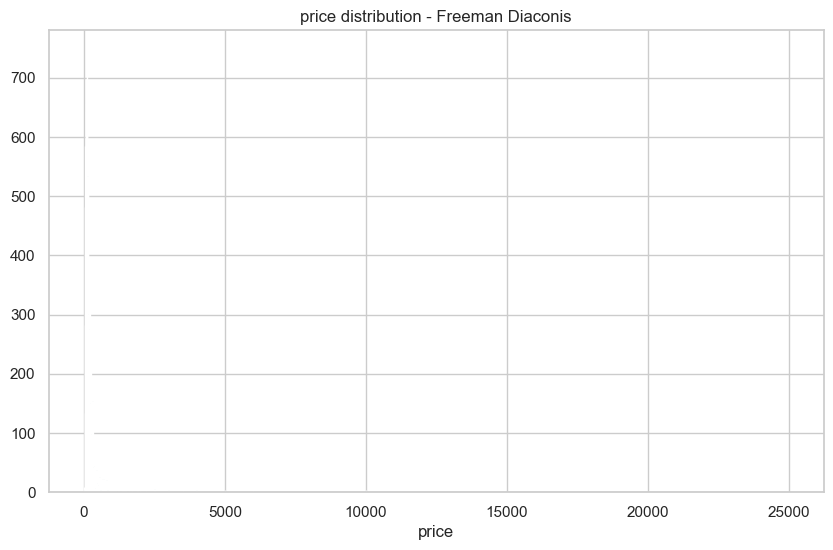

In [ ]:
h = freeman_diaconis(listings_df.price)
plot_data = listings_df.price
variable_name = "price"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data,bins=bins, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

In [ ]:
trimmed_listings = listings_df[listings_df.price < 1500]

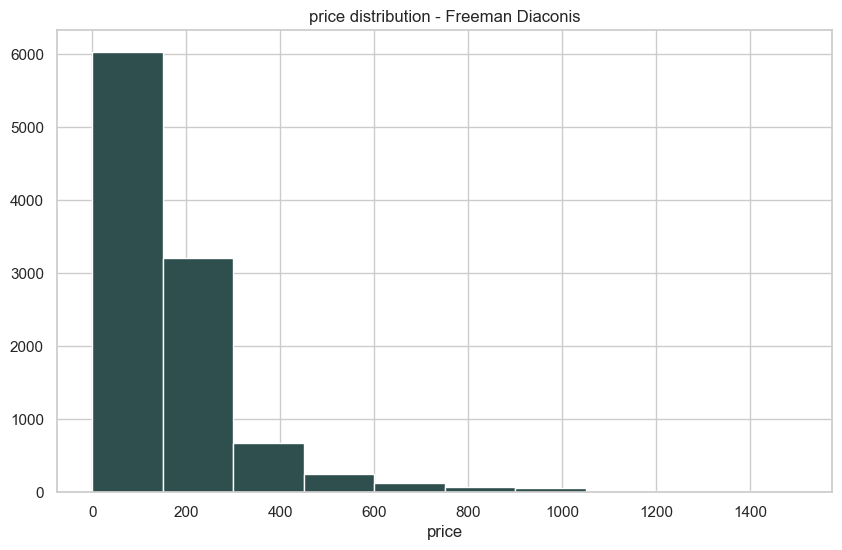

In [ ]:
plot_data = trimmed_listings.price

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

In [ ]:
# not needed
#listings_df['price'] = listings_df['price'].replace('[\$\,]', '', regex=True).astype(float)
#listings_df['price'].head()

_Use Tanner's descriptions here_


We should also limit price to those over 0


In [ ]:
trimmed_listings = listings_df[listings_df.price > 0]

## Property_Type

First, we'll look at what this column describes.


Queries:
* select distinct room_type, property_type from listings order by room_type;  
* select count(property_type), property_type from listings group by property_type;  
* select distinct property_type from listings;  


In [ ]:
listings_df.property_type.describe()

count                  10560
unique                    61
top       Entire rental unit
freq                    3488
Name: property_type, dtype: object

There are 61 distinct values for this column, with the most frequent item being "Entire rental unit."

Next, we'll look at the distribution of each category. Since there are 61 of these, we'll rely on a table to parse the info.

In [ ]:
con.execute("select property_type, count(property_type) as prop_count from latest_listings group by property_type order by prop_count desc;")
distinct_property_types = con.fetchall()
print(tabulate(distinct_property_types, headers=['Property Type', 'Count'], tablefmt='fancy_grid'))

╒═════════════════════════════════════╤═════════╕
│ Property Type                       │   Count │
╞═════════════════════════════════════╪═════════╡
│ Entire rental unit                  │    3488 │
├─────────────────────────────────────┼─────────┤
│ Entire serviced apartment           │     889 │
├─────────────────────────────────────┼─────────┤
│ Entire townhouse                    │     811 │
├─────────────────────────────────────┼─────────┤
│ Entire home                         │     739 │
├─────────────────────────────────────┼─────────┤
│ Entire guest suite                  │     632 │
├─────────────────────────────────────┼─────────┤
│ Private room in home                │     606 │
├─────────────────────────────────────┼─────────┤
│ Entire condo                        │     595 │
├─────────────────────────────────────┼─────────┤
│ Private room in townhouse           │     522 │
├─────────────────────────────────────┼─────────┤
│ Private room in rental unit         │     449 │


The most frequent property types include "entire" in the description, initially indicating that you would have the unit to yourself.

This is a category for the listing that indicates:
1) Is this an apartment, condo, townhome, house, guesthouse, vacation home, etc?
2) Which part of category 1 does the renter get to themselves?

It should be separated into two descriptors if possible. Part 2 is covered by Room_Type below.


## Room_Type
The property type above seemed to include the "Room type". We'll see what it actually means:


In [ ]:
con.execute("select distinct room_type from latest_listings;")
distrinct_room_types = con.fetchall()
distrinct_room_types

[('Private room',), ('Entire home/apt',), ('Shared room',), ('Hotel room',)]

This is a nice categorical in that there are few options:
* Entire home/apt
* Private room
* Shared room
* Hotel room

This covers part 2 of the "property type" above. 

Let's see the relationship between property_type and room_type

In [ ]:
con.execute("select distinct room_type, property_type, count(property_type) as counts from latest_listings group by room_type, property_type order by room_type, counts desc;")
roomtype_proptype_counts = con.fetchall()
roomtype_proptype_counts_df = pd.DataFrame(roomtype_proptype_counts, columns=['room_type', 'property_type', 'property_type_counts'])

print(tabulate(roomtype_proptype_counts, headers=['room_type', 'property_type', 'counts'], tablefmt='pretty'))

+-----------------+-------------------------------------+--------+
|    room_type    |            property_type            | counts |
+-----------------+-------------------------------------+--------+
| Entire home/apt |         Entire rental unit          |  3488  |
| Entire home/apt |      Entire serviced apartment      |  889   |
| Entire home/apt |          Entire townhouse           |  811   |
| Entire home/apt |             Entire home             |  739   |
| Entire home/apt |         Entire guest suite          |  632   |
| Entire home/apt |            Entire condo             |  595   |
| Entire home/apt |       Entire residential home       |  307   |
| Entire home/apt |     Entire condominium (condo)      |  300   |
| Entire home/apt |          Entire guesthouse          |   83   |
| Entire home/apt |             Entire loft             |   51   |
| Entire home/apt |        Entire vacation home         |   17   |
| Entire home/apt |         Room in aparthotel          |   16

Each of the property types maps to a room type, and it looks like most of the listings in the Washington DC area are for Entire homes/apartments.

We'll plot the counts for each of these four types below:

Entire home/apt    7975
Private room       2399
Shared room         158
Hotel room           28
Name: room_type, dtype: int64


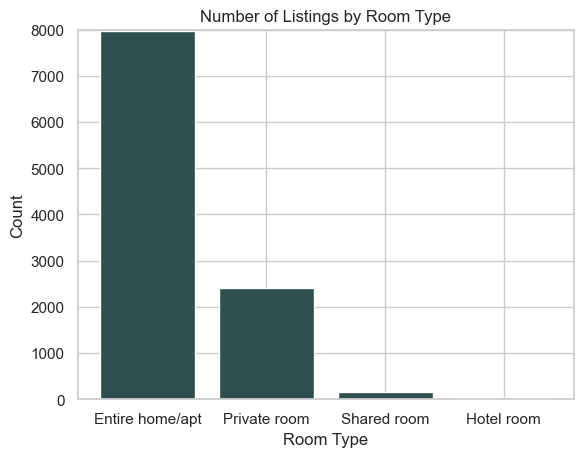

In [ ]:
room_type_list = listings_df['room_type'].unique()
room_type_list

room_type_count = listings_df['room_type'].sort_index().value_counts()
print(room_type_count)

figure = plt.figure()
ax1 = figure.add_subplot(1,1,1)
ax1.bar(room_type_count.index, room_type_count, color=THEME)
ax1.set_xlabel("Room Type")
ax1.set_ylabel("Count")
ax1.set_title("Number of Listings by Room Type")
ax1.set_ylim(0,8000)
ax1.yaxis.grid( visible=True, which="major")
ax1.set_axisbelow(True)


Of the ~10,500 listings, almost 8000 were 'Entire home/apt', followed by 'Private room', then very few for 'Shared room' and 'Hotel room'.

## Accomodates

This describes the maximum capacity for the unit.

First, we'll look at the distribution.


+-------------+-----------------+
| Accomodates | Num of Listings |
+-------------+-----------------+
|      0      |        5        |
|      1      |      1007       |
|      2      |      3319       |
|      3      |      1487       |
|      4      |      2262       |
|      5      |       721       |
|      6      |       899       |
|      7      |       163       |
|      8      |       348       |
|      9      |       39        |
|     10      |       129       |
|     11      |       16        |
|     12      |       81        |
|     13      |       12        |
|     14      |       16        |
|     15      |        7        |
|     16      |       49        |
+-------------+-----------------+


Text(0.5, 1.0, 'Accomodates distribution')

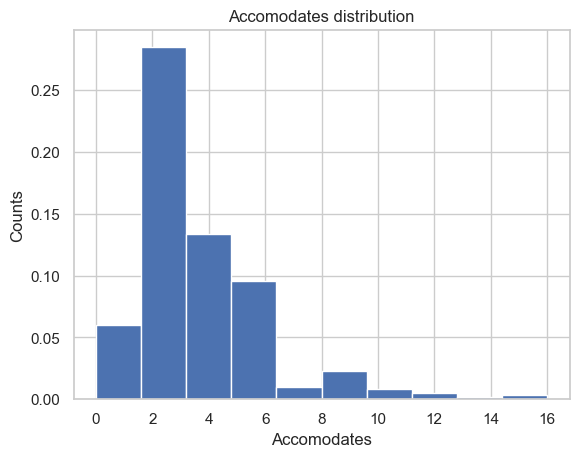

In [ ]:
accommodates_count = listings_df['accommodates'].value_counts().sort_index()
accommodates_count = pd.DataFrame(accommodates_count)
print(tabulate(accommodates_count, headers=['Accomodates', 'Num of Listings'], tablefmt='pretty'))


figure = plt.figure()
ax1 = figure.add_subplot(1,1,1)
ax1.hist(listings_df['accommodates'],density=True)
ax1.set_xlabel('Accomodates')
ax1.set_ylabel('Counts')
ax1.set_title('Accomodates distribution')

More than a quarter of the listings are from the two to four range. There's an oddity where the a property accommodates 0.

In [ ]:
listings_df[listings_df.accommodates == 0]

property_type   room_type  accommodates bathrooms  \
3151          Room in hostel  Hotel room             0      None   
3275          Room in hostel  Hotel room             0      None   
3592  Room in boutique hotel  Hotel room             0      None   
6650  Room in boutique hotel  Hotel room             0      None   
9909  Room in boutique hotel  Hotel room             0      None   

     bathrooms_text  bedrooms  beds  \
3151           None       NaN   NaN   
3275           None       NaN   NaN   
3592           None       NaN   NaN   
6650           None       NaN   NaN   
9909           None       NaN   NaN   

                                              amenities  price  
3151  ["Long term stays allowed", "Smoke alarm", "Fi...    0.0  
3275  ["Long term stays allowed", "Dryer", "Luggage ...    0.0  
3592  ["43\" HDTV with Chromecast", "Long term stays...    0.0  
6650  ["Cooked-to-order breakfast available \u2014 $...    0.0  
9909  ["Heating", "Concierge", "Toiletries", "Fire e...    0.0

Looking at these listings, if accommodates is zero, there is no further information about the listing- The number of bathrooms, bedrooms, and beds are all blank, and the price is 0. This is unreliable, and cannot be used in prediction.

This condition can be used to filter out data that cannot be used in a model.

## Bathrooms 

This is a text type variable.

__Problem__ This data shows up as blank in the source CSV data, so it will show up as a blank in our data warehouse.  

We may need to use the bathrooms_text to pull out this info.



## bathrooms_text

This includes
1. how many baths (counting half baths) are available to the renter
2. if the baths are 'shared' or not 

Both of these need to be pulled out in order for this to be of use.


In [ ]:
listings_df.bathrooms_text.unique()

array(['1 private bath', '2 shared baths', '1.5 baths', '3 shared baths',
       '1 shared bath', '1 bath', '2.5 baths', None, '1.5 shared baths',
       '2 baths', '4 baths', '3.5 baths', '4.5 baths', '2.5 shared baths',
       '8 shared baths', '6 baths', '3 baths', '5 baths', '0 baths',
       '0 shared baths', '7 baths', '5.5 baths', '5.5 shared baths',
       '4.5 shared baths', '3.5 shared baths', 'Half-bath',
       '5 shared baths', '15 baths', '4 shared baths', '6 shared baths',
       'Shared half-bath', '7.5 baths', 'Private half-bath',
       '11 shared baths', '11 baths', '6.5 baths', '50 shared baths'],
      dtype=object)

## Bedrooms
This is the number of bedrooms available to the renter, and is a numerical value.


+----------+-----------------+
| Bedrooms | Num of Listings |
+----------+-----------------+
|   1.0    |      6225       |
|   2.0    |      2089       |
|   3.0    |       822       |
|   4.0    |       324       |
|   5.0    |       90        |
|   6.0    |       34        |
|   7.0    |       10        |
|   8.0    |        1        |
|   9.0    |        3        |
|   11.0   |        1        |
|   15.0   |        1        |
+----------+-----------------+


Text(0.5, 1.0, 'Bedrooms distribution')

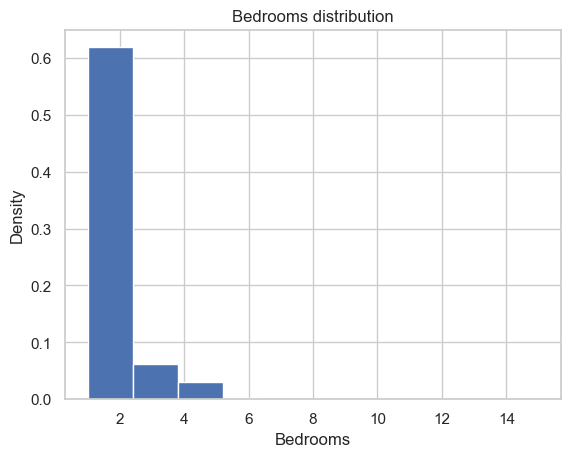

In [ ]:
item_count = listings_df['bedrooms'].value_counts().sort_index()
item_count = pd.DataFrame(item_count)
print(tabulate(item_count, headers=['Bedrooms', 'Num of Listings'], tablefmt='pretty'))

figure = plt.figure()
ax1 = figure.add_subplot(1,1,1)
ax1.hist(listings_df['bedrooms'],density=True)
ax1.set_xlabel('Bedrooms')
ax1.set_ylabel('Density')
ax1.set_title('Bedrooms distribution')

Roughly 80% of the listings are for 1-2 bedrooms.

## Amenities
This is a list of text items in a column, and could be expanded into individual columns with additional time.

The items seem fairly consistent.

In [ ]:
listings_df.amenities.head()

0    ["Dryer", "Smoke alarm", "Cooking basics", "In...
1    ["Smoke alarm", "Cooking basics", "Bed linens"...
2    ["Dryer", "Smoke alarm", "Single level home", ...
3    ["Dryer", "TV with standard cable", "Cooking b...
4    ["Smoke alarm", "Cooking basics", "Bed linens"...
Name: amenities, dtype: object

# Pairwise EDA - Target Variable: price <a id="pairwise_eda_price"></a>


## Neighborhood v. Price

Let's look at the pairwise analysis of `neighborhood` and `price`. I expect AirBnB price to track general rent cost of the D.C. areas. Neighborhoods with higher rent will have a higher nightly AirBnB price on average and the reverse would be true for areas with low rent. From general domain knowledge about Washington D.C., I know that the downtown area and the Northwest quadrant have higher rents on average than the Northeast and Southeast quadrant. Therefore I expect AirBnB nightly prices to be higher on average in the downtown area and the Northwest quadrant. 

One thing we will need to be mindful of in doing this analysis is the comparison of *counts* of AirBnB listings in each neighborhood cluster. Some clusters might have a high density of AirBnBs and others will have much fewer. Let's get the counts in tabular form as well as plotting them on the D.C. map. First, we must remove duplicate listings.

In [68]:
# Code from Lab 5 Solution
def describe_by_category(data, numeric, categorical, transpose=False):
    grouped = data.groupby(categorical)
    grouped_y = grouped[numeric].describe()
    if transpose:
        print(grouped_y.transpose())
    else:
        print(grouped_y)

In [202]:
# Code from Module 5
def classify_correlation(r):
    r = abs(r)
    if r < 0.16:
        return "very weak"
    if r < 0.29:
        return "weak"
    if r < 0.49:
        return "low"
    if r < 0.69:
        return "moderate"
    if r < 0.89:
        return "strong"
    return "very strong"

In [203]:
# Code from Module 5
def correlation(data, x, y):
    print("Correlation coefficients:")
    r = stats.pearsonr(data[x], data[y])[0]
    print( "r   =", r, f"({classify_correlation(r)})")
    rho = stats.spearmanr(data[x], data[y])[0]
    print( "rho =", rho, f"({classify_correlation(rho)})")

In [204]:
# Code from Module 5
def lowess_scatter(data, x, y, jitter=0.0, skip_lowess=False):

    if skip_lowess:
        fit = np.polyfit(data[x], data[y], 1)
        line_x = np.linspace(data[x].min(), data[x].max(), 10)
        line = np.poly1d(fit)
        line_y = list(map(line, line_x))
    else:
        lowess = sm.nonparametric.lowess(data[y], data[x], frac=.3)
        line_x = list(zip(*lowess))[0]
        line_y = list(zip(*lowess))[1]

    figure = plt.figure(figsize=(10, 6))

    axes = figure.add_subplot(1, 1, 1)

    xs = data[x]
    if jitter > 0.0:
        xs = data[x] + stats.norm.rvs( 0, 0.5, data[x].size)

    axes.scatter(xs, data[y], marker="o", color="DimGray", alpha=0.5)
    axes.plot(line_x, line_y, color="DarkRed")

    title = "Plot of {0} v. {1}".format(x, y)
    if not skip_lowess:
        title += " with LOWESS"
    axes.set_title(title)
    axes.set_xlabel(x)
    axes.set_ylabel(y)

    plt.show()
    plt.close()

In [209]:
# Code from Module 5
def restyle_boxplot(patch):
    ## change color and linewidth of the whiskers
    for whisker in patch['whiskers']:
        whisker.set(color='#000000', linewidth=1)

    ## change color and linewidth of the caps
    for cap in patch['caps']:
        cap.set(color='#000000', linewidth=1)

    ## change color and linewidth of the medians
    for median in patch['medians']:
        median.set(color='#000000', linewidth=2)

    ## change the style of fliers and their fill
    for flier in patch['fliers']:
        flier.set(marker='o', color='#000000', alpha=0.2)

    for box in patch["boxes"]:
        box.set( facecolor='#FFFFFF', alpha=0.5)

In [302]:
# Code from Module 5
def multiboxplot(data, numeric, categorical, skip_data_points=True):
    figure = plt.figure(figsize=(30, 6))

    axes = figure.add_subplot(1, 1, 1)

    grouped = data.groupby(categorical)
    labels = pd.unique(data[categorical].values)
    labels.sort()
    grouped_data = [grouped[numeric].get_group( k) for k in labels]
    patch = axes.boxplot( grouped_data, labels=labels, patch_artist=True, zorder=1)
    restyle_boxplot( patch)

    if not skip_data_points:
        for i, k in enumerate(labels):
            subdata = grouped[numeric].get_group( k)
            x = np.random.normal(i + 1, 0.01, size=len(subdata))
            axes.plot(x, subdata, 'o', alpha=0.4, color="DimGray", zorder=2)

    axes.set_xlabel(categorical)
    axes.set_xticklabels(labels, rotation=90, ha='right')
    axes.set_ylabel(numeric)
    axes.set_title("Distribution of {0} by {1}".format(numeric, categorical))

    plt.show()
    plt.close()

## `neighborhood` vs. `price` <a id="neighborhood_vs_price"></a>

In [63]:
latest_listings = con.execute("select * from latest_listings;").df()
latest_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10560 entries, 0 to 10559
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            10560 non-null  int64         
 1   listing_url                                   10560 non-null  object        
 2   scrape_id                                     10560 non-null  int64         
 3   last_scraped                                  10560 non-null  datetime64[ns]
 4   name                                          10559 non-null  object        
 5   description                                   10416 non-null  object        
 6   neighborhood_overview                         6559 non-null   object        
 7   picture_url                                   10560 non-null  object        
 8   host_id                                       10560 non-null  int3

In [65]:
latest_listings_gdf = gpd.GeoDataFrame(
    latest_listings, geometry=gpd.points_from_xy(latest_listings.longitude, latest_listings.latitude))

In [66]:
type(latest_listings_gdf.geometry)

geopandas.geoseries.GeoSeries

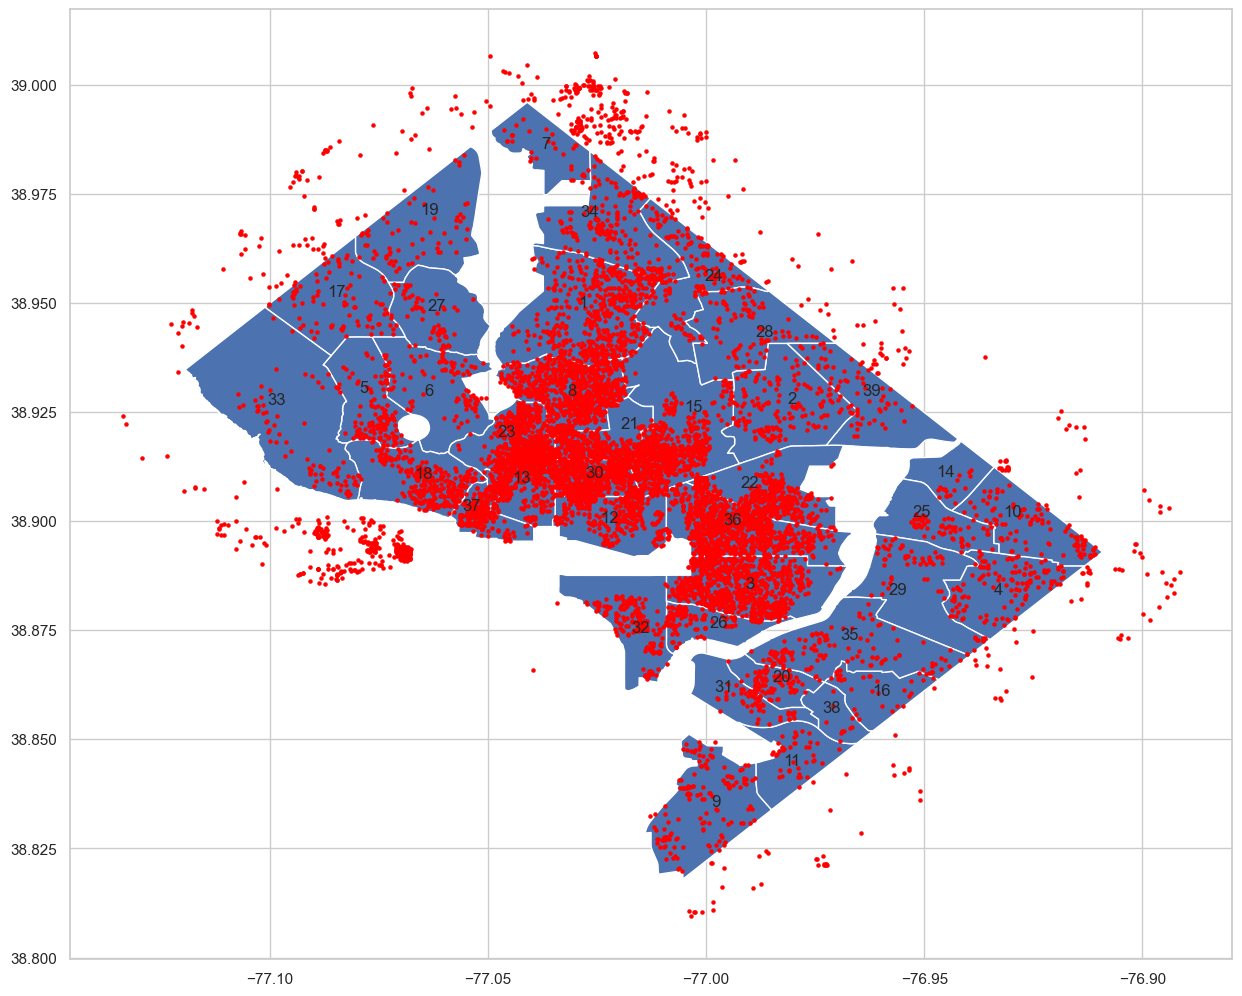

In [67]:
fig,ax = plt.subplots(figsize = (15,15))
base = neighborhoods_gpd.plot(ax=ax)
for idx, row in neighborhoods_gpd.iterrows():
    plt.annotate(row['alpha_index'], xy=row['rep_point'],
                 horizontalalignment='center')
    
latest_listings_gdf.geometry.plot(ax=base, marker='o', color='red', markersize=5);
    
plt.show()

It turns out there *are* listings that exist outside of the DC borders. There are listings in the Arlington are of Virginia and various parts of Maryland. The listing densities of each neighbrhood cluster vary immensely. The clusters close to the downtown/National Mall area have the highest density of AirBnBs. The density becomes smaller the further out you go from downtown. Let's look at the densities in tabular form:

In [74]:
describe_by_category(latest_listings, "price", "neighbourhood_cleansed", transpose=True)

neighbourhood_cleansed  Brightwood Park, Crestwood, Petworth  \
count                                             518.000000   
mean                                              142.733591   
std                                               161.809158   
min                                                20.000000   
25%                                                69.000000   
50%                                                95.000000   
75%                                               150.000000   
max                                              1500.000000   

neighbourhood_cleansed  Brookland, Brentwood, Langdon  \
count                                      152.000000   
mean                                       130.921053   
std                                        107.605087   
min                                         29.000000   
25%                                         70.000000   
50%                                         99.000000   
75%                     

This data is pretty hard to consume but we can see a stark difference in the `count` of AirBnBs per neighborhood cluster. Let's plot the average price for each neighborhood using box plots to get a better feel for the comparative price

In [77]:
latest_listings_below_1500 =  latest_listings[latest_listings.price < 1500]

In [82]:
latest_listings_below_500 =  latest_listings[latest_listings.price < 500]

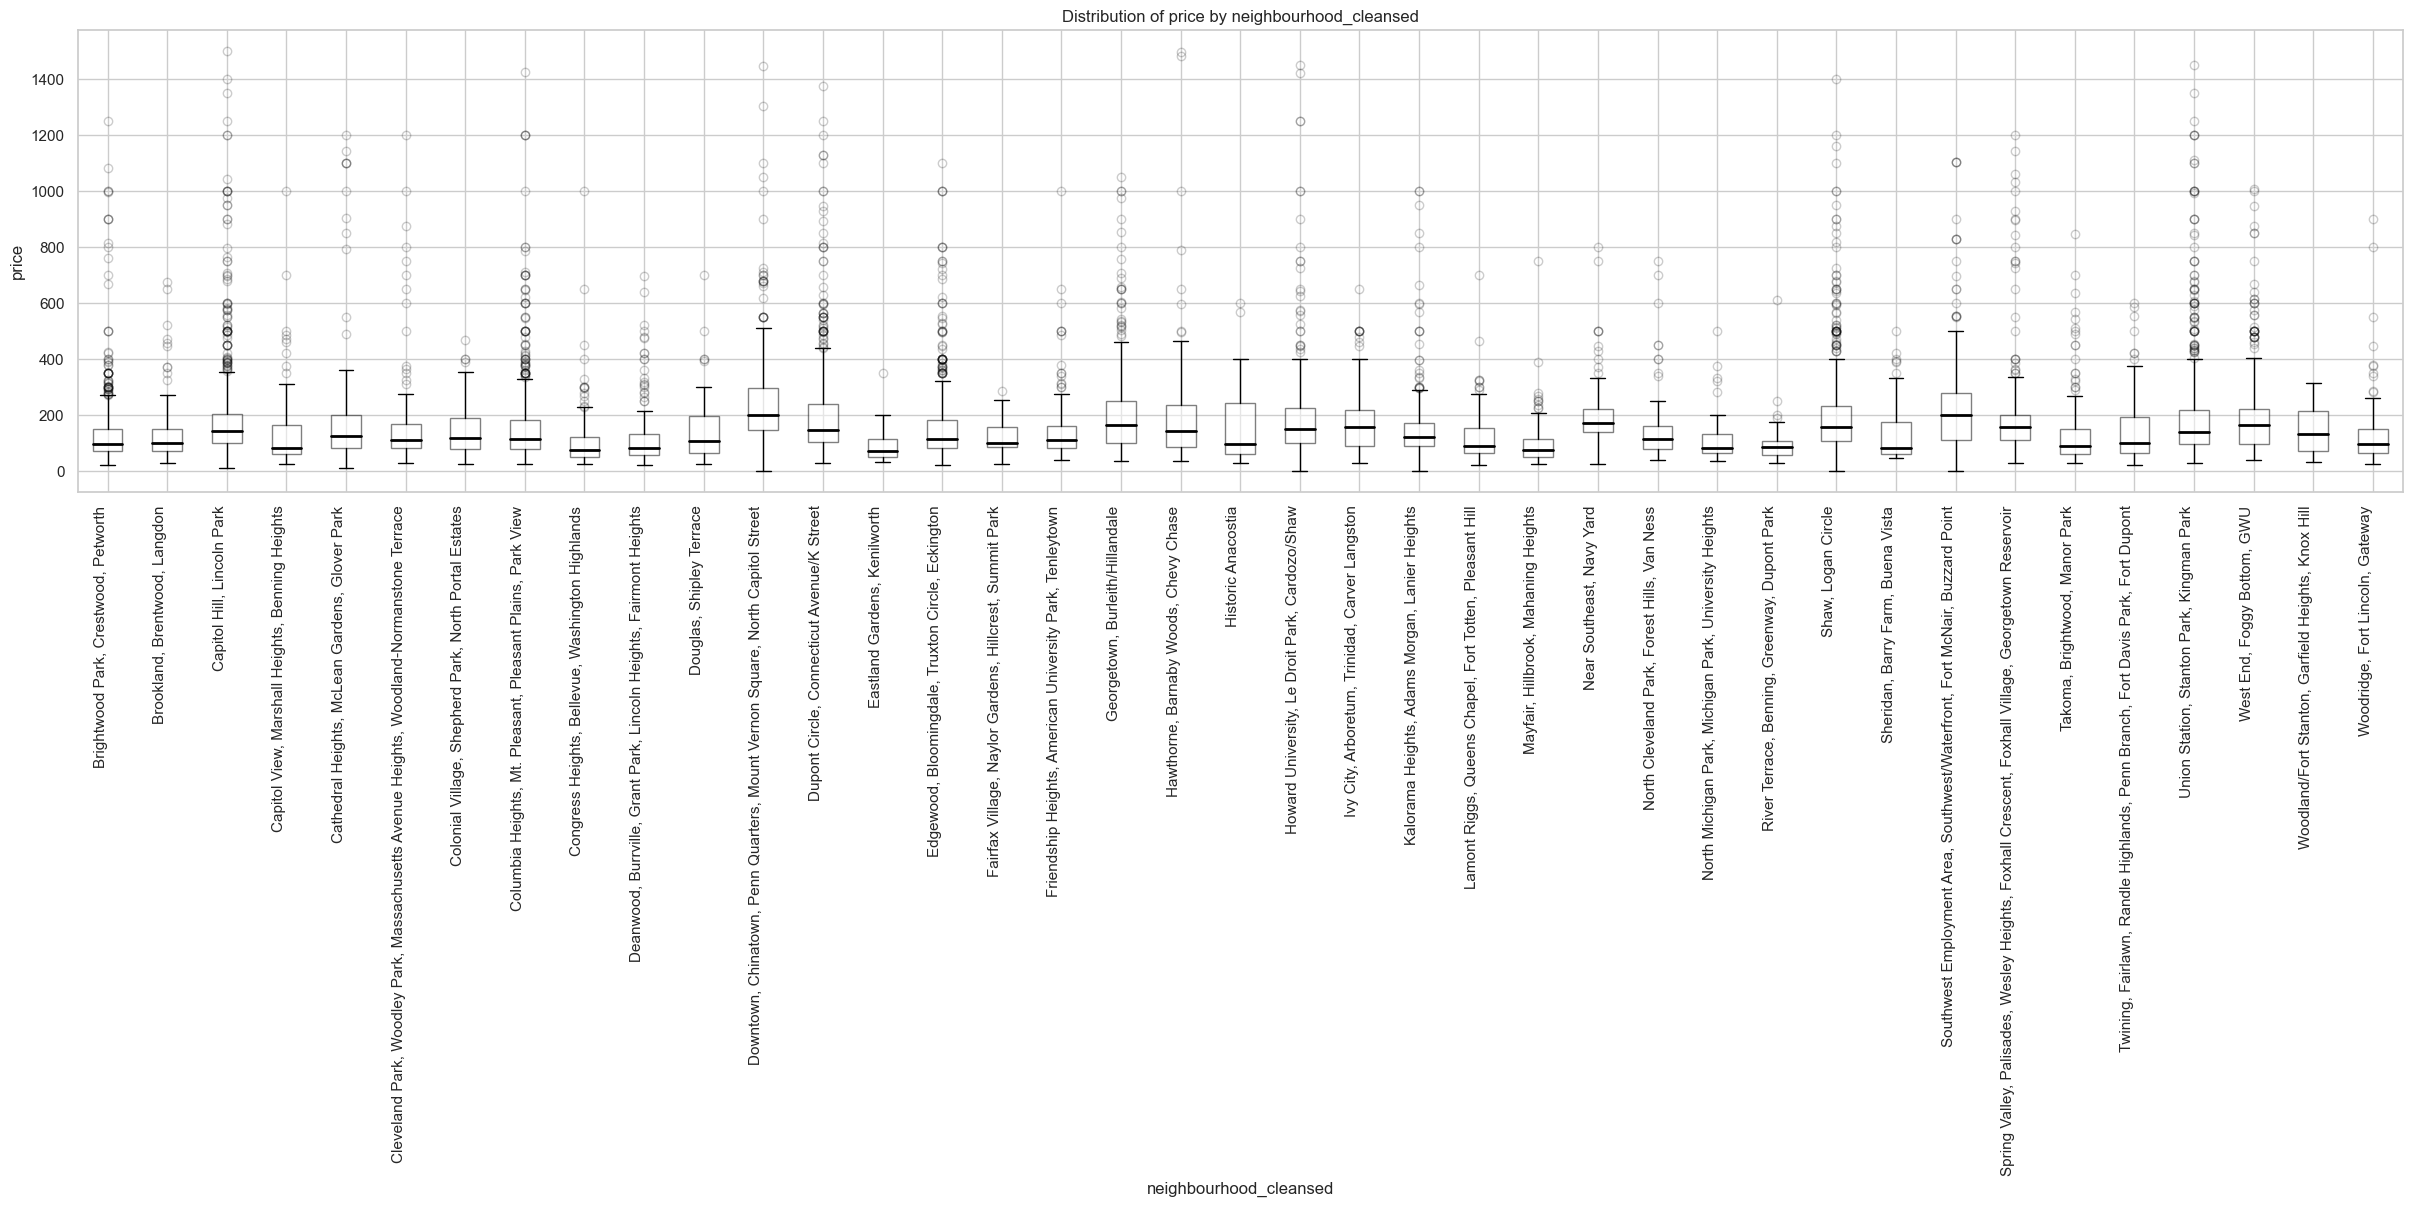

In [78]:
multiboxplot(latest_listings_below_1500, "price", "neighbourhood_cleansed")

### Price by neighborhood (only listings below 500 USD)

In [311]:
grouped = latest_listings_below_500.groupby("neighbourhood_cleansed")
labels = pd.unique(latest_listings_below_500["neighbourhood_cleansed"].values)
labels.sort()
grouped_data = [grouped["price"].get_group( k) for k in labels]
grouped_y = grouped['price'].describe()
avg_price_per_neighborhood = list(grouped_y.iloc[:, 1])
neighborhoods_gpd['avg_price'] = avg_price_per_neighborhood

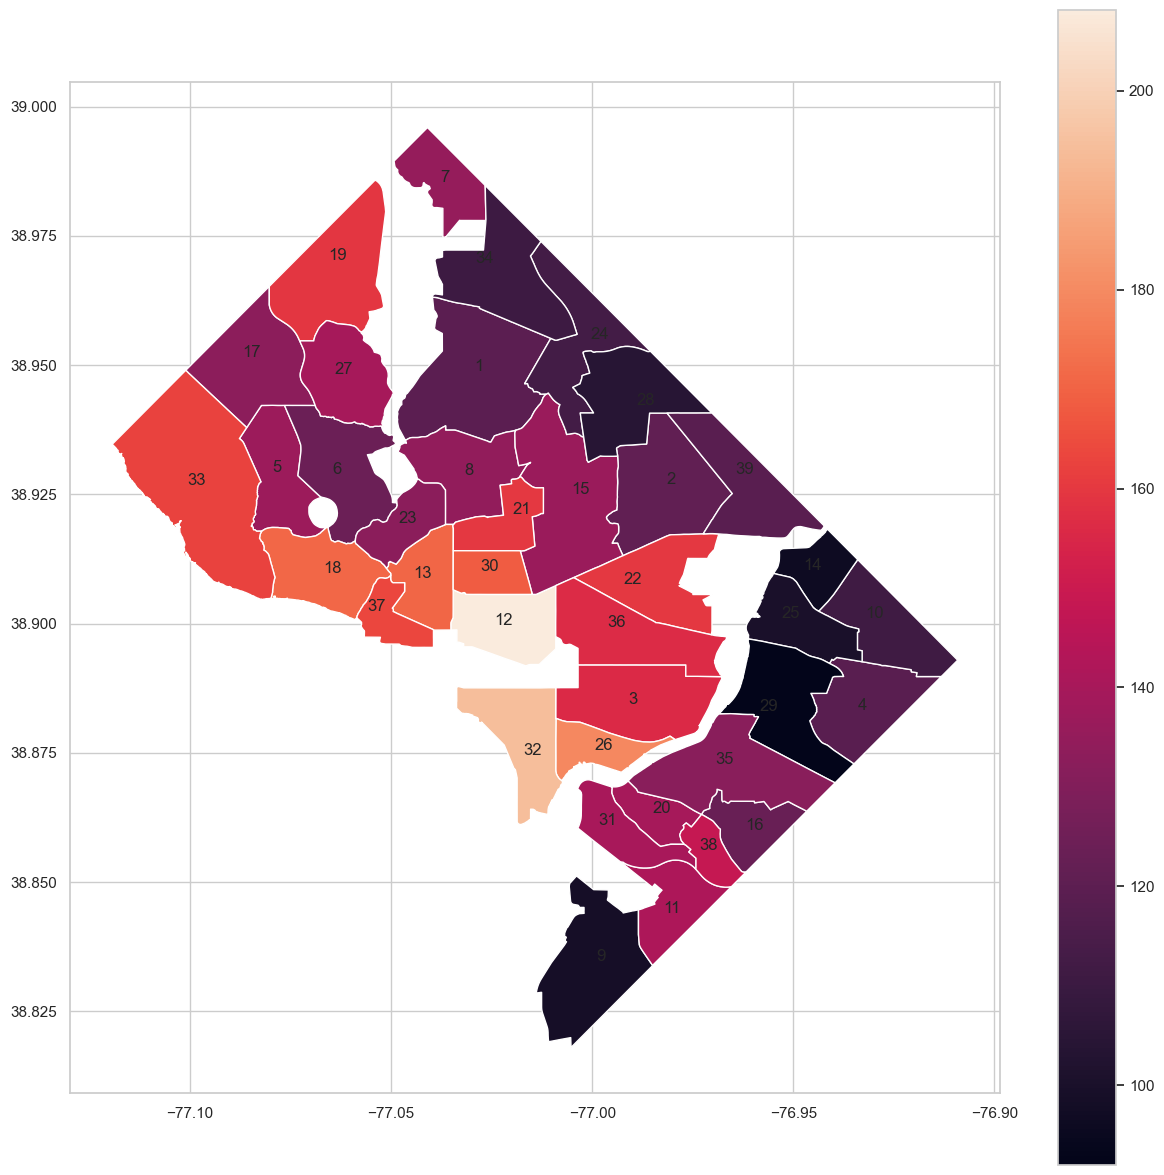

In [312]:
fig,ax = plt.subplots(figsize = (15,15))
base = neighborhoods_gpd.plot(ax=ax, column="avg_price",legend=True)
for idx, row in neighborhoods_gpd.iterrows():
    plt.annotate(row['alpha_index'], xy=row['rep_point'],
                 horizontalalignment='center')

### Price by neighborhood (only listings below 1500 USD)

In [313]:
grouped = latest_listings_below_1500.groupby("neighbourhood_cleansed")
labels = pd.unique(latest_listings_below_1500["neighbourhood_cleansed"].values)
labels.sort()
grouped_data = [grouped["price"].get_group( k) for k in labels]
grouped_y = grouped['price'].describe()
avg_price_per_neighborhood = list(grouped_y.iloc[:, 1])
neighborhoods_gpd['avg_price'] = avg_price_per_neighborhood

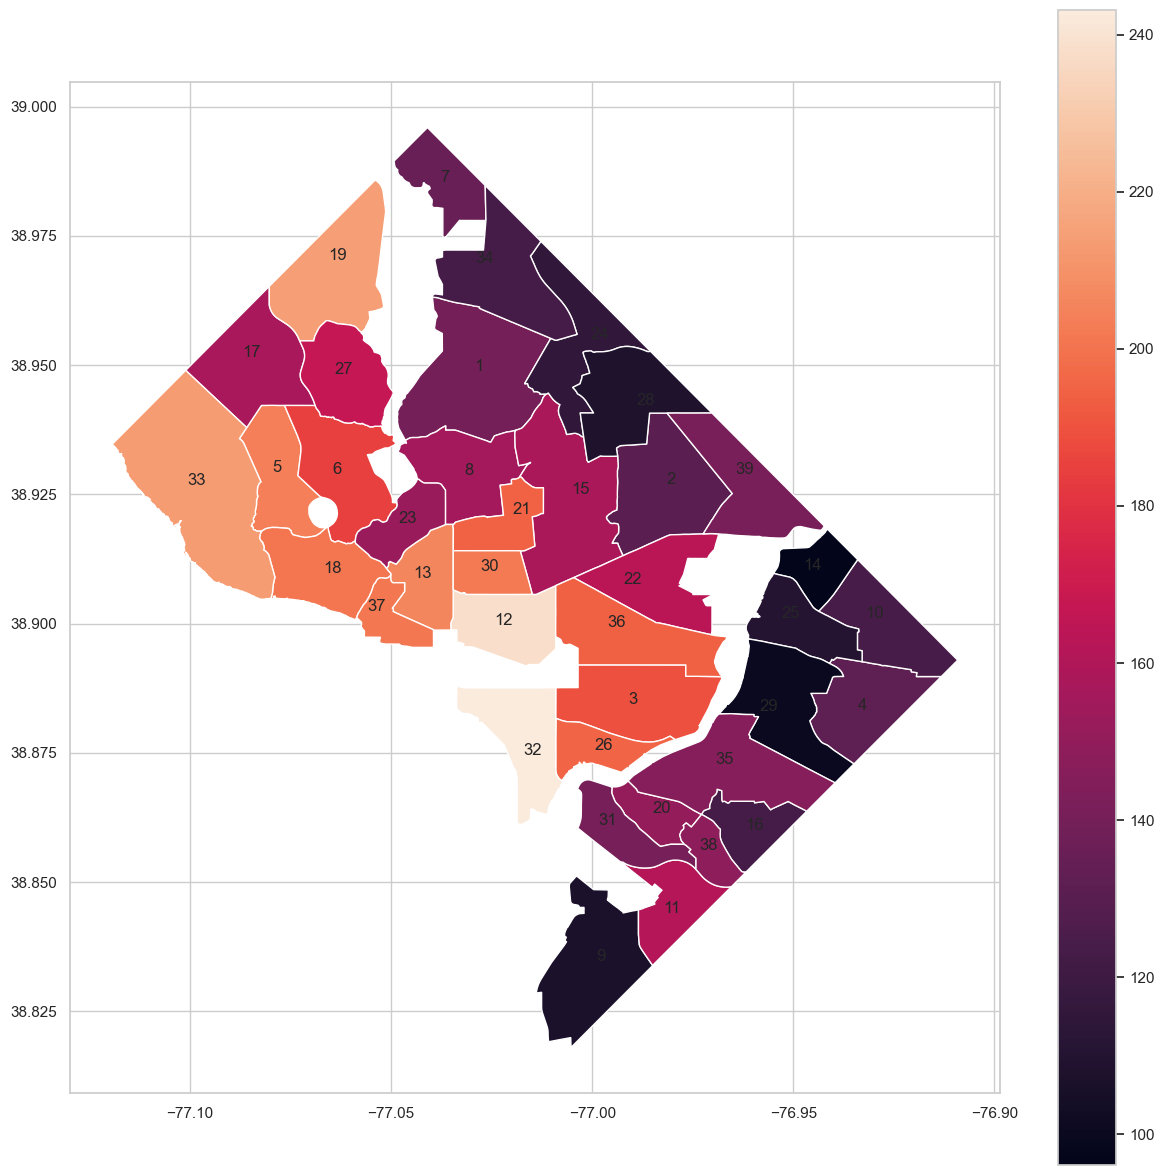

In [314]:
fig,ax = plt.subplots(figsize = (15,15))
base = neighborhoods_gpd.plot(ax=ax, column="avg_price",legend=True)
for idx, row in neighborhoods_gpd.iterrows():
    plt.annotate(row['alpha_index'], xy=row['rep_point'],
                 horizontalalignment='center')

### Price by neighborhood (all listings)

In [315]:
grouped = latest_listings.groupby("neighbourhood_cleansed")
labels = pd.unique(latest_listings["neighbourhood_cleansed"].values)
labels.sort()
grouped_data = [grouped["price"].get_group( k) for k in labels]
grouped_y = grouped['price'].describe()
avg_price_per_neighborhood = list(grouped_y.iloc[:, 1])
neighborhoods_gpd['avg_price'] = avg_price_per_neighborhood

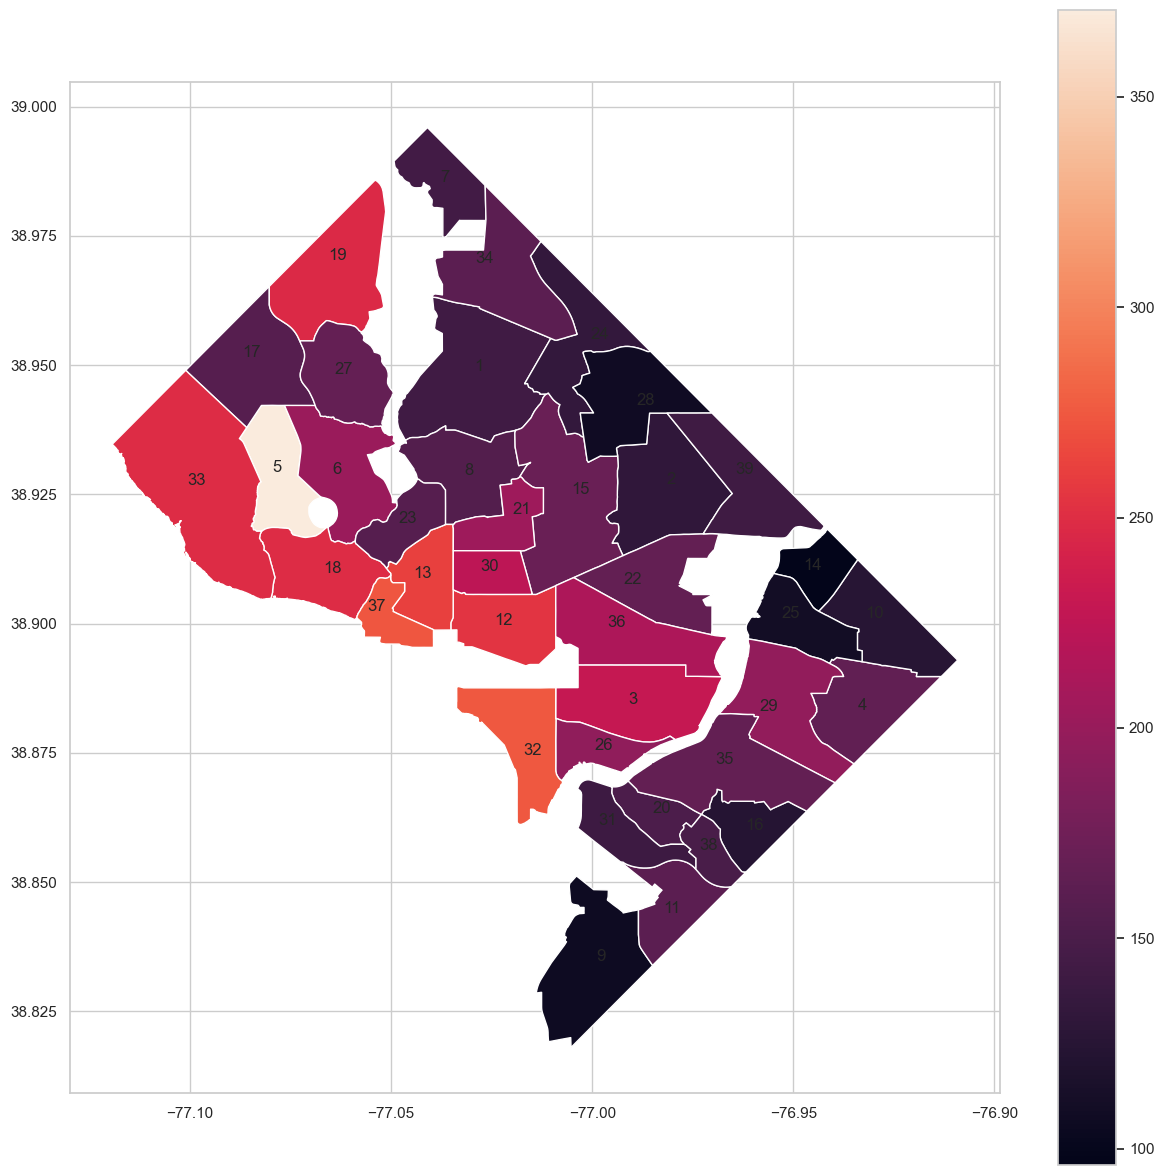

In [316]:
fig,ax = plt.subplots(figsize = (15,15))
base = neighborhoods_gpd.plot(ax=ax, column="avg_price",legend=True)
for idx, row in neighborhoods_gpd.iterrows():
    plt.annotate(row['alpha_index'], xy=row['rep_point'],
                 horizontalalignment='center')

TODO: Discuss

In [214]:
latest_listings["years_host"] = (res - latest_listings.host_since) / np.timedelta64(1,'Y')

In [217]:
latest_listings['price'].isnull().values.any()

False

## `host_since` vs `price` <a id="host_since_vs_price"></a>

In [224]:
latest_listings_non_null_host_since = latest_listings[latest_listings["years_host"].notnull()]

In [225]:
correlation(latest_listings_non_null_host_since, "price", "years_host")

Correlation coefficients:
r   = -0.0032471026963352473 (very weak)
rho = -0.08698568268122552 (very weak)


As I expected, the correlation is strong and negative.

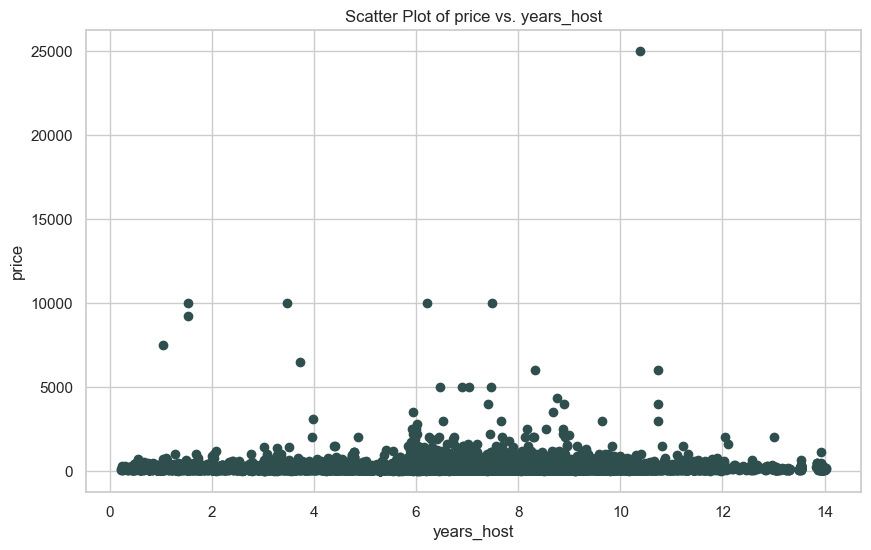

In [226]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_since.years_host, latest_listings_non_null_host_since.price, marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("years_host")
axes.set_title("Scatter Plot of price vs. years_host")

plt.show()
plt.close()

In [228]:
latest_listings_below_500["years_host"] = (res - latest_listings_below_500.host_since) / np.timedelta64(1,'Y')

In [229]:
latest_listings_non_null_host_since_below_500 = latest_listings_below_500[latest_listings_below_500["years_host"].notnull()]

In [230]:
correlation(latest_listings_non_null_host_since_below_500, "price", "years_host")

Correlation coefficients:
r   = -0.10565400632052657 (very weak)
rho = -0.11097828442186954 (very weak)


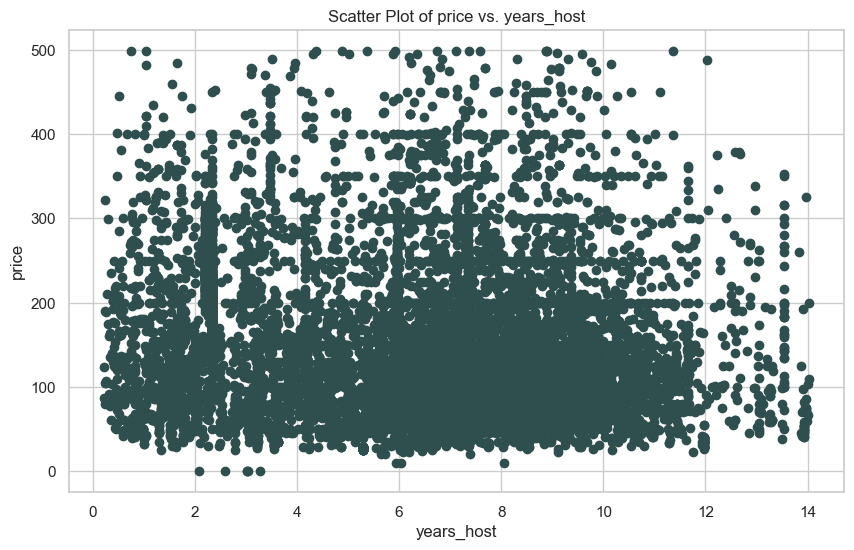

In [231]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_since_below_500.years_host, latest_listings_non_null_host_since_below_500.price, marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("years_host")
axes.set_title("Scatter Plot of price vs. years_host")

plt.show()
plt.close()

TODO: Discuss

## `host_location` vs `price` <a id="host_location_vs_price"></a>

This one won't work because the data is ambiguous in category. There are several categories meaning the same thing like "DC" and "Washington DC" or "United States" and "US" all being separate categories.

## `host_response_time` vs `price` <a id="host_response_time_vs_price"></a>

In [240]:
describe_by_category(latest_listings_below_500, "price", "host_response_time", transpose=True)

host_response_time          N/A  a few days or more  within a day  \
count               2641.000000          182.000000    641.000000   
mean                 137.946611          124.197802    134.978159   
std                   94.925205           82.010068     81.423830   
min                    0.000000           25.000000     10.000000   
25%                   75.000000           65.000000     77.000000   
50%                  105.000000          100.000000    110.000000   
75%                  174.000000          150.000000    170.000000   
max                  499.000000          485.000000    499.000000   

host_response_time  within a few hours  within an hour  
count                      1047.000000     5344.000000  
mean                        117.108883      162.850299  
std                          82.213391       88.979790  
min                          22.000000        0.000000  
25%                          57.000000       95.000000  
50%                          95.0000

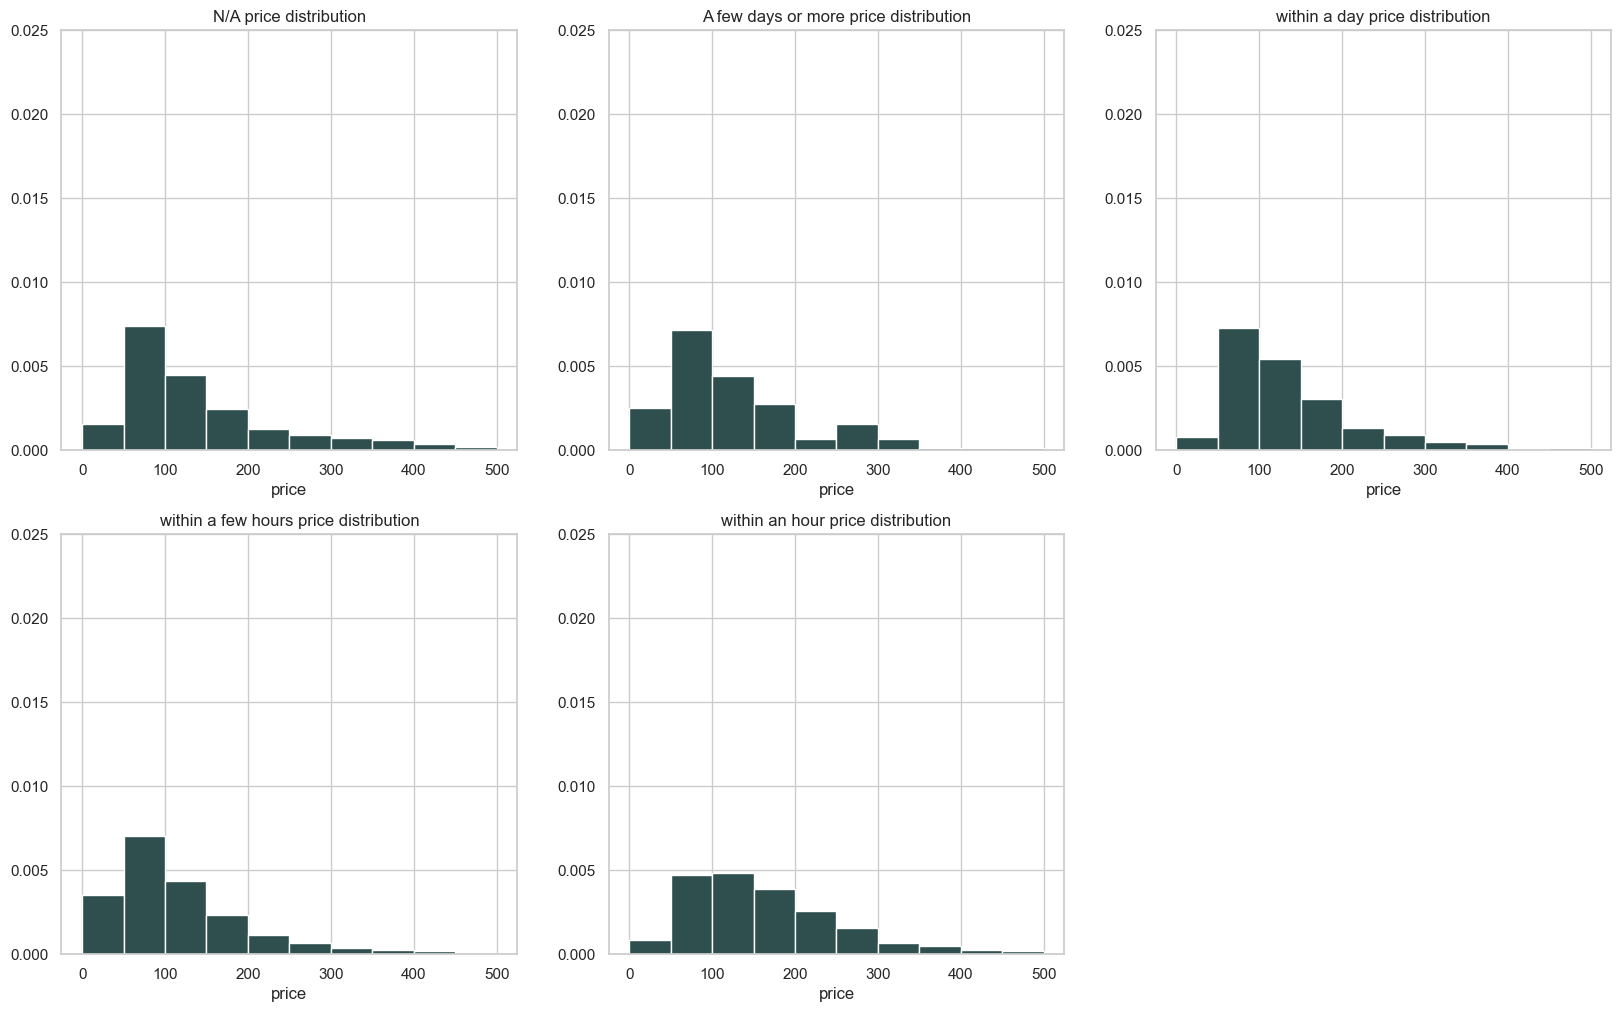

In [239]:
grouped = latest_listings_below_500.groupby("host_response_time")

figure = plt.figure(figsize=(20, 12))

axes = figure.add_subplot(2, 3, 1)
axes.hist(grouped["price"].get_group("N/A"),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.025))
axes.set_title("N/A price distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(2, 3, 2)
axes.hist(grouped["price"].get_group("a few days or more"),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.025))
axes.set_title("A few days or more price distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(2, 3, 3)
axes.hist(grouped["price"].get_group("within a day"),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.025))
axes.set_title("within a day price distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(2, 3, 4)
axes.hist(grouped["price"].get_group("within a few hours"),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.025))
axes.set_title("within a few hours price distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(2, 3, 5)
axes.hist(grouped["price"].get_group("within an hour"),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.025))
axes.set_title("within an hour price distribution")
axes.set_xlabel("price")

plt.show()
plt.close()

TODO: Discuss

## `host_response_rate` vs `price` <a id="host_respone_rate_vs_price"></a>

In [241]:
latest_listings_below_500['host_response_rate'] = latest_listings_below_500['host_response_rate'].replace('N/A',np.NaN)
latest_listings_below_500['host_response_rate'] = latest_listings_below_500['host_response_rate'].replace('%', '', regex=True).astype(float)

In [242]:
latest_listings_below_500['host_response_rate'].isnull().values.any()

True

In [243]:
latest_listings_non_null_host_response_rate_below_500 = latest_listings_below_500[latest_listings_below_500["host_response_rate"].notnull()]

In [244]:
correlation(latest_listings_non_null_host_response_rate_below_500, "price", "host_response_rate")

Correlation coefficients:
r   = 0.07771063276548656 (very weak)
rho = 0.11987951077842735 (very weak)


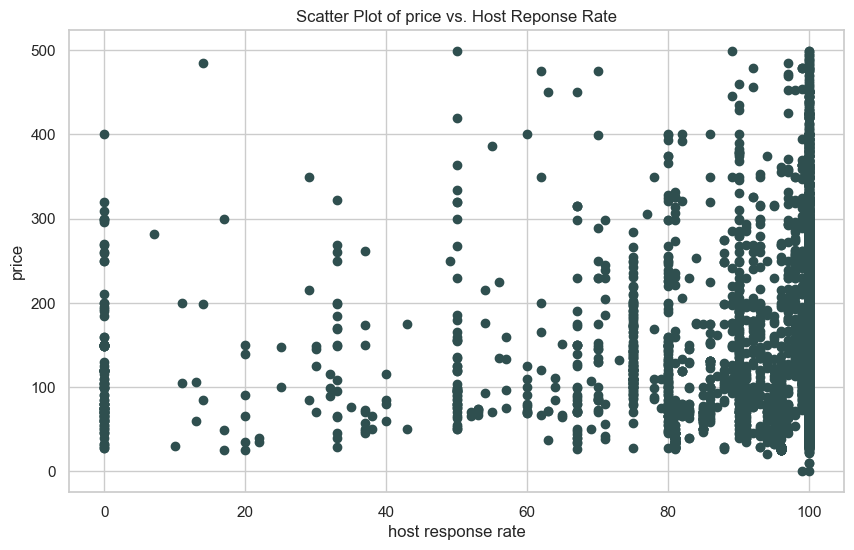

In [249]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_response_rate_below_500.host_response_rate, latest_listings_non_null_host_response_rate_below_500.price, marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("host response rate")
axes.set_title("Scatter Plot of price vs. Host Reponse Rate")

plt.show()
plt.close()

TODO: Discuss

## `host_acceptance_rate` vs `price` <a id="host_acceptance_rate_vs_price"></a>

In [250]:
latest_listings_below_500['host_acceptance_rate'] = latest_listings_below_500['host_acceptance_rate'].replace('N/A',np.NaN)
latest_listings_below_500['host_acceptance_rate'] = latest_listings_below_500['host_acceptance_rate'].replace('%', '', regex=True).astype(float)

In [251]:
latest_listings_below_500['host_response_rate'].isnull().values.any()

True

In [252]:
latest_listings_non_null_host_acceptance_rate_below_500 = latest_listings_below_500[latest_listings_below_500["host_acceptance_rate"].notnull()]

In [253]:
correlation(latest_listings_non_null_host_acceptance_rate_below_500, "price", "host_acceptance_rate")

Correlation coefficients:
r   = 0.14181600177900086 (very weak)
rho = 0.07371328158619253 (very weak)


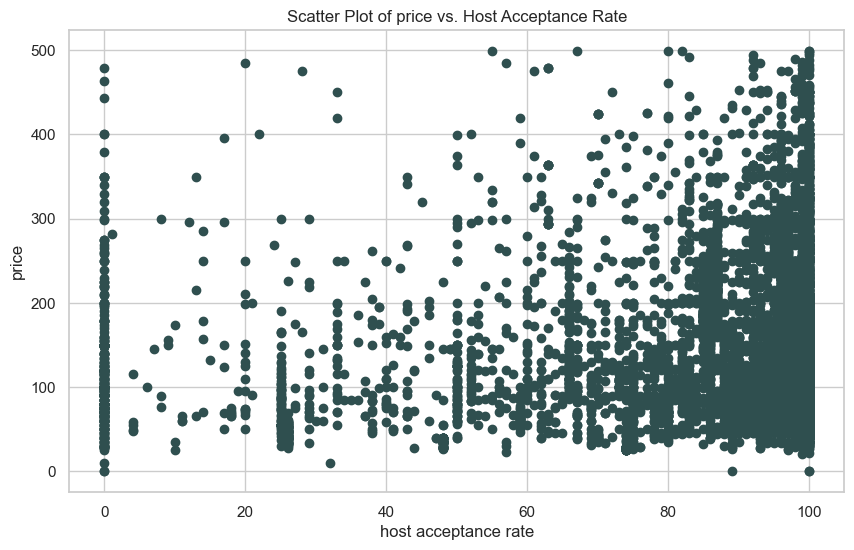

In [255]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_acceptance_rate_below_500.host_acceptance_rate, latest_listings_non_null_host_acceptance_rate_below_500.price, marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("host acceptance rate")
axes.set_title("Scatter Plot of price vs. Host Acceptance Rate")

plt.show()
plt.close()

TODO: Discuss

## `host_is_superhost` vs `price` <a id="host_is_superhost_vs_price"></a>

In [256]:
latest_listings_below_500['host_is_superhost'].isnull().values.any()

True

In [257]:
latest_listings_non_null_host_is_superhost_below_500 = latest_listings_below_500[latest_listings_below_500["host_is_superhost"].notnull()]

In [258]:
describe_by_category(latest_listings_below_500, "price", "host_is_superhost", transpose=True)

host_is_superhost        False         True
count              7509.000000  2499.000000
mean                149.125982   146.375350
std                  92.025995    84.974677
min                   0.000000    28.000000
25%                  80.000000    89.000000
50%                 125.000000   124.000000
75%                 200.000000   175.000000
max                 499.000000   499.000000


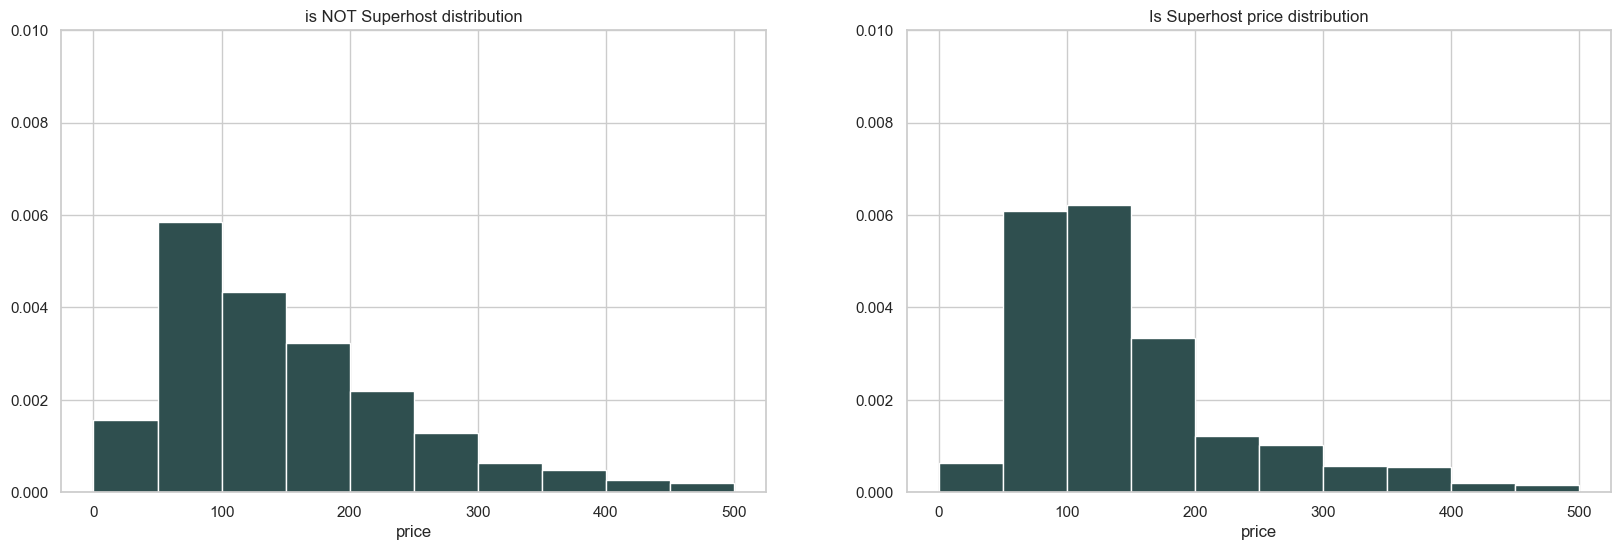

In [268]:
grouped = latest_listings_below_500.groupby("host_is_superhost")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1,2, 1)
axes.hist(grouped["price"].get_group(False),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.01))
axes.set_title("is NOT Superhost distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(1,2, 2)
axes.hist(grouped["price"].get_group(True),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.01))
axes.set_title("Is Superhost price distribution")
axes.set_xlabel("price")

plt.show()
plt.close()

TODO: Discuss

## `host_listings_count` vs `price` <a id="host_listings_count_vs_price"></a>

In [277]:
latest_listings_below_500['host_listings_count'].isnull().values.any()

True

In [278]:
latest_listings_non_null_host_listings_count_below_500 = latest_listings_below_500[latest_listings_below_500["host_listings_count"].notnull()]

In [279]:
correlation(latest_listings_non_null_host_listings_count_below_500 , "price", "host_listings_count")

Correlation coefficients:
r   = 0.14389749392647586 (very weak)
rho = 0.14816794097130107 (very weak)


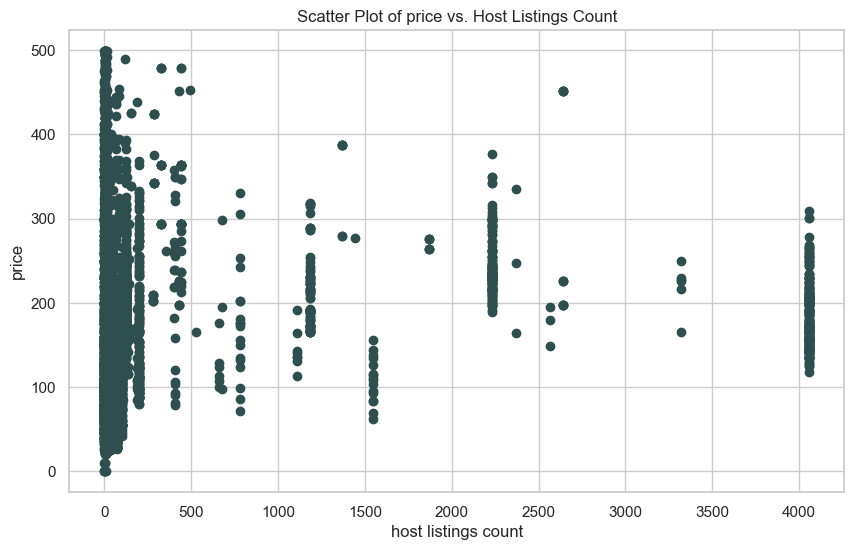

In [280]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_listings_count_below_500.host_listings_count, latest_listings_non_null_host_listings_count_below_500.price, marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("host listings count")
axes.set_title("Scatter Plot of price vs. Host Listings Count")

plt.show()
plt.close()

TODO: Discuss

In [281]:
latest_listings_below_500['host_listings_count_under_20'] = latest_listings_below_500.host_listings_count[latest_listings_below_500.host_listings_count < 20]

In [282]:
latest_listings_non_null_host_listings_under_20_count_below_500 = latest_listings_below_500[latest_listings_below_500["host_listings_count_under_20"].notnull()]

In [284]:
correlation(latest_listings_non_null_host_listings_under_20_count_below_500 , "price", "host_listings_count_under_20")

Correlation coefficients:
r   = 0.03678169211730996 (very weak)
rho = -0.010678801308667132 (very weak)


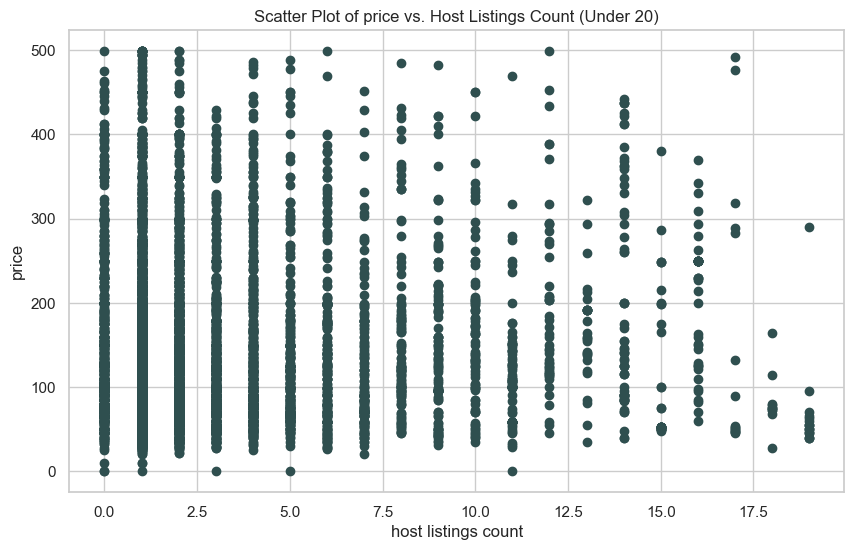

In [286]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_listings_under_20_count_below_500.host_listings_count_under_20, latest_listings_non_null_host_listings_under_20_count_below_500.price, marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("host listings count")
axes.set_title("Scatter Plot of price vs. Host Listings Count (Under 20)")

plt.show()
plt.close()

TODO: Discuss

## `host_total_listings_count` vs `price` <a id="host_total_listings_count_vs_price"></a>

UNUSED

## `host_verifications` vs `price` <a id="host_verifications_vs_price"></a>

In [145]:
latest_listings.host_verifications.value_counts(normalize=True)[:10]

['email', 'phone']                                                                                    0.550095
['email', 'phone', 'work_email']                                                                      0.136080
['phone']                                                                                             0.051705
['email', 'phone', 'reviews', 'kba']                                                                  0.024716
['email', 'phone', 'reviews', 'jumio', 'government_id']                                               0.016004
None                                                                                                  0.015341
['email', 'phone', 'reviews']                                                                         0.014583
['email', 'phone', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']    0.010511
['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'government_id']                      0.010133
[

## `host_has_profile_pic` vs `price` <a id="host_has_profile_pic_vs_price"></a>

In [287]:
describe_by_category(latest_listings_below_500, "price", "host_has_profile_pic", transpose=True)

host_has_profile_pic       False         True
count                  69.000000  9786.000000
mean                  142.130435   148.837114
std                    97.503380    90.770977
min                     0.000000     0.000000
25%                    80.000000    82.000000
50%                   107.000000   125.000000
75%                   161.000000   196.000000
max                   499.000000   499.000000


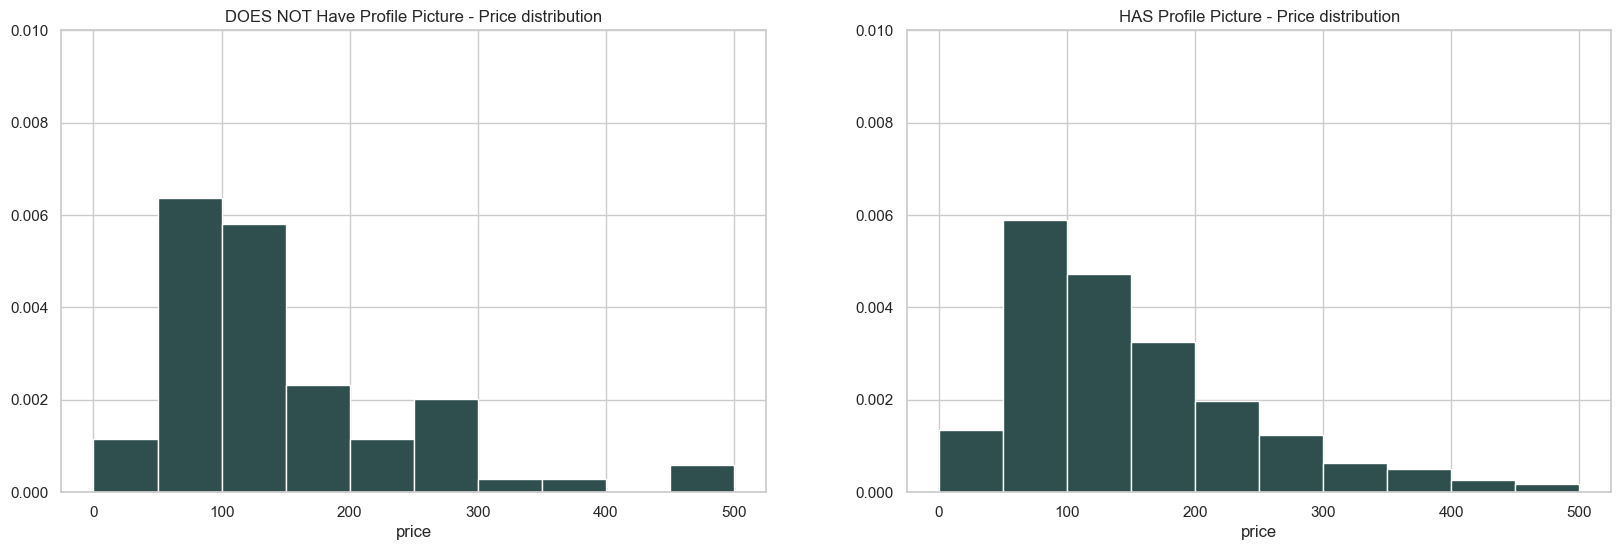

In [288]:
grouped = latest_listings_below_500.groupby("host_has_profile_pic")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1,2, 1)
axes.hist(grouped["price"].get_group(False),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.01))
axes.set_title("DOES NOT Have Profile Picture - Price distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(1,2, 2)
axes.hist(grouped["price"].get_group(True),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.01))
axes.set_title("HAS Profile Picture - Price distribution")
axes.set_xlabel("price")

plt.show()
plt.close()

TODO: Discuss

## `host_identity_verified` vs `price` <a id="host_identity_verified_vs_price"></a>

In [383]:
describe_by_category(latest_listings_below_500, "price", "host_identity_verified", transpose=True)

host_identity_verified        False         True
count                   1577.000000  8278.000000
mean                     141.034876   150.267577
std                       91.445010    90.626311
min                        0.000000     0.000000
25%                       78.000000    84.000000
50%                      111.000000   126.000000
75%                      179.000000   198.000000
max                      499.000000   499.000000


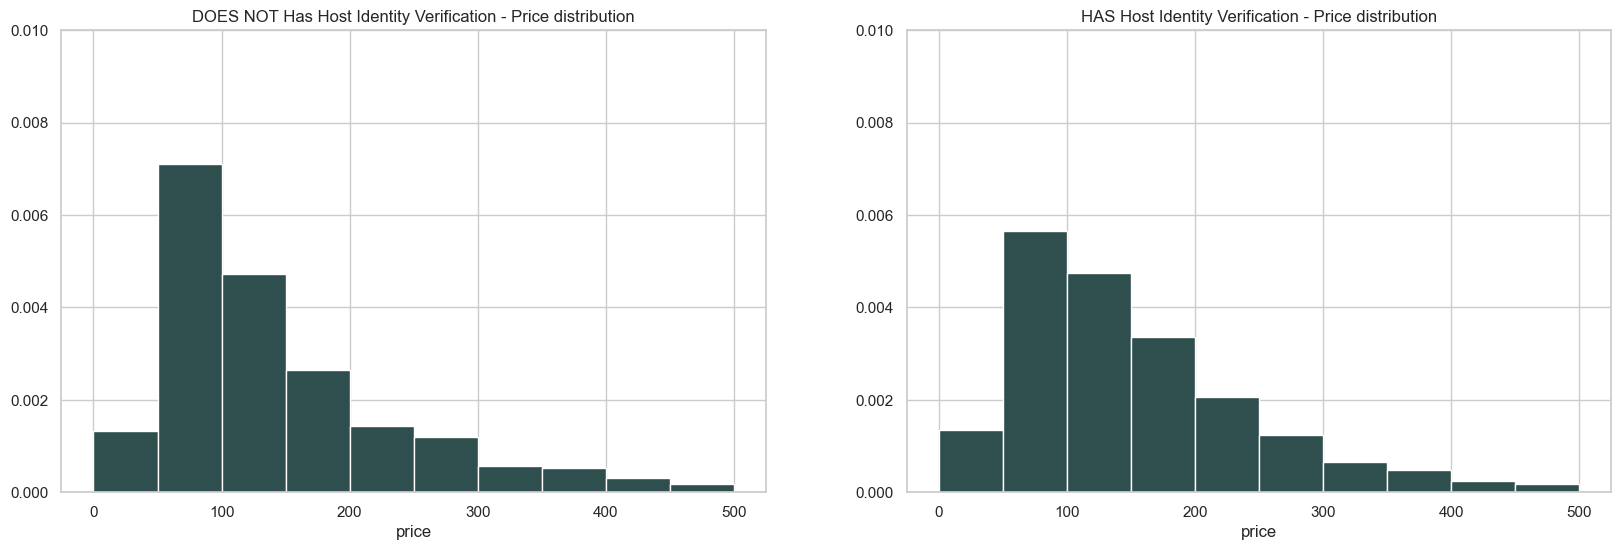

In [289]:
grouped = latest_listings_below_500.groupby("host_identity_verified")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1,2, 1)
axes.hist(grouped["price"].get_group(False),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.01))
axes.set_title("DOES NOT Has Host Identity Verification - Price distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(1,2, 2)
axes.hist(grouped["price"].get_group(True),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.01))
axes.set_title("HAS Host Identity Verification - Price distribution")
axes.set_xlabel("price")

plt.show()
plt.close()

TODO: Discuss

## Amenities v. Price
In this section, we'll look at the relationship between the room descriptors and the target variable, price.

## `host_has_profile_pic` vs `price` <a id="host_has_profile_pic_vs_price"></a>

## <a id="room_type_vs_price">`room_type` v. `price` </a>

We expect an "entire home/apt" to price higher than a "private" room or "hotel room", which would price higher than a "shared room."


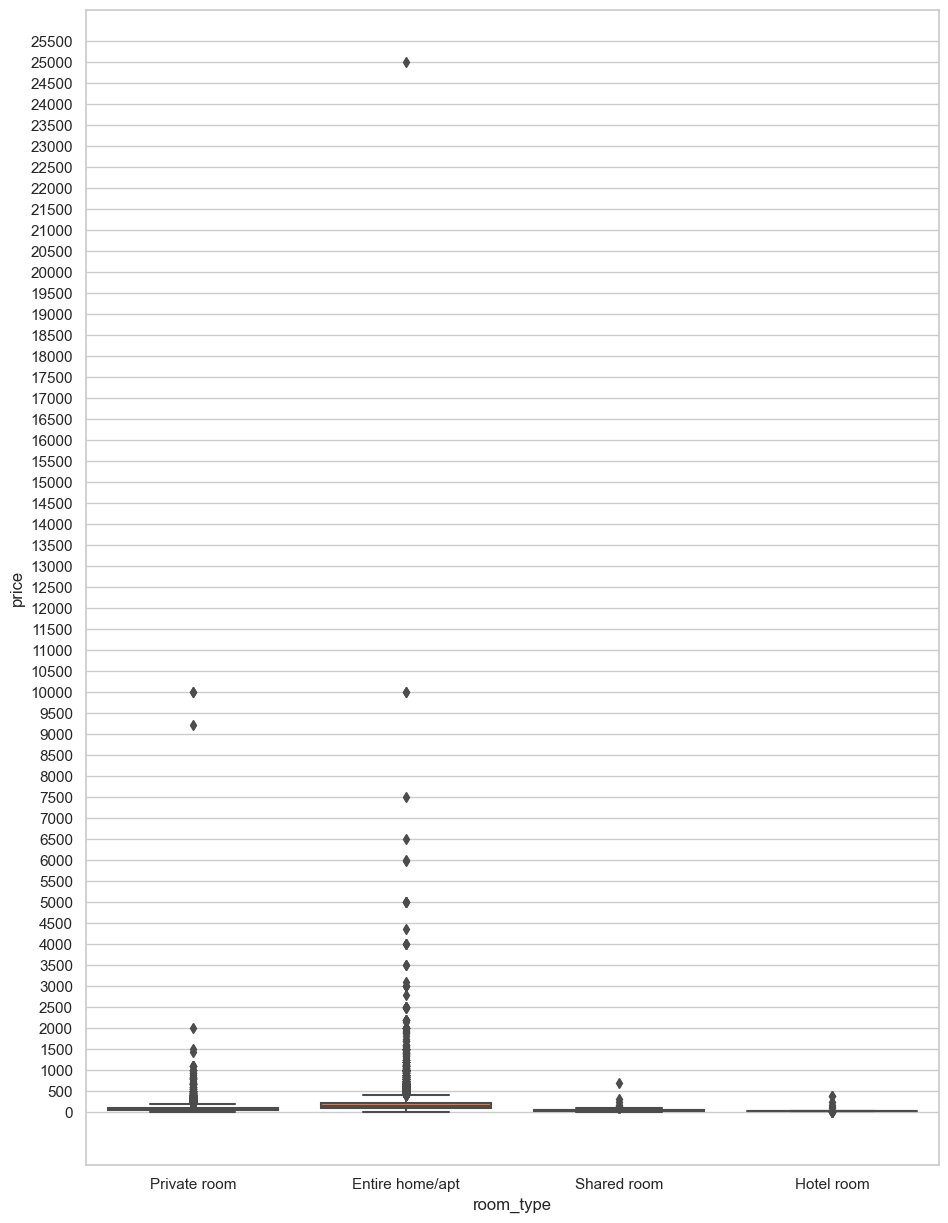

In [ ]:
max_plot_price = 26000
fig = plt.figure(figsize=(11,15))
ax1 = fig.add_subplot(1,1,1)
sns.boxplot(x = 'room_type', y='price', data = listings_df)
ax1.set_yticks(range(0,max_plot_price,500))
plt.show()

The extreme values, especially the $25,000 listing, makes it hard to see the distribution of prices per room type.

These extreme values are real prices, and I am hesitant to throw them out.

We'll zoom into the majority of data points below.

In [ ]:

def plot_box_cat(plot_df, x_name, y_name, y_lim, y_step):
    fig = plt.figure(figsize=(9,12))
    ax1 = fig.add_subplot(1,1,1)
    sns.boxplot(x = x_name, y=y_name, data = plot_df)
    ax1.set_yticks(range(0,y_lim,y_step))
    ax1.set(ylim=[0,y_lim])
    plt.show()

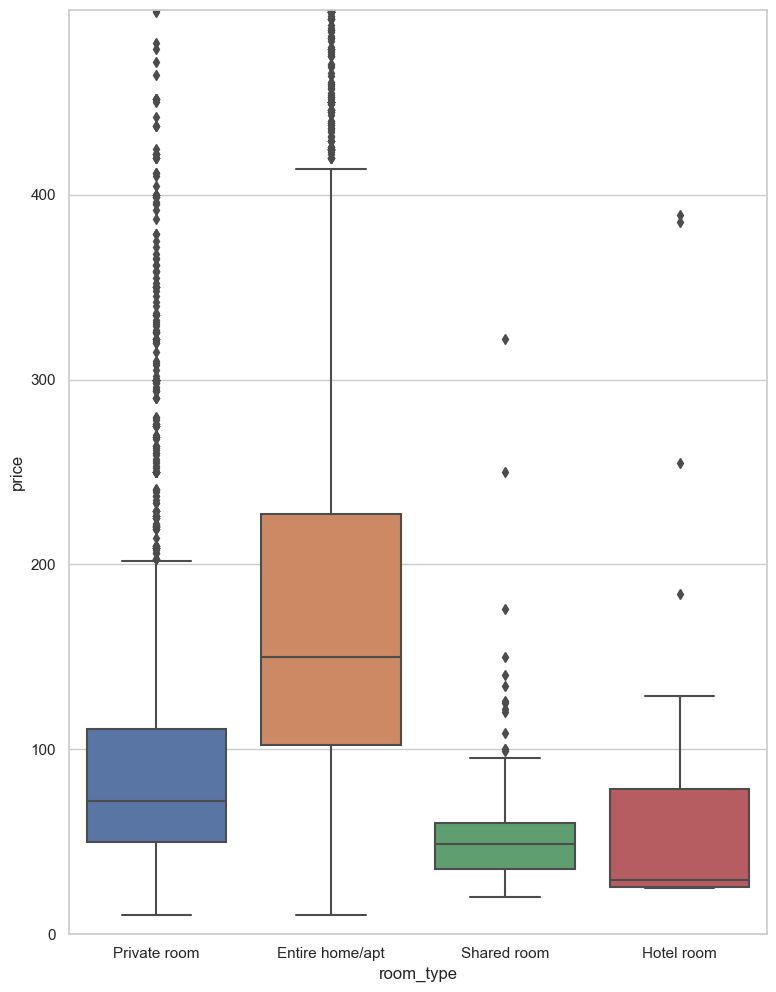

In [ ]:
max_plot_price = 500
#plot_df = listings_df[listings_df.price < max_plot_price]
plot_df = listings_df[listings_df.price > 0]
plot_box_cat(plot_df, 'room_type', 'price', max_plot_price, 100)



As expected, the Entire home/apt is the most pricey. This is followed by private room. The shared room median is above the hotel room median. I expected the hotel room to follow the private room trend, but it did not. With 28 of the total ~10,500 listings being hotel rooms, there may be some issues here. _todo explain_

## Accomodates

We expect the price to increase as the maximum accomodation for a listing increases.

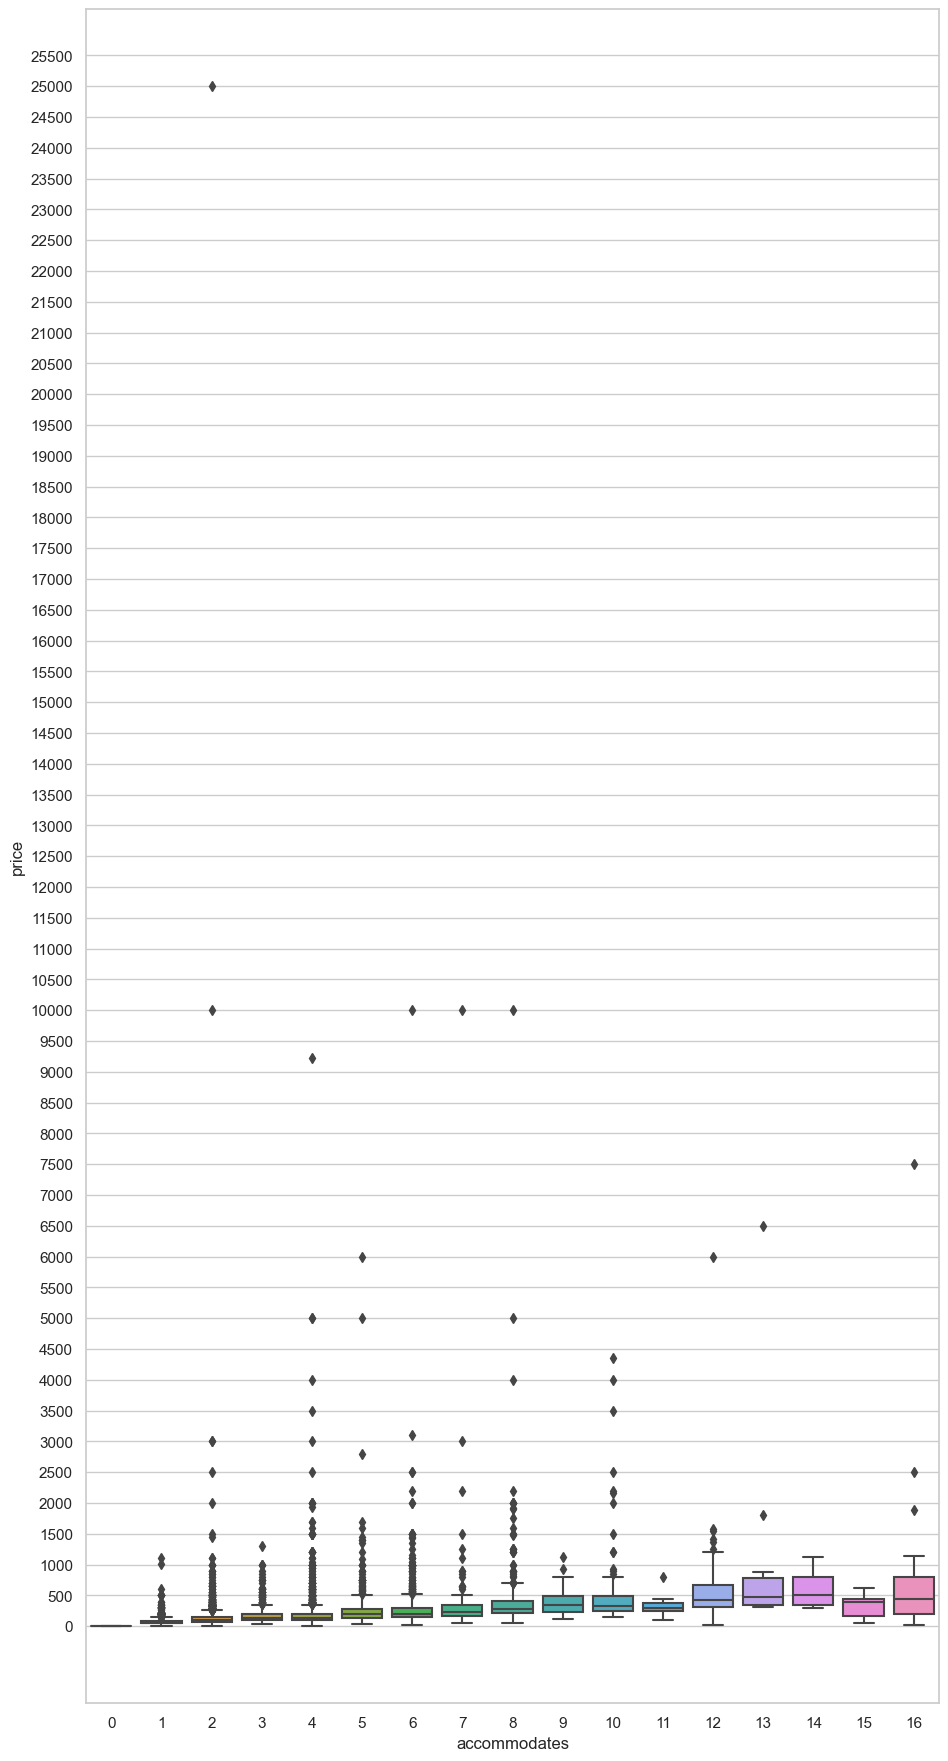

In [ ]:
fig = plt.figure(figsize=(11,22))
ax1 = fig.add_subplot(1,1,1)
sns.boxplot(x = 'accommodates', y='price', data = listings_df)
ax1.set_yticks(range(0,26000,500))
plt.show()

Once again, the extreme values make it difficult to see the majority of the distributions. We'll limit the view in the next plot:

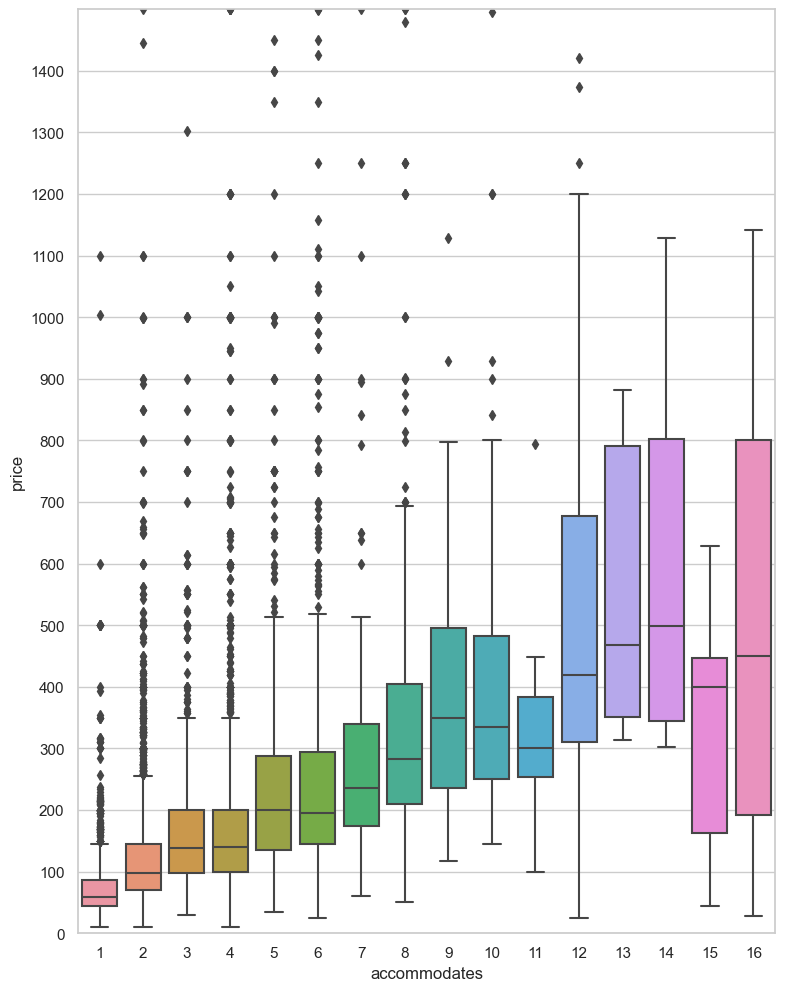

In [ ]:
max_plot_price = 1500
#plot_df = listings_df[listings_df.price < max_plot_price]
plot_df = listings_df[listings_df.price > 0]
plot_box_cat(plot_df, 'accommodates', 'price', max_plot_price, 100)


The mean price tends to increase as the maximum accommodations increase. There is a wider distribution of prices as maximum accomodations increases as well. 

There may be another variable that can explain the distribution.

## Bedrooms
As with accomodations, we expect the price to increase as the number of bedrooms increases.

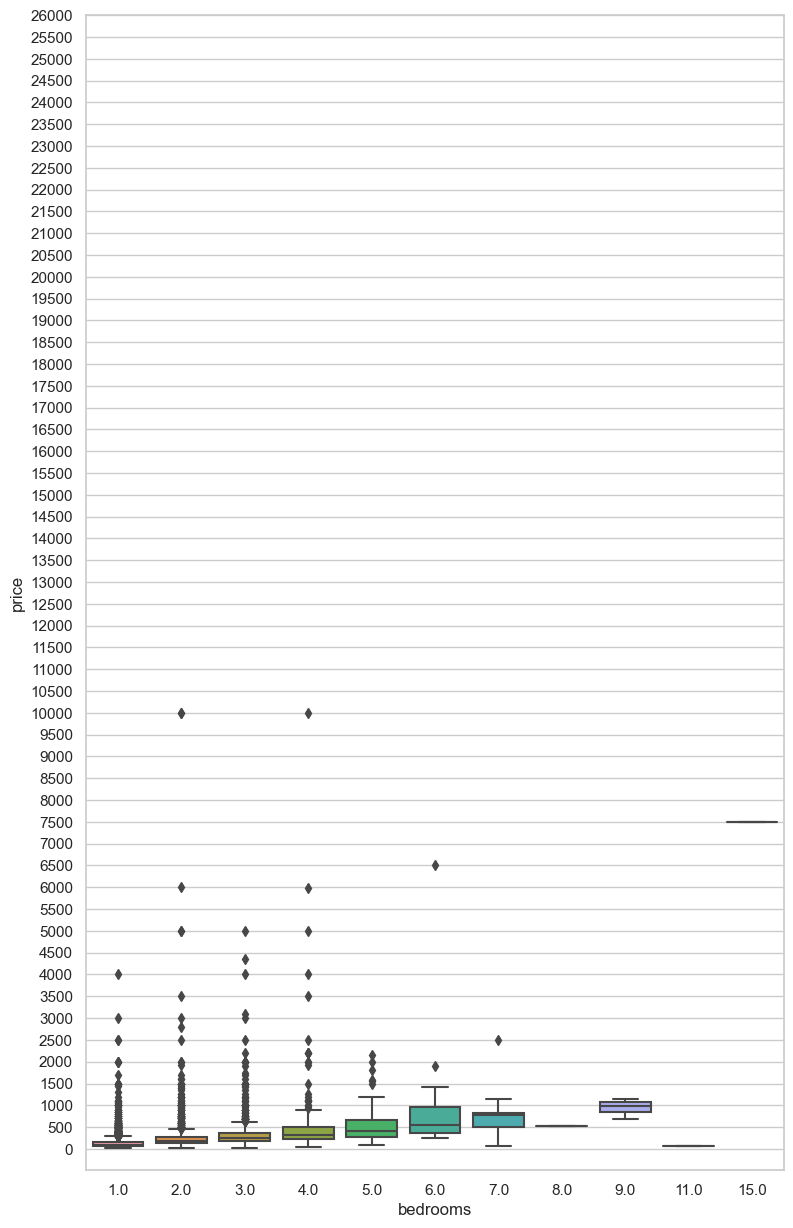

In [ ]:
fig = plt.figure(figsize=(9,15))
ax1 = fig.add_subplot(1,1,1)
sns.boxplot(x = 'bedrooms', y='price', data = listings_df)
ax1.set_yticks(range(0,26500,500))
plt.show()

We can generally see an increase in the overall distribution of prices as we go up in bedrooms until about 8 bedrooms. There are more outliers from 1-4 bedrooms.

It's hard to see the majority if the distributions, so we'll zoom in:

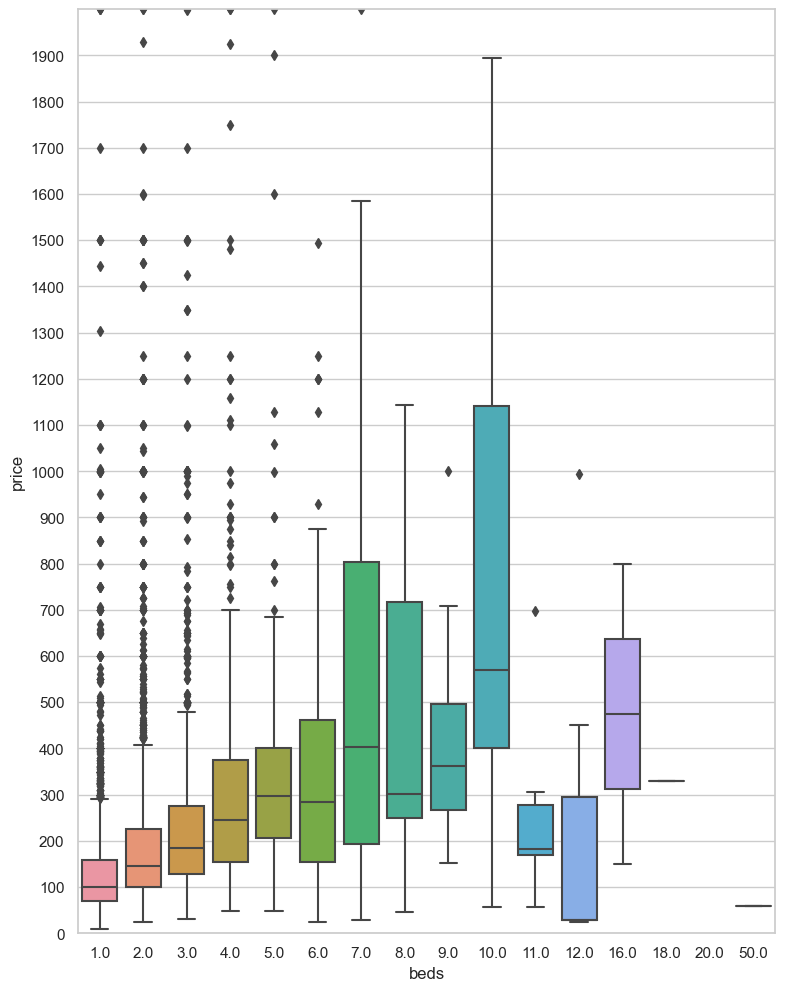

In [ ]:
max_plot_price = 2000
#plot_df = listings_df[listings_df.price < max_plot_price]
plot_df = listings_df[listings_df.price > 0]
plot_box_cat(plot_df, 'beds', 'price', max_plot_price, 100)


Rising averages and rising distributions as x increases.

# Exploration Conclusion

## Room descriptors
* property_type 
* room_type - whole house > room > shared
* accomodates ->+ price
* bathrooms ->+ price  (actuals TBD)
* bedrooms ->+ price
* beds->+ price
* amenities (TBD)  

  
The numeric values are all related: accommodates, bathrooms, bedrooms, beds. The more people you can fit in, the higher the price is generally. The function criteria for "accommodates" isn't listed, but it should be a function of the number of bedrooms and bathrooms. Overall, as these increase, so does price.  

## Filters
There were a number of rows that should be thrown away as errors because they cannot be true, and we have no way to correct them in the data. For the following criteria, we will drop the data:
* Price is 0
* Accommodates is 0


## To do if additional time:
* extract bathrooms info
* "private v. shared?"
* extract amenities info

## Questions
1. What accounts for the extreme values?
2. 



# Pairwise EDA - Target Variable: Rating <a id="pairwise_eda_rating"></a>

In [294]:
describe_by_category(latest_listings, "review_scores_rating", "neighbourhood_cleansed", transpose=True)

neighbourhood_cleansed  Brightwood Park, Crestwood, Petworth  \
count                                             416.000000   
mean                                                4.641611   
std                                                 0.674931   
min                                                 0.000000   
25%                                                 4.620000   
50%                                                 4.830000   
75%                                                 4.970000   
max                                                 5.000000   

neighbourhood_cleansed  Brookland, Brentwood, Langdon  \
count                                      130.000000   
mean                                         4.815154   
std                                          0.268103   
min                                          3.000000   
25%                                          4.750000   
50%                                          4.890000   
75%                     

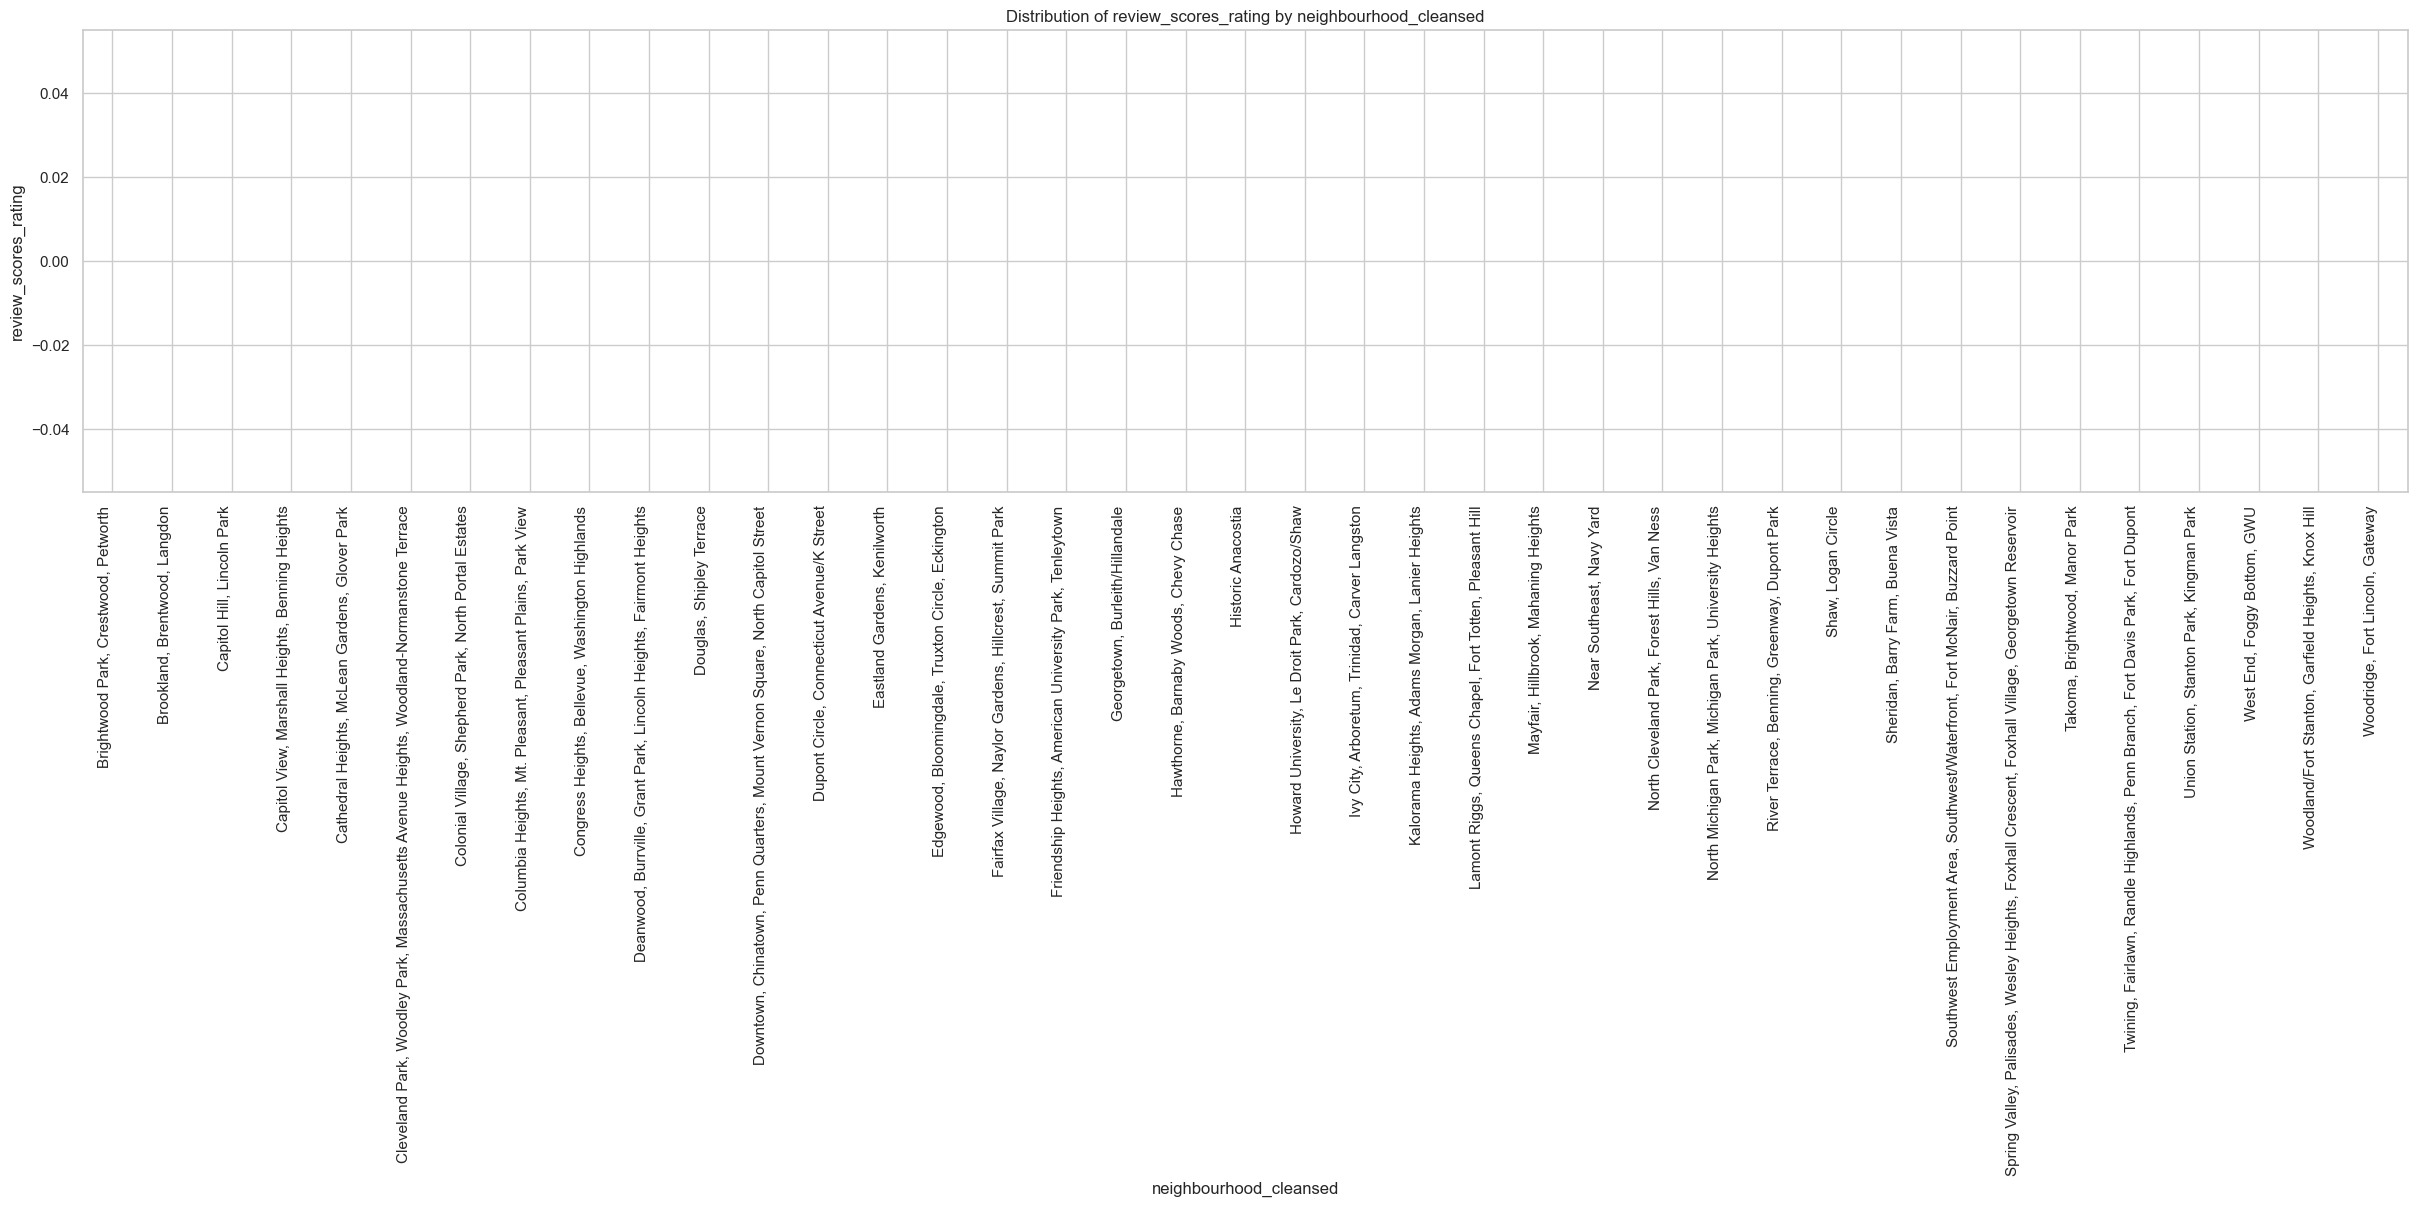

In [384]:
multiboxplot(latest_listings, "review_scores_rating", "neighbourhood_cleansed") # TODO data not showing up

TODO: Discuss

### 'neighborhood' vs 'rating' <a id="neighborhood_vs_rating"></a>

In [317]:
grouped = latest_listings.groupby("neighbourhood_cleansed")
labels = pd.unique(latest_listings_below_500["neighbourhood_cleansed"].values)
labels.sort()
grouped_data = [grouped["review_scores_rating"].get_group( k) for k in labels]
grouped_y = grouped['review_scores_rating'].describe()
avg_review_per_neighborhood = list(grouped_y.iloc[:, 1])
neighborhoods_gpd['avg_rating'] = avg_review_per_neighborhood

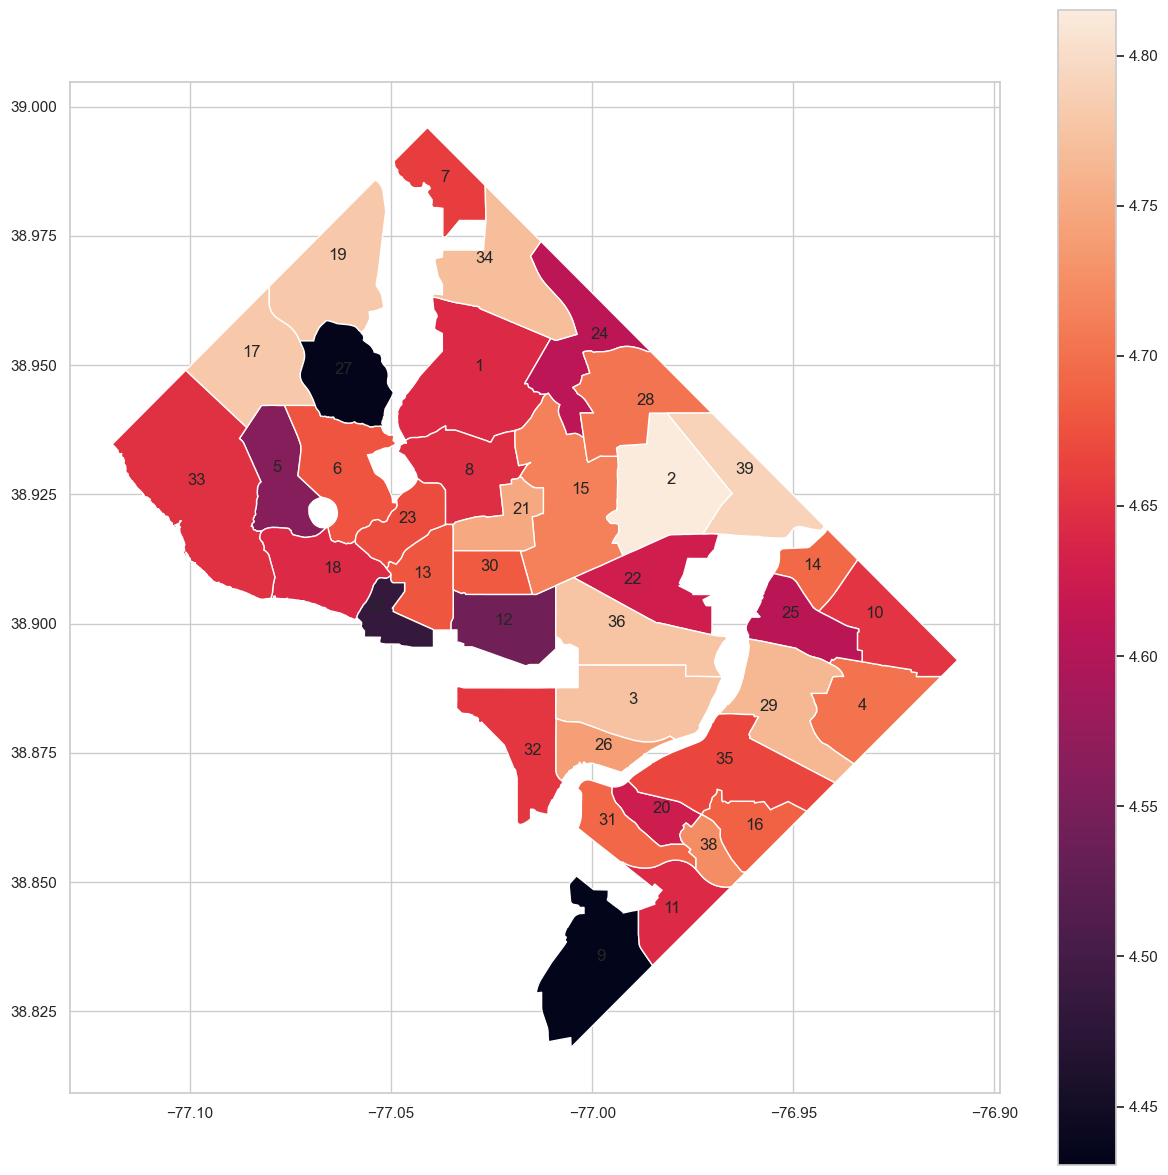

In [318]:
fig,ax = plt.subplots(figsize = (15,15))
base = neighborhoods_gpd.plot(ax=ax, column="avg_rating",legend=True)
for idx, row in neighborhoods_gpd.iterrows():
    plt.annotate(row['alpha_index'], xy=row['rep_point'],
                 horizontalalignment='center')

TODO: Discuss

In [319]:
latest_listings["years_host"] = (res - latest_listings.host_since) / np.timedelta64(1,'Y')

In [323]:
latest_listings['review_scores_rating'].isnull().values.any()

True

## `host_since` vs `review_scores_rating` <a id="host_since_vs_rating"></a>

In [329]:
latest_listings_non_null_host_since = latest_listings[(latest_listings["years_host"].notnull()) & (latest_listings["review_scores_rating"].notnull())]

In [330]:
correlation(latest_listings_non_null_host_since, "review_scores_rating", "years_host")

Correlation coefficients:
r   = 0.07123508406852085 (very weak)
rho = 0.0920592965742376 (very weak)


As I expected, the correlation is strong and negative.

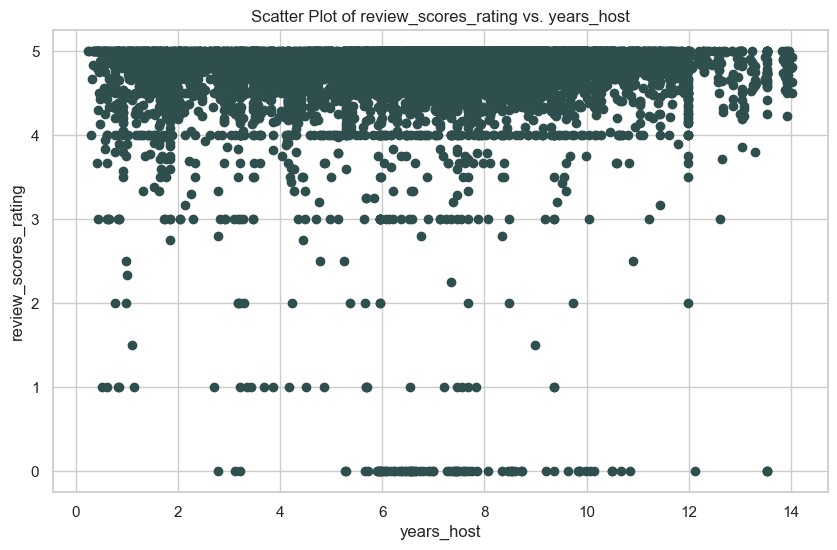

In [331]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_since.years_host, latest_listings_non_null_host_since.review_scores_rating, marker="o", color="darkslategray")

axes.set_ylabel("review_scores_rating")
axes.set_xlabel("years_host")
axes.set_title("Scatter Plot of review_scores_rating vs. years_host")

plt.show()
plt.close()

TODO: Discuss

## `host_location` vs `review_scores_rating` <a id="host_location_vs_rating"></a>
 
This one won't work because the data is ambiguous in category. There are several categories meaning the same thing like "DC" and "Washington DC" or "United States" and "US" all being separate categories.

## `host_response_time` vs `review_scores_rating` <a id="host_response_time_vs_rating"></a>

In [332]:
describe_by_category(latest_listings, "review_scores_rating", "host_response_time", transpose=True)

host_response_time          N/A  a few days or more  within a day  \
count               2010.000000          136.000000    477.000000   
mean                   4.604517            4.467941      4.665723   
std                    0.936675            1.035860      0.621095   
min                    0.000000            0.000000      0.000000   
25%                    4.672500            4.527500      4.630000   
50%                    4.880000            4.800000      4.840000   
75%                    5.000000            4.977500      5.000000   
max                    5.000000            5.000000      5.000000   

host_response_time  within a few hours  within an hour  
count                       830.000000     4156.000000  
mean                          4.691614        4.725416  
std                           0.534205        0.420487  
min                           0.000000        0.000000  
25%                           4.610000        4.670000  
50%                           4.8400

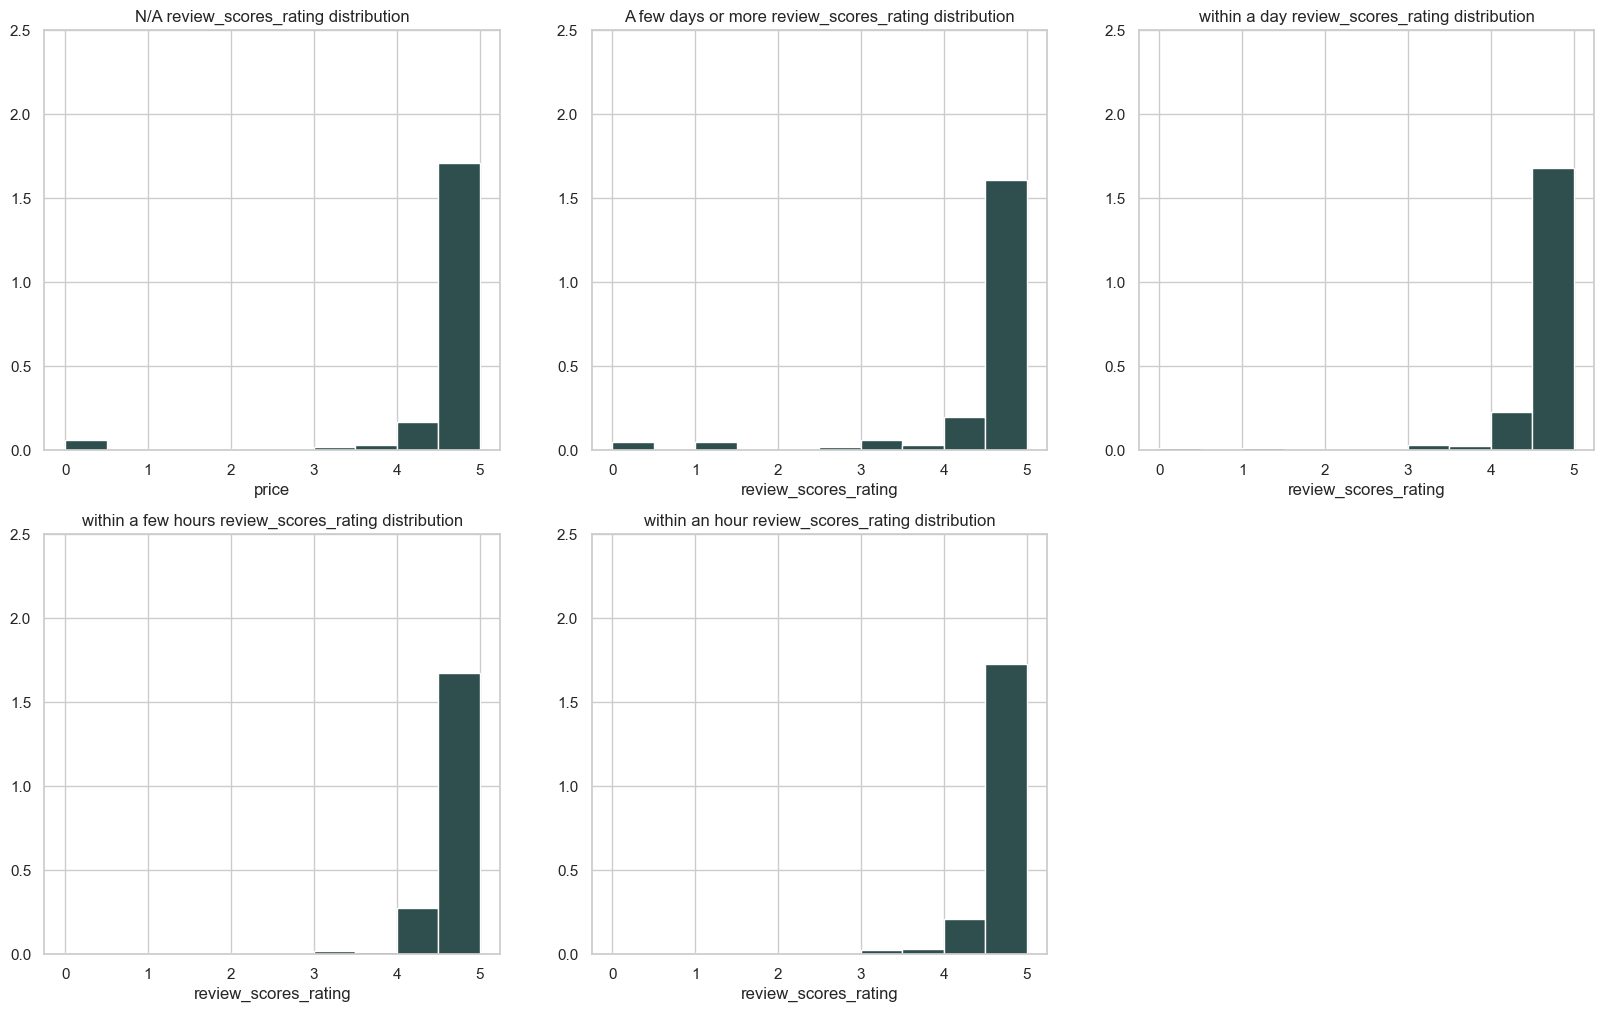

In [337]:
grouped = latest_listings_below_500.groupby("host_response_time")

figure = plt.figure(figsize=(20, 12))

axes = figure.add_subplot(2, 3, 1)
axes.hist(grouped["review_scores_rating"].get_group("N/A"),color="darkslategray",density=True, range=(0,5))
axes.set_ylim((0,2.5))
axes.set_title("N/A review_scores_rating distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(2, 3, 2)
axes.hist(grouped["review_scores_rating"].get_group("a few days or more"),color="darkslategray",density=True, range=(0,5))
axes.set_ylim((0,2.5))
axes.set_title("A few days or more review_scores_rating distribution")
axes.set_xlabel("review_scores_rating")

axes = figure.add_subplot(2, 3, 3)
axes.hist(grouped["review_scores_rating"].get_group("within a day"),color="darkslategray",density=True, range=(0,5))
axes.set_ylim((0,2.5))
axes.set_title("within a day review_scores_rating distribution")
axes.set_xlabel("review_scores_rating")

axes = figure.add_subplot(2, 3, 4)
axes.hist(grouped["review_scores_rating"].get_group("within a few hours"),color="darkslategray",density=True, range=(0,5))
axes.set_ylim((0,2.5))
axes.set_title("within a few hours review_scores_rating distribution")
axes.set_xlabel("review_scores_rating")

axes = figure.add_subplot(2, 3, 5)
axes.hist(grouped["review_scores_rating"].get_group("within an hour"),color="darkslategray",density=True, range=(0,5))
axes.set_ylim((0,2.5))
axes.set_title("within an hour review_scores_rating distribution")
axes.set_xlabel("review_scores_rating")

plt.show()
plt.close()

TODO: Discuss

## `host_response_rate` vs `review_scores_rating` <a id="host_response_rate_vs_rating"></a>

In [339]:
latest_listings['host_response_rate'] = latest_listings['host_response_rate'].replace('N/A',np.NaN)
latest_listings['host_response_rate'] = latest_listings['host_response_rate'].replace('%', '', regex=True).astype(float)

In [340]:
latest_listings['host_response_rate'].isnull().values.any()

True

In [342]:
latest_listings_non_null_host_response_rate = latest_listings[latest_listings["host_response_rate"].notnull() & (latest_listings["review_scores_rating"].notnull())]

In [343]:
correlation(latest_listings_non_null_host_response_rate, "review_scores_rating", "host_response_rate")

Correlation coefficients:
r   = 0.12900964402565684 (very weak)
rho = 0.17953795586786078 (weak)


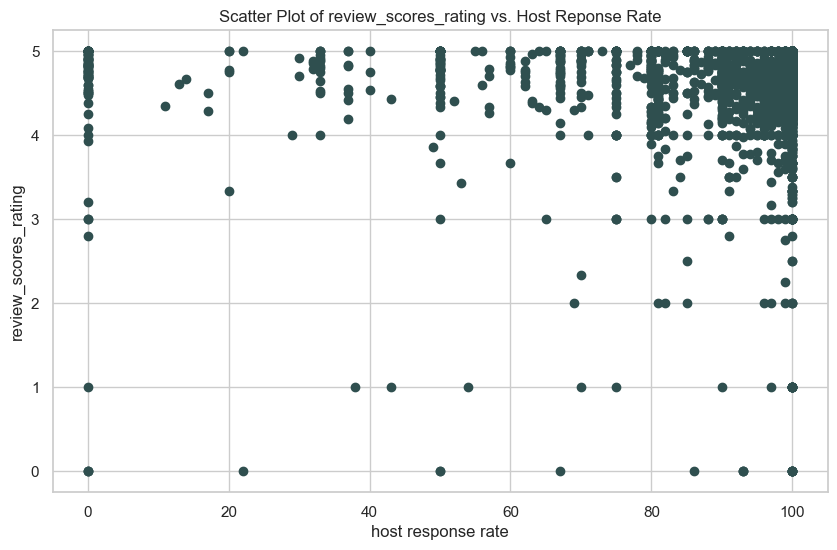

In [344]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_response_rate.host_response_rate, latest_listings_non_null_host_response_rate.review_scores_rating, marker="o", color="darkslategray")

axes.set_ylabel("review_scores_rating")
axes.set_xlabel("host response rate")
axes.set_title("Scatter Plot of review_scores_rating vs. Host Reponse Rate")

plt.show()
plt.close()

TODO: Discuss

## `host_acceptance_rate` vs `review_scores_rating` <a id="host_acceptance_rate_vs_rating"></a>

In [345]:
latest_listings['host_acceptance_rate'] = latest_listings['host_acceptance_rate'].replace('N/A',np.NaN)
latest_listings['host_acceptance_rate'] = latest_listings['host_acceptance_rate'].replace('%', '', regex=True).astype(float)

In [346]:
latest_listings['host_response_rate'].isnull().values.any()

True

In [347]:
latest_listings_non_null_host_acceptance_rate = latest_listings[latest_listings["host_acceptance_rate"].notnull() & (latest_listings["review_scores_rating"].notnull())]

In [348]:
correlation(latest_listings_non_null_host_acceptance_rate, "review_scores_rating", "host_acceptance_rate")

Correlation coefficients:
r   = 0.08305911272581257 (very weak)
rho = 0.02339755258475468 (very weak)


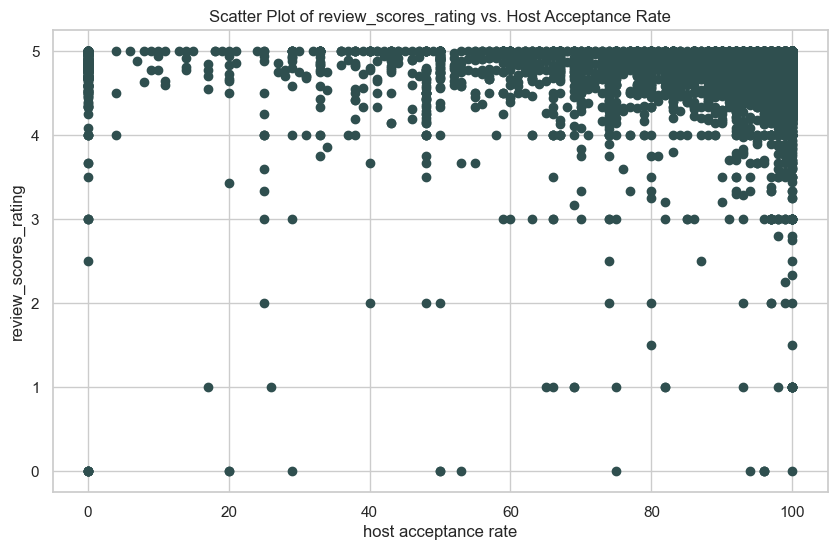

In [349]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_acceptance_rate.host_acceptance_rate, latest_listings_non_null_host_acceptance_rate.review_scores_rating, marker="o", color="darkslategray")

axes.set_ylabel("review_scores_rating")
axes.set_xlabel("host acceptance rate")
axes.set_title("Scatter Plot of review_scores_rating vs. Host Acceptance Rate")

plt.show()
plt.close()

TODO: Discuss

## `host_is_superhost` vs `review_scores_rating` <a id="host_is_superhost_vs_rating"></a>

In [350]:
latest_listings['host_is_superhost'].isnull().values.any()

True

In [351]:
latest_listings_non_null_host_is_superhost = latest_listings[latest_listings["host_is_superhost"].notnull()]

In [352]:
describe_by_category(latest_listings, "review_scores_rating", "host_is_superhost", transpose=True)

host_is_superhost        False         True
count              5228.000000  2509.000000
mean                  4.589294     4.871666
std                   0.750209     0.154819
min                   0.000000     2.000000
25%                   4.530000     4.830000
50%                   4.780000     4.900000
75%                   5.000000     4.960000
max                   5.000000     5.000000


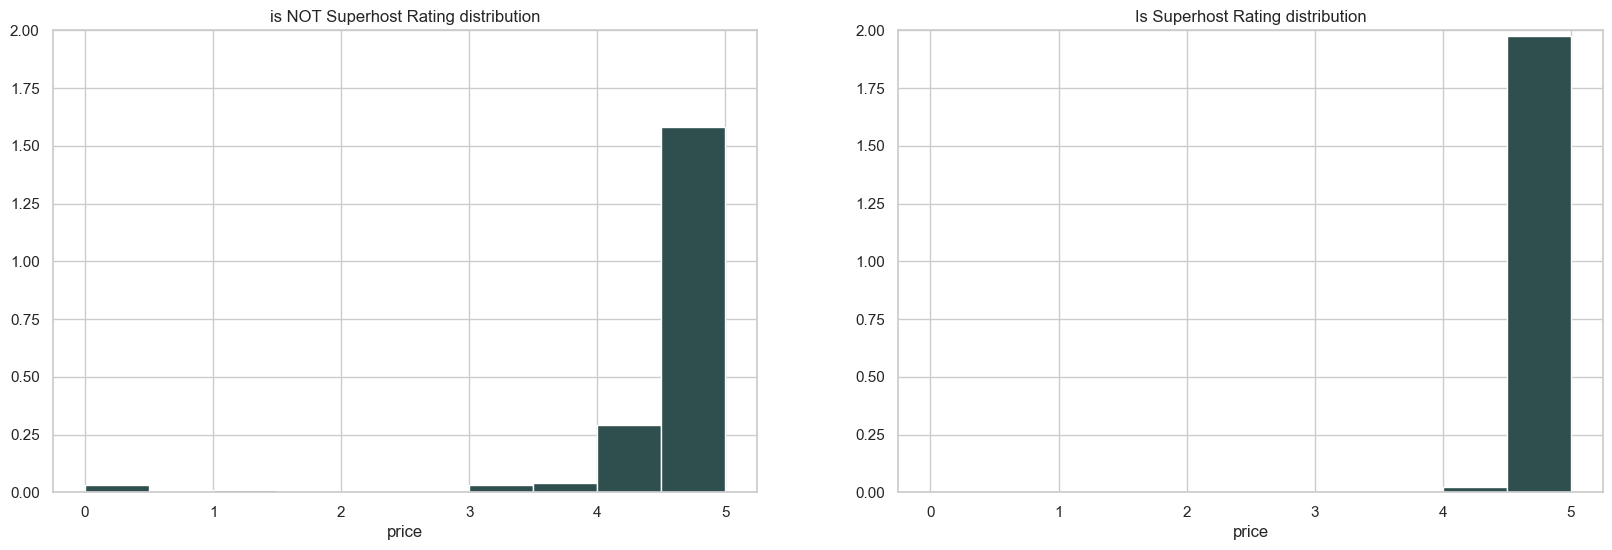

In [356]:
grouped = latest_listings.groupby("host_is_superhost")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1,2, 1)
axes.hist(grouped["review_scores_rating"].get_group(False),color="darkslategray",density=True, range=(0,5))
axes.set_ylim((0,2))
axes.set_title("is NOT Superhost Rating distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(1,2, 2)
axes.hist(grouped["review_scores_rating"].get_group(True),color="darkslategray",density=True, range=(0,5))
axes.set_ylim((0,2))
axes.set_title("Is Superhost Rating distribution")
axes.set_xlabel("price")

plt.show()
plt.close()

TODO: Discuss

## `host_listings_count` vs `review_scores_rating` <a id="host_listings_count_vs_rating"></a>

In [357]:
latest_listings['host_listings_count'].isnull().values.any()

True

In [360]:
latest_listings_non_null_host_listings_count = latest_listings[latest_listings["host_listings_count"].notnull() & (latest_listings["review_scores_rating"].notnull())]

In [361]:
correlation(latest_listings_non_null_host_listings_count , "review_scores_rating", "host_listings_count")

Correlation coefficients:
r   = -0.04056181809422287 (very weak)
rho = -0.21680666425614878 (weak)


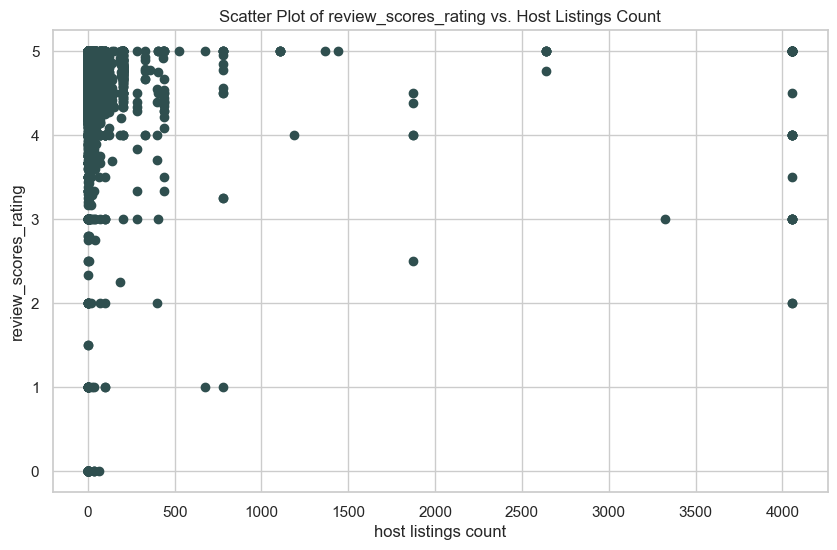

In [362]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_listings_count.host_listings_count, latest_listings_non_null_host_listings_count.review_scores_rating, marker="o", color="darkslategray")

axes.set_ylabel("review_scores_rating")
axes.set_xlabel("host listings count")
axes.set_title("Scatter Plot of review_scores_rating vs. Host Listings Count")

plt.show()
plt.close()

TODO: Discuss

In [365]:
latest_listings['host_listings_count_under_20'] = latest_listings.host_listings_count[latest_listings.host_listings_count < 20]

In [366]:
latest_listings_non_null_host_listings_under_20_count = latest_listings[latest_listings["host_listings_count_under_20"].notnull() & (latest_listings["review_scores_rating"].notnull())]

In [367]:
correlation(latest_listings_non_null_host_listings_under_20_count , "review_scores_rating", "host_listings_count_under_20")

Correlation coefficients:
r   = -0.019969452346313973 (very weak)
rho = -0.1829743493894682 (weak)


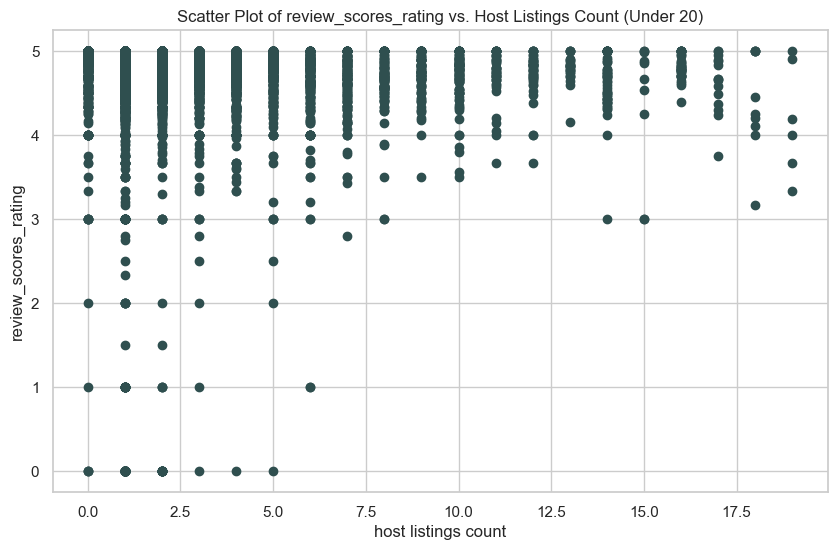

In [369]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_listings_under_20_count.host_listings_count_under_20, latest_listings_non_null_host_listings_under_20_count.review_scores_rating, marker="o", color="darkslategray")

axes.set_ylabel("review_scores_rating")
axes.set_xlabel("host listings count")
axes.set_title("Scatter Plot of review_scores_rating vs. Host Listings Count (Under 20)")

plt.show()
plt.close()

TODO: Discuss

## `host_total_listings_count` vs `review_scores_rating` <a id="host_total_listings_count_vs_rating"></a>
UNUSED

## `host_verifications` vs `review_scores_rating` <a id="host_verifications_vs_rating"></a>

In [145]:
latest_listings.host_verifications.value_counts(normalize=True)[:10]

['email', 'phone']                                                                                    0.550095
['email', 'phone', 'work_email']                                                                      0.136080
['phone']                                                                                             0.051705
['email', 'phone', 'reviews', 'kba']                                                                  0.024716
['email', 'phone', 'reviews', 'jumio', 'government_id']                                               0.016004
None                                                                                                  0.015341
['email', 'phone', 'reviews']                                                                         0.014583
['email', 'phone', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']    0.010511
['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'government_id']                      0.010133
[

## `host_has_profile_pic` vs `review_scores_rating` <a id="host_has_profile_pic_vs_rating"></a>

In [371]:
describe_by_category(latest_listings, "review_scores_rating", "host_has_profile_pic", transpose=True)

host_has_profile_pic      False         True
count                 43.000000  7566.000000
mean                   4.542093     4.682240
std                    0.652696     0.637028
min                    2.000000     0.000000
25%                    4.250000     4.662500
50%                    4.800000     4.850000
75%                    5.000000     4.970000
max                    5.000000     5.000000


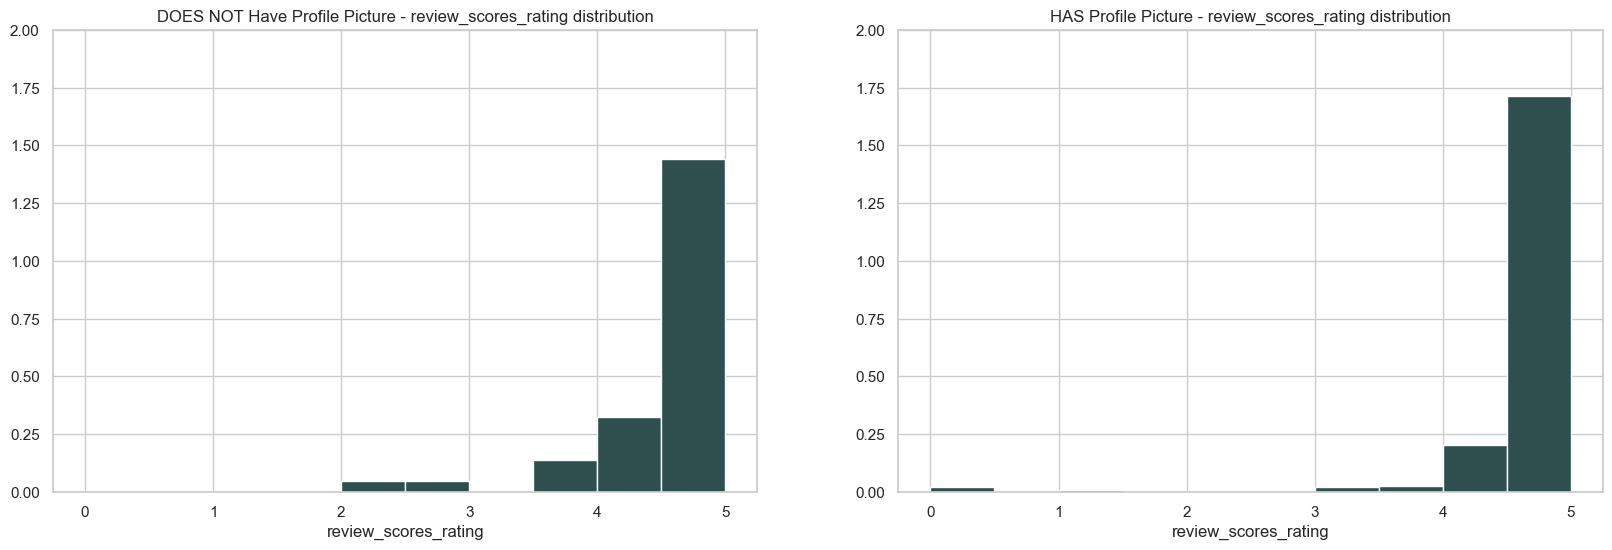

In [373]:
grouped = latest_listings.groupby("host_has_profile_pic")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1,2, 1)
axes.hist(grouped["review_scores_rating"].get_group(False),color="darkslategray",density=True, range=(0,5))
axes.set_ylim((0,2))
axes.set_title("DOES NOT Have Profile Picture - review_scores_rating distribution")
axes.set_xlabel("review_scores_rating")

axes = figure.add_subplot(1,2, 2)
axes.hist(grouped["review_scores_rating"].get_group(True),color="darkslategray",density=True, range=(0,5))
axes.set_ylim((0,2))
axes.set_title("HAS Profile Picture - review_scores_rating distribution")
axes.set_xlabel("review_scores_rating")

plt.show()
plt.close()

TODO: Discuss

## `host_identity_verified` vs `host_identity_verified` <a id="host_identity_verified_vs_rating"></a>

In [374]:
describe_by_category(latest_listings, "review_scores_rating", "host_identity_verified", transpose=True)

host_identity_verified        False         True
count                   1253.000000  6356.000000
mean                       4.618204     4.693916
std                        0.783510     0.603433
min                        0.000000     0.000000
25%                        4.620000     4.670000
50%                        4.830000     4.850000
75%                        4.970000     4.970000
max                        5.000000     5.000000


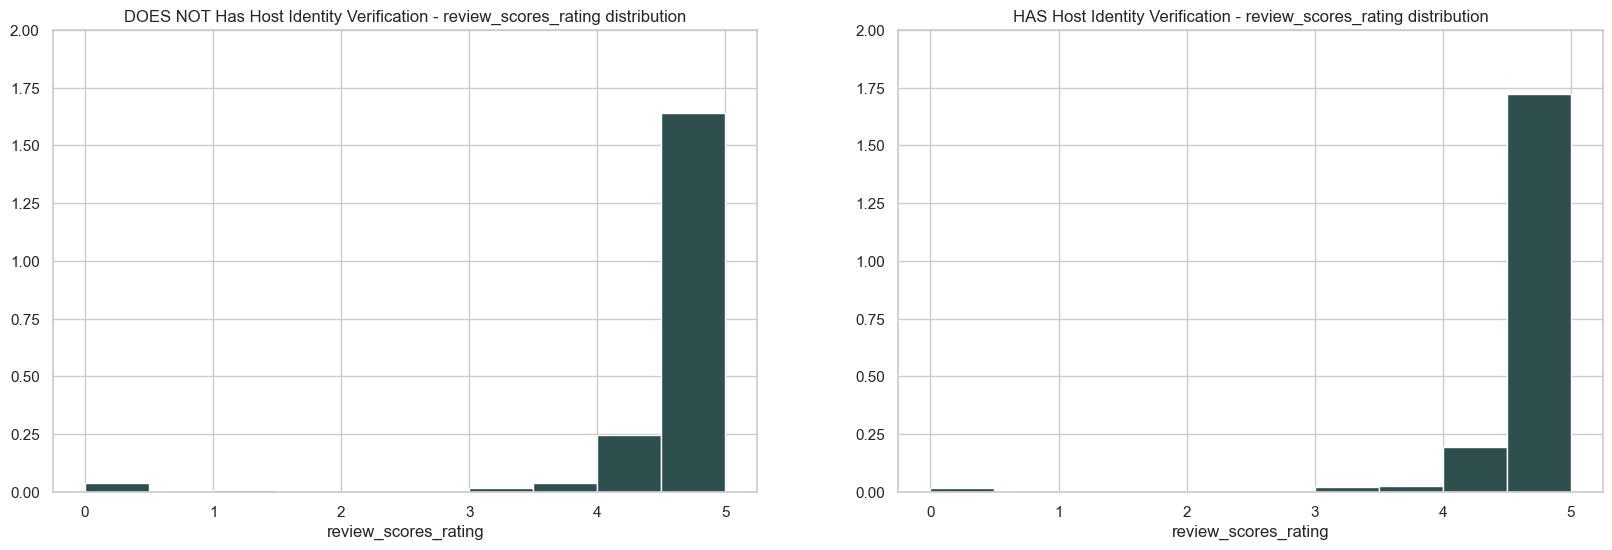

In [376]:
grouped = latest_listings.groupby("host_identity_verified")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1,2, 1)
axes.hist(grouped["review_scores_rating"].get_group(False),color="darkslategray",density=True, range=(0,5))
axes.set_ylim((0,2))
axes.set_title("DOES NOT Has Host Identity Verification - review_scores_rating distribution")
axes.set_xlabel("review_scores_rating")

axes = figure.add_subplot(1,2, 2)
axes.hist(grouped["review_scores_rating"].get_group(True),color="darkslategray",density=True, range=(0,5))
axes.set_ylim((0,2))
axes.set_title("HAS Host Identity Verification - review_scores_rating distribution")
axes.set_xlabel("review_scores_rating")

plt.show()
plt.close()

TODO: Discuss

# Close Connection

In [52]:
con.close()